## PH·∫¶N 1: C√ÄI ƒê·∫∂T, IMPORTS & THI·∫æT L·∫¨P BAN ƒê·∫¶U

In [1]:
# ==============================================================================
# CELL 1.1: C√ÄI ƒê·∫∂T TH∆Ø VI·ªÜN & BI·∫æN M√îI TR∆Ø·ªúNG (C·∫¨P NH·∫¨T)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# T·∫£i c√°c bi·∫øn m√¥i tr∆∞·ªùng
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- N√ÇNG C·∫§P: Chuy·ªÉn sang th∆∞ vi·ªán Google Generative AI (d√†nh cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- N√ÇNG C·∫§P: Th√™m c√¥ng c·ª• t√¨m ki·∫øm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Th∆∞ vi·ªán h·ªó tr·ª£ & Kho tri th·ª©c
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [2]:
# ==============================================================================
# CELL 1.2: C·∫§U H√åNH LOG & C√ÅC H√ÄM IN ·∫§N
# ==============================================================================
from langchain_groq import ChatGroq
# --- C·∫§U H√åNH LOG ---
VERBOSE_MODE = True

# --- KH·ªûI T·∫†O C√ÅC C√îNG C·ª§ IN ·∫§N ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "K·∫øt qu·∫£"):
    if VERBOSE_MODE:
        console.print(f"[bold green]‚úîÔ∏è {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]‚ö†Ô∏è  {message}[/bold yellow]")

In [3]:
# ==============================================================================
# CELL 1.3: KH·ªûI T·∫†O LLM (N√ÇNG C·∫§P SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # S·ª≠ d·ª•ng model m·ªõi nh·∫•t v√† m·∫°nh nh·∫•t
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("‚úÖ LLM (Gemini 2.5 Flash t·ª´ Google AI Studio) ƒë√£ ƒë∆∞·ª£c kh·ªüi t·∫°o th√†nh c√¥ng.")
except Exception as e:
    print(f"‚ùå L·ªñI: Kh√¥ng th·ªÉ kh·ªüi t·∫°o LLM. H√£y ch·∫Øc ch·∫Øn b·∫°n ƒë√£ c√†i 'langchain-google-genai' v√† c√≥ GOOGLE_API_KEY trong file .env. L·ªói: {e}")
    llm = None

‚úÖ LLM (Gemini 2.5 Flash t·ª´ Google AI Studio) ƒë√£ ƒë∆∞·ª£c kh·ªüi t·∫°o th√†nh c√¥ng.


## PH·∫¶N 2: ƒê·ªäNH NGHƒ®A STATE C·ª¶A H·ªÜ TH·ªêNG


In [4]:
# ==============================================================================
# CELL 1.4: T·∫¢I KHO TRI TH·ª®C (RAG)
# ==============================================================================
# --- T·∫¢I KHO TRI TH·ª®C ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"‚ùå L·ªñI: Kh√¥ng t√¨m th·∫•y th∆∞ m·ª•c con n√†o trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"ƒêang t·∫£i v√† h·ª£p nh·∫•t c√°c kho tri th·ª©c t·ª´ {len(subdirectories)} th∆∞ m·ª•c...")
            # T·∫£i kho tri th·ª©c ƒë·∫ßu ti√™n ƒë·ªÉ l√†m c∆° s·ªü
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"‚úÖ ƒê√£ t·∫£i th√†nh c√¥ng kho tri th·ª©c c∆° s·ªü: '{os.path.basename(first_store_path)}'")

            # H·ª£p nh·∫•t c√°c kho tri th·ª©c c√≤n l·∫°i
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"‚úÖ ƒê√£ h·ª£p nh·∫•t th√†nh c√¥ng: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"B·ªè qua th∆∞ m·ª•c '{os.path.basename(store_path)}' v√¨ kh√¥ng ch·ª©a file index.faiss.")
            
            print("\n[bold green]‚úîÔ∏è T·∫•t c·∫£ c√°c kho tri th·ª©c RAG ƒë√£ ƒë∆∞·ª£c t·∫£i v√† h·ª£p nh·∫•t th√†nh c√¥ng.[/bold green]")

        except Exception as e:
            print(f"‚ùå L·ªñI trong qu√° tr√¨nh t·∫£i ho·∫∑c h·ª£p nh·∫•t kho tri th·ª©c: {e}")
else:
    print(f"‚ùå L·ªñI: Kh√¥ng t√¨m th·∫•y th∆∞ m·ª•c g·ªëc c·ªßa kho tri th·ª©c t·∫°i '{BASE_VECTOR_STORE_PATH}'.")


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> ƒêang t·∫£i v√† h·ª£p nh·∫•t c√°c kho tri th·ª©c t·ª´ 2 th∆∞ m·ª•c...

‚úÖ ƒê√£ t·∫£i th√†nh c√¥ng kho tri th·ª©c c∆° s·ªü: 'sgk_toan_12_1'
‚úÖ ƒê√£ h·ª£p nh·∫•t th√†nh c√¥ng: 'sgk_toan_9'

[bold green]‚úîÔ∏è T·∫•t c·∫£ c√°c kho tri th·ª©c RAG ƒë√£ ƒë∆∞·ª£c t·∫£i v√† h·ª£p nh·∫•t th√†nh c√¥ng.[/bold green]


In [5]:
# ==============================================================================
# CELL 1.5: KH·ªûI T·∫†O V√Ä QU·∫¢N L√ù TR√ç NH·ªö D√ÄI H·∫†N (N√ÇNG C·∫§P V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# H√†m ƒë·ªÉ t·∫£i tr√≠ nh·ªõ t·ª´ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# H√†m ƒë·ªÉ l∆∞u m·ªôt gi√°o √°n m·ªõi v√†o tr√≠ nh·ªõ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("üß† ƒê√£ l∆∞u gi√°o √°n th√†nh c√¥ng v√†o Tr√≠ nh·ªõ D√†i h·∫°n.")

# H√†m ƒë·ªÉ t·∫°o m·ªôt vector store t·ª´ tr√≠ nh·ªõ (ƒë·ªÉ t√¨m ki·∫øm t∆∞∆°ng ƒë·ªìng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Tr√≠ nh·ªõ tr·ªëng, kh√¥ng c√≥ g√¨ ƒë·ªÉ x√¢y d·ª±ng vector store.")
        return

    # Ch·ªâ l·∫•y ph·∫ßn 'request' ƒë·ªÉ t√¨m ki·∫øm
    texts = [item['request'] for item in memory_content]
    # L∆∞u to√†n b·ªô item l√†m metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("‚úÖ ƒê√£ x√¢y d·ª±ng Vector Store cho Tr√≠ nh·ªõ D√†i h·∫°n.")

# T·ª± ƒë·ªông x√¢y d·ª±ng vector store khi kh·ªüi ƒë·ªông notebook
build_memory_vector_store()

> ‚úÖ ƒê√£ x√¢y d·ª±ng Vector Store cho Tr√≠ nh·ªõ D√†i h·∫°n.

In [6]:
# ==============================================================================
# CELL 2.1: ƒê·ªäNH NGHƒ®A STATE N√ÇNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- H√†m ti·ªán √≠ch (gi·ªØ nguy√™n) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- C·∫•u tr√∫c d·ªØ li·ªáu con (gi·ªØ nguy√™n) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === N√ÇNG C·∫§P V9.0: C√ÅC C·∫§U TR√öC D·ªÆ LI·ªÜU M·ªöI CHO T∆Ø DUY S√ÇU ===
class DifferentiatedInstruction(TypedDict):
    """G·ª£i √Ω cho vi·ªác d·∫°y h·ªçc ph√¢n h√≥a trong m·ªôt ho·∫°t ƒë·ªông."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """ƒê·ªãnh nghƒ©a m·ªôt ho·∫°t ƒë·ªông ho·∫∑c ƒë√°nh gi√° c√≥ c·∫•u tr√∫c."""
    task_id: int
    activity_name: str
    question_or_description: str # G·ªôp 'question' v√† 'description'
    duration_minutes: int
    content_type: str # G·ªôp 'activity_type' v√† 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # D√†nh cho c√¢u h·ªèi ƒë√°nh gi√°
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """ƒê·ªãnh nghƒ©a c·∫•u tr√∫c JSON cho gi√°o √°n cu·ªëi c√πng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # D√†nh cho n√¢ng c·∫•p t∆∞∆°ng lai

# === N√ÇNG C·∫§P V9.0: STATE M·ªöI V·ªöI C√ÅC TR∆Ø·ªúNG TR√ç TU·ªÜ M·ªöI ===
class TeacherStateV5(TypedDict):
    # C√°c tr∆∞·ªùng c∆° b·∫£n
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === N√ÇNG C·∫§P: student_persona gi·ªù s·∫Ω ch·ª©a c·∫£ chi·∫øn l∆∞·ª£c ph√¢n h√≥a ===
    student_persona: Optional[Dict[str, Any]] 
    
    # C√°c b∆∞·ªõc tu·∫ßn t·ª± ban ƒë·∫ßu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # C√°c tr∆∞·ªùng n√¢ng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    current_task_retry_count: int  # <-- TH√äM D√íNG N√ÄY V√ÄO ƒê√ÇY
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # C√°c tr∆∞·ªùng t·∫°m th·ªùi cho v√≤ng l·∫∑p ki·ªÉm duy·ªát vi m√¥ (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === N√ÇNG C·∫§P: Output cu·ªëi c√πng s·∫Ω c√≥ 2 d·∫°ng ===
    final_structured_plan: Optional[FinalStructuredPlan] # D·∫°ng JSON c√≥ c·∫•u tr√∫c
    final_markdown_plan: Optional[str] # D·∫°ng Markdown ƒë·ªÉ hi·ªÉn th·ªã


print("‚úÖ 'TeacherStateV5' (v9.0 - H·ªó tr·ª£ Ph√¢n h√≥a & C·∫•u tr√∫c) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.")

‚úÖ 'TeacherStateV5' (v9.0 - H·ªó tr·ª£ Ph√¢n h√≥a & C·∫•u tr√∫c) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.


In [7]:
# ==============================================================================
# CELL 2.2: NODE KH·ªûI T·∫†O STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node ƒë·∫ßu ti√™n trong graph.
    L·∫•y y√™u c·∫ßu g·ªëc t·ª´ tin nh·∫Øn ƒë·∫ßu v√†o v√† ƒëi·ªÅn v√†o tr∆∞·ªùng 'original_request'.
    """
    print_step("`Initializer`: ƒêang kh·ªüi t·∫°o tr·∫°ng th√°i v√† l·∫•y y√™u c·∫ßu g·ªëc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("‚úÖ Node kh·ªüi t·∫°o 'initialize_state_node' ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.")

‚úÖ Node kh·ªüi t·∫°o 'initialize_state_node' ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.


## PH·∫¶N 3: ƒê·ªäNH NGHƒ®A C√ÅC AGENT

In [8]:
# ==============================================================================
# CELL 3.1: H√ÄM TI·ªÜN √çCH & C·∫§U TR√öC D·ªÆ LI·ªÜU (v9.7 - T∆Ø DUY LINH HO·∫†T)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- C√°c h√†m ti·ªán √≠ch gi·ªØ nguy√™n ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Ch∆∞a c√≥ h∆∞·ªõng d·∫´n."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Gi√°o vi√™n quan s√°t v√† h·ªó tr·ª£ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "B·∫†N L√Ä M·ªòT TR·ª¢ L√ù AI CHUY√äN NGHI·ªÜP, ƒê√ìNG VAI TR√í M·ªòT GI√ÅO VI√äN GI√ÄU KINH NGHI·ªÜM T·∫†I VI·ªÜT NAM. LU√îN LU√îN tr·∫£ l·ªùi b·∫±ng TI·∫æNG VI·ªÜT."

# === C·∫¨P NH·∫¨T C·∫§U TR√öC HO·∫†T ƒê·ªòNG LINH HO·∫†T ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="G·ª£i √Ω c·ª• th·ªÉ cho nh√≥m h·ªçc sinh y·∫øu/g·∫∑p kh√≥ khƒÉn.")
    for_advanced_students: str = Field(description="G·ª£i √Ω, th·ª≠ th√°ch ho·∫∑c ho·∫°t ƒë·ªông n√¢ng cao cho nh√≥m h·ªçc sinh gi·ªèi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="T√™n c·ªßa ho·∫°t ƒë·ªông h·ªçc t·∫≠p.")
    activity_type: str = Field(description="Ph√¢n lo·∫°i ho·∫°t ƒë·ªông. V√≠ d·ª•: 'Th·∫£o lu·∫≠n nh√≥m', 'Th·ª±c h√†nh c√° nh√¢n'")
    duration_minutes: int = Field(description="T·ªïng th·ªùi gian ∆∞·ªõc t√≠nh (b·∫±ng S·ªê PH√öT) cho c·∫£ hai ph·∫ßn.")
    teacher_actions: List[str] = Field(description="Danh s√°ch c√°c h√†nh ƒë·ªông C·ª§ TH·ªÇ c·ªßa GI√ÅO VI√äN.")
    # Thay 'description' b·∫±ng c·∫•u tr√∫c L√µi/M·ªü r·ªông
    core_component: str = Field(description="M√¥ t·∫£ ph·∫ßn ho·∫°t ƒë·ªông C·ªêT L√ïI m√† T·∫§T C·∫¢ h·ªçc sinh c·∫ßn ho√†n th√†nh.")
    extension_component: Optional[str] = Field(description="M√¥ t·∫£ ph·∫ßn ho·∫°t ƒë·ªông M·ªû R·ªòNG d√†nh cho h·ªçc sinh l√†m nhanh ho·∫∑c n·∫øu c√≤n d∆∞ th·ªùi gian.")
    solution_guide: Optional[Any] = Field(description="H∆∞·ªõng d·∫´n gi·∫£i ho·∫∑c c√°c c√¢u h·ªèi g·ª£i m·ªü.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="G·ª£i √Ω ph√¢n h√≥a c·ª• th·ªÉ cho ho·∫°t ƒë·ªông n√†y.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="T√™n c·ªßa ho·∫°t ƒë·ªông ƒë√°nh gi√°.")
    question_type: str = Field(description="Lo·∫°i c√¢u h·ªèi. V√≠ d·ª•: 'T·ª± lu·∫≠n', 'Tr·∫Øc nghi·ªám'")
    duration_minutes: int = Field(description="T·ªïng th·ªùi gian ∆∞·ªõc t√≠nh (b·∫±ng S·ªê PH√öT) cho c·∫£ hai ph·∫ßn.")
    teacher_actions: List[str] = Field(description="Danh s√°ch c√°c h√†nh ƒë·ªông C·ª§ TH·ªÇ c·ªßa GI√ÅO VI√äN.")
    # Thay 'question' b·∫±ng c·∫•u tr√∫c L√µi/M·ªü r·ªông
    core_component: str = Field(description="N·ªôi dung c√¢u h·ªèi ho·∫∑c ƒë·ªÅ b√†i C·ªêT L√ïI m√† T·∫§T C·∫¢ h·ªçc sinh c·∫ßn ho√†n th√†nh.")
    extension_component: Optional[str] = Field(description="C√¢u h·ªèi ph·ª• ho·∫∑c th·ª≠ th√°ch M·ªû R·ªòNG d√†nh cho h·ªçc sinh l√†m nhanh ho·∫∑c n·∫øu c√≤n d∆∞ th·ªùi gian.")
    answer: str = Field(description="ƒê√°p √°n ch√≠nh x√°c v√† ng·∫Øn g·ªçn cho ph·∫ßn C·ªêT L√ïI.")
    solution_guide: Any = Field(description="H∆∞·ªõng d·∫´n gi·∫£i chi ti·∫øt t·ª´ng b∆∞·ªõc.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="G·ª£i √Ω ph√¢n h√≥a c·ª• th·ªÉ cho ho·∫°t ƒë·ªông n√†y.")

# --- C√°c model kh√°c gi·ªØ nguy√™n ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung b√¨nh", "ch·∫≠m"] = Field(description="T·ªëc ƒë·ªô h·ªçc t·∫≠p chung c·ªßa l·ªõp.")
    engagement_style: Literal["ch·ªß ƒë·ªông", "th·ª• ƒë·ªông", "h·ªón h·ª£p"] = Field(description="M·ª©c ƒë·ªô tham gia chung c·ªßa l·ªõp.")
    special_notes: str = Field(description="T√≥m t·∫Øt c√°c ƒë·∫∑c ƒëi·ªÉm n·ªïi b·∫≠t c·ªßa l·ªõp h·ªçc.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chi·∫øn l∆∞·ª£c d·∫°y h·ªçc ph√¢n h√≥a t·ªïng th·ªÉ cho c·∫£ b√†i h·ªçc d·ª±a tr√™n c√°c ƒë·∫∑c ƒëi·ªÉm c·ªßa l·ªõp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="T√™n c·ªßa nhi·ªám v·ª• n√†y.")
    task_description: str = Field(description="M√¥ t·∫£ chi ti·∫øt nhi·ªám v·ª• c·∫ßn th·ª±c hi·ªán.")
    estimated_duration: int = Field(description="Th·ªùi gian ∆∞·ªõc t√≠nh (b·∫±ng ph√∫t) cho nhi·ªám v·ª• n√†y.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="T√™n c·ªßa ph∆∞∆°ng ph√°p s∆∞ ph·∫°m ƒë∆∞·ª£c ch·ªçn.")
    rationale: str = Field(description="L√Ω do t·∫°i sao ph∆∞∆°ng ph√°p n√†y ph√π h·ª£p.")
    key_actions: List[str] = Field(description="Danh s√°ch c√°c h√†nh ƒë·ªông/ho·∫°t ƒë·ªông c·ªët l√µi ƒë·∫∑c tr∆∞ng cho ph∆∞∆°ng ph√°p n√†y.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="N·ªôi dung c√≥ h·ª£p l·ªá v√† ch√≠nh x√°c v·ªÅ m·∫∑t chuy√™n m√¥n kh√¥ng.")
    feedback: str = Field(description="Ph·∫£n h·ªìi chi ti·∫øt. N·∫øu kh√¥ng h·ª£p l·ªá, h√£y gi·∫£i th√≠ch r√µ r√†ng l·ªói sai v√† g·ª£i √Ω c√°ch s·ª≠a.")
    suggested_duration: Optional[int] = Field(default=None, description="N·∫øu c√≥ l·ªói v·ªÅ th·ªùi gian, h√£y ƒë·ªÅ xu·∫•t m·ªôt th·ªùi l∆∞·ª£ng h·ª£p l√Ω h∆°n (t√≠nh b·∫±ng S·ªê PH√öT).")

class Domain(BaseModel): domain: str = Field(description="Lƒ©nh v·ª±c h·ªçc thu·∫≠t ch√≠nh c·ªßa y√™u c·∫ßu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("‚úÖ C√°c c·∫•u tr√∫c d·ªØ li·ªáu Pydantic (v9.7 - Ho·∫°t ƒë·ªông Linh ho·∫°t) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.")

‚úÖ C√°c c·∫•u tr√∫c d·ªØ li·ªáu Pydantic (v9.7 - Ho·∫°t ƒë·ªông Linh ho·∫°t) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.


In [9]:
# ==============================================================================
# CELL 3.2: AGENT PH√ÇN T√çCH Y√äU C·∫¶U BAN ƒê·∫¶U (N√ÇNG C·∫§P V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) ƒëang ph√¢n t√≠ch m·ª•c ti√™u...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHI·ªÜM V·ª§:** ƒê·ªçc y√™u c·∫ßu c·ªßa ng∆∞·ªùi d√πng v√† tr√≠ch xu·∫•t c√°c th√¥ng tin sau.\n**Y√äU C·∫¶U:** \"{state['original_request']}\"\n**C√ÅC TR∆Ø·ªúNG C·∫¶N TR√çCH XU·∫§T:** `action_verb`, `bloom_level` (S·ªê NGUY√äN), `topic`, `grade_level`, `duration_minutes`.\n**CH·ªà TR·∫¢ V·ªÄ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "M·ª•c ti√™u & R√†ng bu·ªôc ƒë√£ ph√¢n t√≠ch")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Objective Interpreter: {e}. S·ª≠ d·ª•ng m·ª•c ti√™u m·∫∑c ƒë·ªãnh.")
        return {"analyzed_objective": { "action_verb": "so·∫°n", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) ƒëang x√°c ƒë·ªãnh lƒ©nh v·ª±c chuy√™n m√¥n...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHI·ªÜM V·ª§:** ƒê·ªçc y√™u c·∫ßu c·ªßa ng∆∞·ªùi d√πng v√† x√°c ƒë·ªãnh lƒ©nh v·ª±c h·ªçc thu·∫≠t ch√≠nh.\n**Y√äU C·∫¶U:** \"{state['original_request']}\"\n**Lƒ®NH V·ª∞C C√ì TH·ªÇ CH·ªåN:** 'To√°n h·ªçc', 'V·∫≠t l√Ω', 'H√≥a h·ªçc', 'Sinh h·ªçc', 'VƒÉn h·ªçc', 'L·ªãch s·ª≠', 'ƒê·ªãa l√Ω', 'Ngo·∫°i ng·ªØ', 'Tin h·ªçc'.\n**Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lƒ©nh v·ª±c chuy√™n m√¥n ƒë∆∞·ª£c x√°c ƒë·ªãnh")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Domain Classifier: {e}. S·ª≠ d·ª•ng lƒ©nh v·ª±c m·∫∑c ƒë·ªãnh 'To√°n h·ªçc'.")
        return {"domain": "To√°n h·ªçc"}

# === N√ÇNG C·∫§P: Agent n√†y gi·ªù ƒë√¢y l√† m·ªôt nh√† t∆∞ v·∫•n chi·∫øn l∆∞·ª£c ===
# === S·ª¨A L·ªñI PARSING: Prompt ƒë∆∞·ª£c l√†m r√µ r√†ng h∆°n v·ªÅ c·∫•u tr√∫c l·ªìng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) ƒëang ph√¢n t√≠ch v√† ƒë·ªÅ xu·∫•t chi·∫øn l∆∞·ª£c ph√¢n h√≥a...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt chuy√™n gia s∆∞ ph·∫°m, chuy√™n v·ªÅ d·∫°y h·ªçc ph√¢n h√≥a.
    **NHI·ªÜM V·ª§:** Ph√¢n t√≠ch m√¥ t·∫£ v·ªÅ l·ªõp h·ªçc d∆∞·ªõi ƒë√¢y v√† ƒë·ªÅ xu·∫•t m·ªôt chi·∫øn l∆∞·ª£c d·∫°y h·ªçc ph√¢n h√≥a T·ªîNG TH·ªÇ cho c·∫£ bu·ªïi h·ªçc.
    **Y√äU C·∫¶U C·ª¶A GI√ÅO VI√äN:** "{state['original_request']}"
    
    **C√ÅC B∆Ø·ªöC SUY LU·∫¨N (B·∫ÆT BU·ªòC):**
    1.  **Ph√¢n t√≠ch ƒê·∫∑c ƒëi·ªÉm:** D·ª±a v√†o c√°c t·ª´ kh√≥a, h√£y x√°c ƒë·ªãnh `learning_pace`, `engagement_style`, v√† t√≥m t·∫Øt v√†o `special_notes`.
    2.  **ƒê·ªÅ xu·∫•t Chi·∫øn l∆∞·ª£c Ph√¢n h√≥a:** D·ª±a tr√™n ph√¢n t√≠ch tr√™n, h√£y ƒëi·ªÅn v√†o ƒë·ªëi t∆∞·ª£ng `differentiation_strategy`. ƒê√¢y PH·∫¢I l√† m·ªôt ƒë·ªëi t∆∞·ª£ng JSON c√≥ 2 tr∆∞·ªùng sau:
        -   `for_struggling_students`: M·ªôt chi·∫øn l∆∞·ª£c c·ª• th·ªÉ ƒë·ªÉ **h·ªó tr·ª£** nh√≥m h·ªçc sinh c√≥ th·ªÉ g·∫∑p kh√≥ khƒÉn. (V√≠ d·ª•: "Chia nh·ªè nhi·ªám v·ª•, cung c·∫•p phi·∫øu b√†i t·∫≠p c√≥ g·ª£i √Ω c√¥ng th·ª©c, cho ph√©p th√™m th·ªùi gian.")
        -   `for_advanced_students`: M·ªôt chi·∫øn l∆∞·ª£c c·ª• th·ªÉ ƒë·ªÉ **th·ª≠ th√°ch** nh√≥m h·ªçc sinh kh√° gi·ªèi. (V√≠ d·ª•: "Chu·∫©n b·ªã c√°c c√¢u h·ªèi m·ªü r·ªông 'T·∫°i sao?' v√† 'N·∫øu... th√¨ sao?', giao m·ªôt b√†i to√°n ·ª©ng d·ª•ng th·ª±c t·∫ø nh·ªè.")

    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** B·∫ÆT BU·ªòC tr·∫£ v·ªÅ m·ªôt ƒë·ªëi t∆∞·ª£ng JSON duy nh·∫•t tu√¢n th·ªß schema `StudentPersonaAndDifferentiation`. Tr∆∞·ªùng `differentiation_strategy` PH·∫¢I l√† m·ªôt object l·ªìng v√†o b√™n trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "H·ªì s∆° l·ªõp h·ªçc v√† Chi·∫øn l∆∞·ª£c Ph√¢n h√≥a")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Differentiated Instruction Advisor: {e}. S·ª≠ d·ª•ng h·ªì s∆° m·∫∑c ƒë·ªãnh.")
        fallback_persona = {
            "learning_pace": "trung b√¨nh",
            "engagement_style": "h·ªón h·ª£p",
            "special_notes": "Kh√¥ng c√≥ ghi ch√∫ ƒë·∫∑c bi·ªát.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan s√°t v√† h·ªó tr·ª£ th√™m khi c·∫ßn thi·∫øt.",
                "for_advanced_students": "Khuy·∫øn kh√≠ch c√°c em t√¨m t√≤i th√™m."
            }
        }
        return {"student_persona": fallback_persona}

print("‚úÖ C√°c agent ph√¢n t√≠ch y√™u c·∫ßu ban ƒë·∫ßu (v9.0 - H·ªó tr·ª£ Ph√¢n h√≥a) ƒë√£ s·∫µn s√†ng.")

‚úÖ C√°c agent ph√¢n t√≠ch y√™u c·∫ßu ban ƒë·∫ßu (v9.0 - H·ªó tr·ª£ Ph√¢n h√≥a) ƒë√£ s·∫µn s√†ng.


In [10]:
# ==============================================================================
# CELL 3.3: AGENT L·∫¨P K·∫æ HO·∫†CH CHI·∫æN L∆Ø·ª¢C (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) ƒëang x√¢y d·ª±ng chi·∫øn l∆∞·ª£c s∆∞ ph·∫°m chi ti·∫øt...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **M·ª§C TI√äU B√ÄI H·ªåC:** {state.get('analyzed_objective')}
    **H·ªí S∆† L·ªöP H·ªåC:** {state.get('student_persona')}
    **NHI·ªÜM V·ª§:** D·ª±a v√†o m·ª•c ti√™u v√† h·ªì s∆° l·ªõp h·ªçc, h√£y ch·ªçn M·ªòT ph∆∞∆°ng ph√°p s∆∞ ph·∫°m ph√π h·ª£p nh·∫•t. Sau ƒë√≥, ph√¢n t√≠ch ph∆∞∆°ng ph√°p ƒë√≥ th√†nh c√°c h√†nh ƒë·ªông c·ªët l√µi.
    **V√ç D·ª§:** N·∫øu ch·ªçn 'D·∫°y h·ªçc theo d·ª± √°n', key_actions c√≥ th·ªÉ l√† ["Giao d·ª± √°n", "H·ªçc sinh l√†m vi·ªác nh√≥m", "B√°o c√°o s·∫£n ph·∫©m"].
    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi c√°c key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chi·∫øn l∆∞·ª£c s∆∞ ph·∫°m chi ti·∫øt")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Pedagogy Strategist: {e}. S·ª≠ d·ª•ng chi·∫øn l∆∞·ª£c m·∫∑c ƒë·ªãnh.")
        return {"pedagogy_strategy": {"name": "D·∫°y h·ªçc gi·∫£i quy·∫øt v·∫•n ƒë·ªÅ", "rationale": "M·∫∑c ƒë·ªãnh do l·ªói.", "key_actions": ["N√™u v·∫•n ƒë·ªÅ", "H·ªçc sinh t√¨m gi·∫£i ph√°p", "Tr√¨nh b√†y k·∫øt qu·∫£"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) ƒëang thi·∫øt k·∫ø k·ªãch b·∫£n bu·ªïi h·ªçc...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **V√ç D·ª§ THAM KH·∫¢O (T·ª™ M·ªòT GI√ÅO √ÅN TH√ÄNH C√îNG TR∆Ø·ªöC ƒê√ÇY):**
        ƒê√¢y l√† m·ªôt lu·ªìng ho·∫°t ƒë·ªông ƒë√£ ƒë∆∞·ª£c ch·ª©ng minh l√† hi·ªáu qu·∫£ cho m·ªôt ch·ªß ƒë·ªÅ t∆∞∆°ng t·ª±. H√£y h·ªçc h·ªèi c·∫•u tr√∫c v√† c√°ch ti·∫øp c·∫≠n t·ª´ n√≥:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} V·ªõi vai tr√≤ l√† m·ªôt chuy√™n gia thi·∫øt k·∫ø tr·∫£i nghi·ªám h·ªçc t·∫≠p.
    **NHI·ªÜM V·ª§:** X√¢y d·ª±ng m·ªôt "B·∫£n thi·∫øt k·∫ø S∆∞ ph·∫°m" - m·ªôt k·ªãch b·∫£n C·∫§P CAO cho bu·ªïi h·ªçc.
    
    {example_prompt_part}
    **QUY T·∫ÆC:**
    1.  T·∫°o ra 3-5 giai ƒëo·∫°n ch√≠nh cho d√≤ng ch·∫£y c·ªßa bu·ªïi h·ªçc.
    2.  M·ªói giai ƒëo·∫°n ph·∫£i c√≥ t√™n (`stage_name`), m·ª•c ti√™u (`stage_objective`), v√† ƒë·ªãnh h∆∞·ªõng (`stage_direction`).
    3.  ƒê·∫£m b·∫£o ƒë·ªô kh√≥ tƒÉng ti·∫øn qua c√°c giai ƒëo·∫°n.
    **TH√îNG TIN PH√ÇN T√çCH:**
    - M·ª•c ti√™u: {state.get('analyzed_objective')}
    - H·ªì s∆° l·ªõp h·ªçc: {state.get('student_persona')}
    - Chi·∫øn l∆∞·ª£c S∆∞ ph·∫°m: {state.get('pedagogy_strategy')}
    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi key l√† `blueprint`, gi√° tr·ªã l√† m·ªôt danh s√°ch c√°c ƒë·ªëi t∆∞·ª£ng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "B·∫£n thi·∫øt k·∫ø S∆∞ ph·∫°m ƒë√£ ƒë∆∞·ª£c t·∫°o")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Pedagogical Architect: {e}. S·ª≠ d·ª•ng blueprint m·∫∑c ƒë·ªãnh.")
        return {"pedagogical_blueprint": ["Giai ƒëo·∫°n 1: Gi·ªõi thi·ªáu b√†i h·ªçc", "Giai ƒëo·∫°n 2: Luy·ªán t·∫≠p", "Giai ƒëo·∫°n 3: ƒê√°nh gi√°"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) ƒëang t√¨m ki·∫øm trong tr√≠ nh·ªõ...")
    
    if not memory_vector_store:
        print_warning("Kh√¥ng c√≥ Tr√≠ nh·ªõ D√†i h·∫°n. B·ªè qua b∆∞·ªõc n√†y.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # T√¨m ki·∫øm 1 v√≠ d·ª• t∆∞∆°ng ƒë·ªìng nh·∫•t trong tr√≠ nh·ªõ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Ch·ªâ l·∫•y n·∫øu ƒë·ªô t∆∞∆°ng ƒë·ªìng cao (ƒëi·ªÉm score th·∫•p l√† t·ªët)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "T√¨m th·∫•y v√≠ d·ª• t∆∞∆°ng ƒë·ªìng trong tr√≠ nh·ªõ")
            # Ch·ªâ tr·∫£ v·ªÅ ph·∫ßn "lesson_flow" ƒë·ªÉ l√†m v√≠ d·ª•
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Kh√¥ng t√¨m th·∫•y v√≠ d·ª• n√†o ƒë·ªß t∆∞∆°ng ƒë·ªìng trong tr√≠ nh·ªõ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"L·ªói khi truy xu·∫•t tr√≠ nh·ªõ: {e}")
        return {"inspirational_example": None}
    
print("‚úÖ C√°c agent l·∫≠p k·∫ø ho·∫°ch chi·∫øn l∆∞·ª£c ƒë√£ s·∫µn s√†ng.")

‚úÖ C√°c agent l·∫≠p k·∫ø ho·∫°ch chi·∫øn l∆∞·ª£c ƒë√£ s·∫µn s√†ng.


In [11]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XU·∫§T V√Ä T·ªîNG H·ª¢P KI·∫æN TH·ª®C (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) ƒëang ph√¢n t√≠ch y√™u c·∫ßu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHI·ªÜM V·ª§:** T·∫°o ra c√°c c·ª•m t·ª´ t√¨m ki·∫øm ƒëa d·∫°ng b·∫±ng ti·∫øng Vi·ªát ƒë·ªÉ t√¨m t√†i li·ªáu.\n**CH·ª¶ ƒê·ªÄ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**Lƒ®NH V·ª∞C:** {state.get('domain', 'Chung')}\n**Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "C√°c truy v·∫•n t√¨m ki·∫øm ƒë√£ ƒë∆∞·ª£c m·ªü r·ªông")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Query Expansion: {e}. S·ª≠ d·ª•ng truy v·∫•n g·ªëc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - S·ª≠a l·ªói) ƒëang t√¨m ki·∫øm v√† s√†ng l·ªçc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"T√¨m th·∫•y {len(all_docs)} t√†i li·ªáu, s√†ng l·ªçc c√≤n {len(unique_docs_content)} ƒëo·∫°n vƒÉn b·∫£n ƒë·ªôc nh·∫•t.")
    
    # --- Ph·∫ßn Re-ranker gi·ªØ nguy√™n ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHI·ªÜM V·ª§:** ƒê·ªçc y√™u c·∫ßu g·ªëc v√† ch·ªçn ra 3-4 ƒëo·∫°n vƒÉn b·∫£n ti·∫øng Vi·ªát ph√π h·ª£p NH·∫§T t·ª´ danh s√°ch d∆∞·ªõi ƒë√¢y.\n**Y√äU C·∫¶U G·ªêC:** \"{state.get('original_request', '')}\"\n**DANH S√ÅCH T√ÄI LI·ªÜU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON v·ªõi key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Re-ranker: {e}. S·ª≠ d·ª•ng t·∫•t c·∫£ t√†i li·ªáu.")

    # === ƒê·∫†I TU PROMPT T√ìM T·∫ÆT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt chuy√™n gia t·ªïng h·ª£p th√¥ng tin.
    **NHI·ªÜM V·ª§ DUY NH·∫§T:** D·ª±a **CH·ªà** v√†o c√°c ƒëo·∫°n vƒÉn b·∫£n d∆∞·ªõi ƒë√¢y, h√£y vi·∫øt m·ªôt b·∫£n **T√ìM T·∫ÆT KI·∫æN TH·ª®C C·ªêT L√ïI** v·ªÅ ch·ªß ƒë·ªÅ "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY T·∫ÆC TUY·ªÜT ƒê·ªêI:**
    1.  **CH·ªà D√ôNG TH√îNG TIN ƒê∆Ø·ª¢C CUNG C·∫§P:** Tuy·ªát ƒë·ªëi kh√¥ng ƒë∆∞·ª£c b√¨nh lu·∫≠n v·ªÅ ch·∫•t l∆∞·ª£ng c·ªßa c√°c ƒëo·∫°n vƒÉn b·∫£n. Kh√¥ng ƒë∆∞·ª£c "t·ª´ ch·ªëi" t√≥m t·∫Øt.
    2.  **T·ªîNG H·ª¢P & SUY LU·∫¨N:** Nhi·ªám v·ª• c·ªßa b·∫°n l√† ƒë·ªçc t·∫•t c·∫£ c√°c m·∫©u th√¥ng tin (k·ªÉ c·∫£ t·ª´ c√°c b√†i t·∫≠p) v√† suy lu·∫≠n ra c√°c ƒë·ªãnh nghƒ©a, t√≠nh ch·∫•t c·ªët l√µi nh·∫•t.
    3.  **C·∫§U TR√öC R√ï R√ÄNG:** Tr√¨nh b√†y b·∫£n t√≥m t·∫Øt m·ªôt c√°ch m·∫°ch l·∫°c, c√≥ ƒë·∫ßu m·ª•c r√µ r√†ng (v√≠ d·ª•: 1. ƒê·ªãnh nghƒ©a, 2. T√≠nh ch·∫•t...).
    4.  **TR·∫¢ V·ªÄ T√ìM T·∫ÆT:** Lu√¥n lu√¥n tr·∫£ v·ªÅ m·ªôt b·∫£n t√≥m t·∫Øt, ngay c·∫£ khi n√≥ ng·∫Øn g·ªçn do th√¥ng tin h·∫°n ch·∫ø.

    **C√ÅC ƒêO·∫†N VƒÇN B·∫¢N ƒê·ªÇ T√ìM T·∫ÆT:**
    {best_snippets_text}
    """
    summary = "Ch∆∞a c√≥ b·∫£n t√≥m t·∫Øt ki·∫øn th·ª©c."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"L·ªói t·∫°i b∆∞·ªõc t√≥m t·∫Øt: {e}.")
        
    resource = {"source": "S√°ch gi√°o khoa (t·ª´ RAG - ƒë√£ s√†ng l·ªçc)", "summary": summary}
    print_result(resource, "T√†i li·ªáu RAG cu·ªëi c√πng")
    return update_agent_outputs(state, "resources", resource)

print("‚úÖ C√°c agent RAG ƒë√£ s·∫µn s√†ng.")

‚úÖ C√°c agent RAG ƒë√£ s·∫µn s√†ng.


In [12]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VI·ªÜC & CHUY√äN M√îN (v12.0 - HO√ÄN THI·ªÜN)
# ==============================================================================

# Plan Delegator ƒë∆∞·ª£c trang b·ªã "kinh nghi·ªám s∆∞ ph·∫°m" v√† m·ªánh l·ªánh r√µ r√†ng
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v12.0 - Nh√† ho·∫°ch ƒë·ªãnh Th√¥ng th√°i) ƒëang tri·ªÉn khai...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)

    # Reset l·∫°i agent_outputs m·ªói khi l·∫≠p k·∫ø ho·∫°ch l·∫°i
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt Nh√† Ho·∫°ch ƒë·ªãnh S∆∞ ph·∫°m gi√†u kinh nghi·ªám.
    **NHI·ªÜM V·ª§:** Chuy·ªÉn ƒë·ªïi "B·∫£n thi·∫øt k·∫ø S∆∞ ph·∫°m" th√†nh m·ªôt danh s√°ch c√°c nhi·ªám v·ª• c·ª• th·ªÉ, v·ªõi s·ª± ph√¢n b·ªï th·ªùi gian TH·ª∞C T·∫æ v√† KH·∫¢ THI.

    **B·∫¢N THI·∫æT K·∫æ S∆Ø PH·∫†M:**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}

    **B·∫¢NG TRA C·ª®U KINH NGHI·ªÜM S∆Ø PH·∫†M (THAM KH·∫¢O B·∫ÆT BU·ªòC):**
    - Kh·ªüi ƒë·ªông/Kh√°m ph√° ban ƒë·∫ßu: ~10-15 ph√∫t.
    - X√¢y d·ª±ng ki·∫øn th·ª©c (m·ªói kh√°i ni·ªám l·ªõn): ~20-25 ph√∫t.
    - Th·ª±c h√†nh/Ho·∫°t ƒë·ªông nh√≥m (v·∫Ω h√¨nh, th√≠ nghi·ªám): ~25-30 ph√∫t.
    - Luy·ªán t·∫≠p/C·ªßng c·ªë (gi·∫£i b√†i t·∫≠p): ~15-20 ph√∫t.
    - T·ªïng k·∫øt/ƒê√°nh gi√°/Giao b√†i t·∫≠p: ~5-10 ph√∫t.

    **QUY T·∫ÆC TUY·ªÜT ƒê·ªêI:**
    1.  **PH√ÇN B·ªî TH·ª∞C T·∫æ:** D·ª±a v√†o B·∫£ng tra c·ª©u kinh nghi·ªám, h√£y ph√¢n b·ªï th·ªùi gian cho t·ª´ng nhi·ªám v·ª• m·ªôt c√°ch h·ª£p l√Ω. ƒê·∫∑c bi·ªát, c√°c ho·∫°t ƒë·ªông kh√°m ph√° v√† th·ª±c h√†nh c·∫ßn nhi·ªÅu th·ªùi gian.
    2.  **TU√ÇN TH·ª¶ T·ªîNG TH·ªúI GIAN:** T·ªïng th·ªùi l∆∞·ª£ng c·ªßa t·∫•t c·∫£ c√°c nhi·ªám v·ª• c·ªông l·∫°i PH·∫¢I b·∫±ng ch√≠nh x√°c **{total_duration} ph√∫t**.
    
    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG:** Tr·∫£ v·ªÅ JSON theo schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"ƒê√£ t·∫°o {len(tasks_with_status)} nhi·ªám v·ª• chi ti·∫øt")
        
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Plan Delegator: {e}. T·∫°o task m·∫∑c ƒë·ªãnh.")
        fallback_task = { "task_id": 0, "task_name": "Ho·∫°t ƒë·ªông luy·ªán t·∫≠p", "task_description": "H·ªçc sinh th·ª±c h√†nh b√†i t·∫≠p.", "estimated_duration": 45, "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}


# Specialist Agent v·ªõi "T∆∞ duy K·ª∑ lu·∫≠t"
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Kh√¥ng t√¨m th·∫•y task hi·ªán t·∫°i."}}

    feedback_prompt = ""
    if state.get('validation_feedback'):
        feedback_prompt = f"""
    **C·∫¢NH B√ÅO T·ª™ NG∆Ø·ªúI B·∫¢O V·ªÜ!**
    Phi√™n b·∫£n tr∆∞·ªõc ƒë√£ b·ªã t·ª´ ch·ªëi v·ªõi l√Ω do sau: "{state.get('validation_feedback', '')}"
    **M·ªÜNH L·ªÜNH TUY·ªÜT ƒê·ªêI:** B·∫†N PH·∫¢I t·∫°o ra m·ªôt phi√™n b·∫£n ƒê∆†N GI·∫¢N H∆†N ƒê√ÅNG K·ªÇ. H√£y gi·∫£m s·ªë l∆∞·ª£ng y√™u c·∫ßu, gi·∫£m ƒë·ªô ph·ª©c t·∫°p c·ªßa b√†i t·∫≠p, ho·∫∑c r√∫t ng·∫Øn c√°c b∆∞·ªõc l·∫°i. KH√îNG ƒë∆∞·ª£c l·∫∑p l·∫°i l·ªói c≈©.
    """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt nh√† thi·∫øt k·∫ø ho·∫°t ƒë·ªông h·ªçc t·∫≠p s√°ng t·∫°o, tu√¢n th·ªß nghi√™m ng·∫∑t k·∫ø ho·∫°ch ƒë∆∞·ª£c giao.
    
    **K·∫æ HO·∫†CH ƒê√É BAN H√ÄNH:**
    - T√™n nhi·ªám v·ª•: "{task_to_run.get('task_name', '')}"
    - **TH·ªúI GIAN T·ªêI ƒêA (M·ªÜNH L·ªÜNH TUY·ªÜT ƒê·ªêI):** {task_to_run.get('estimated_duration', 10)} ph√∫t.

    {feedback_prompt}
    
    **QUY T·∫ÆC S·ªê 1 - K·ª∂ LU·∫¨T TH·ªúI GIAN:**
    Nhi·ªám v·ª• c·ªßa b·∫°n l√† co gi√£n n·ªôi dung cho v·ª´a v·ªõi th·ªùi gian. H√£y thi·∫øt k·∫ø ho·∫°t ƒë·ªông t·ªët nh·∫•t c√≥ th·ªÉ trong gi·ªõi h·∫°n th·ªùi gian ƒë√£ cho. N·∫øu c·∫ßn, h√£y gi·∫£m b·ªõt s·ªë l∆∞·ª£ng b√†i t·∫≠p ho·∫∑c r√∫t ng·∫Øn c√°c b∆∞·ªõc. `duration_minutes` trong output c·ªßa b·∫°n PH·∫¢I b·∫±ng **{task_to_run.get('estimated_duration', 10)}.**
    
    **QUY T·∫ÆC KH√ÅC:**
    - **PH√ÇN H√ìA:** T·∫°o g·ª£i √Ω ph√¢n h√≥a chi ti·∫øt cho h·ªçc sinh y·∫øu v√† gi·ªèi.
    - **TU√ÇN TH·ª¶ SCHEMA:** Tr·∫£ v·ªÅ JSON theo ƒë√∫ng c·∫•u tr√∫c.
    
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        
        # G·ªôp c√°c tr∆∞·ªùng ƒë·ªÉ t∆∞∆°ng th√≠ch
        if 'description' in content_dict: content_dict['question_or_description'] = content_dict.pop('description')
        if 'question' in content_dict: content_dict['question_or_description'] = content_dict.pop('question')
        if 'activity_type' in content_dict: content_dict['content_type'] = content_dict.pop('activity_type')
        if 'question_type' in content_dict: content_dict['content_type'] = content_dict.pop('question_type')

        print_result(content_dict, f"N·ªôi dung do {agent_type} t·∫°o ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("‚úÖ C√°c agent giao vi·ªác v√† chuy√™n m√¥n (v12.0 - Ho√†n thi·ªán) ƒë√£ s·∫µn s√†ng.")

‚úÖ C√°c agent giao vi·ªác v√† chuy√™n m√¥n (v12.0 - Ho√†n thi·ªán) ƒë√£ s·∫µn s√†ng.


In [13]:
# ==============================================================================
# CELL 3.6: AGENT C·ªê V·∫§N V√Ä T·ªîNG H·ª¢P (v12.0 - HO√ÄN THI·ªÜN)
# ==============================================================================

# Critic tr·ªü th√†nh "Ng∆∞·ªùi b·∫£o v·ªá K·∫ø ho·∫°ch"
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error"):
        # Gi·ªØ nguy√™n tr∆∞·ªùng h·ª£p l·ªói c∆° b·∫£n
        return {"validation_feedback": "L·ªói t·∫°o n·ªôi dung, kh√¥ng th·ªÉ ph·∫£n bi·ªán."}

    # ƒê·∫£m b·∫£o current_task t·ªìn t·∫°i tr∆∞·ªõc khi truy c·∫≠p
    if not current_task:
        return {"validation_feedback": "L·ªói nghi√™m tr·ªçng: Kh√¥ng t√¨m th·∫•y th√¥ng tin v·ªÅ nhi·ªám v·ª• hi·ªán t·∫°i."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    # <<< THAY ƒê·ªîI L·ªöN B·∫ÆT ƒê·∫¶U T·ª™ ƒê√ÇY >>>
    # Prompt ƒë∆∞·ª£c thi·∫øt k·∫ø l·∫°i ho√†n to√†n ƒë·ªÉ Critic ƒë∆∞a ra ph·∫£n h·ªìi mang t√≠nh x√¢y d·ª±ng v√† h√†nh ƒë·ªông c·ª• th·ªÉ.
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TR√í:** B·∫°n l√† m·ªôt C·ªë v·∫•n S∆∞ ph·∫°m gi√†u kinh nghi·ªám, kh√¥ng ph·∫£i m·ªôt c·ªó m√°y ch·ªâ bi·∫øt t·ª´ ch·ªëi. Nhi·ªám v·ª• c·ªßa b·∫°n l√† h∆∞·ªõng d·∫´n c√°c agent kh√°c t·∫°o ra n·ªôi dung kh·∫£ thi.
    
    **K·∫æ HO·∫†CH G·ªêC ƒê√É BAN H√ÄNH:**
    - T√™n nhi·ªám v·ª•: "{current_task.get('task_name', 'Kh√¥ng c√≥ t√™n')}"
    - Th·ªùi gian cho ph√©p: **{estimated_duration} ph√∫t.**

    **N·ªòI DUNG C·∫¶N TH·∫®M ƒê·ªäNH:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **QUY TR√åNH SUY LU·∫¨N B·∫ÆT BU·ªòC:**
    1.  **Ph√¢n t√≠ch Y√™u c·∫ßu:** ƒê·ªçc k·ªπ m√¥ t·∫£ ho·∫°t ƒë·ªông. N√≥ y√™u c·∫ßu h·ªçc sinh l√†m bao nhi√™u vi·ªác? (V√≠ d·ª•: xem video, th·∫£o lu·∫≠n nh√≥m, l√†m 3 b√†i t·∫≠p, v·∫Ω s∆° ƒë·ªì, tr√¨nh b√†y...).
    2.  **∆Ø·ªõc t√≠nh Th·ªùi gian Th·ª±c t·∫ø:** D·ª±a tr√™n kinh nghi·ªám c·ªßa m·ªôt gi√°o vi√™n, m·ªói ƒë·∫ßu vi·ªác nh·ªè ƒë√≥ th·ª±c s·ª± t·ªën bao nhi√™u ph√∫t? C·ªông t·ªïng th·ªùi gian th·ª±c t·∫ø l·∫°i.
    3.  **So s√°nh v√† K·∫øt lu·∫≠n:** Th·ªùi gian th·ª±c t·∫ø ∆∞·ªõc t√≠nh c√≥ l·ªõn h∆°n **{estimated_duration} ph√∫t** kh√¥ng?
    
    **Y√äU C·∫¶U ƒê·ªäNH D·∫†NG (R·∫§T QUAN TR·ªåNG):**
    - **N·∫øu h·ª£p l·ªá:** Tr·∫£ v·ªÅ JSON v·ªõi `is_valid: true`.
    - **N·∫øu KH√îNG h·ª£p l·ªá:** Tr·∫£ v·ªÅ JSON v·ªõi `is_valid: false`. Trong tr∆∞·ªùng `feedback`, B·∫ÆT BU·ªòC ph·∫£i l√†m 2 vi·ªác:
        1.  **Ph√¢n t√≠ch l·ªói:** Gi·∫£i th√≠ch NG·∫ÆN G·ªåN v√† CH√çNH X√ÅC t·∫°i sao ho·∫°t ƒë·ªông n√†y kh√¥ng kh·∫£ thi. (V√≠ d·ª•: "Y√™u c·∫ßu h·ªçc sinh l√†m 3 b√†i t·∫≠p v√† tr√¨nh b√†y trong 15 ph√∫t l√† qu√° nhi·ªÅu.").
        2.  **Ra M·ªánh l·ªánh S·ª≠a ch·ªØa C·ª§ TH·ªÇ:** ƒê∆∞a ra m·ªôt M·ªÜNH L·ªÜNH tr·ª±c ti·∫øp, mang t√≠nh h√†nh ƒë·ªông ƒë·ªÉ agent chuy√™n m√¥n bi·∫øt ph·∫£i l√†m g√¨.
            -   *V√≠ d·ª• t·ªët:* "H√£y thi·∫øt k·∫ø l·∫°i ho·∫°t ƒë·ªông CH·ªà V·ªöI 1 B√ÄI T·∫¨P DUY NH·∫§T."
            -   *V√≠ d·ª• t·ªët:* "H√£y lo·∫°i b·ªè ph·∫ßn y√™u c·∫ßu tr√¨nh b√†y tr∆∞·ªõc l·ªõp ƒë·ªÉ ti·∫øt ki·ªám th·ªùi gian."
            -   *V√≠ d·ª• x·∫•u (chung chung):* "H√£y l√†m cho n√≥ ƒë∆°n gi·∫£n h∆°n."
    
    **QUY T·∫ÆC TUY·ªÜT ƒê·ªêI:** KH√îNG BAO GI·ªú ƒë·ªÅ xu·∫•t tƒÉng th·ªùi gian. Lu√¥n ra l·ªánh C·∫ÆT GI·∫¢M n·ªôi dung cho v·ª´a v·ªõi th·ªùi gian ƒë√£ cho.
    """
    # <<< K·∫æT TH√öC PH·∫¶N THAY ƒê·ªîI >>>

    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if result.is_valid:
            print_step("‚úîÔ∏è GUARDIAN: N·ªôi dung tu√¢n th·ªß k·∫ø ho·∫°ch!")
            return {"validation_feedback": None}
        else:
            # Ph·∫£n h·ªìi gi·ªù ƒë√¢y ƒë√£ mang t√≠nh x√¢y d·ª±ng h∆°n nhi·ªÅu
            constructive_feedback = result.feedback.strip()
            print_warning(f"GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): {constructive_feedback}")
            return {"validation_feedback": constructive_feedback}
    except Exception as e:
        print_warning(f"L·ªói t·∫°i Guardian Critic: {e}. M·∫∑c ƒë·ªãnh cho qua.")
        return {"validation_feedback": None}


# D√°n l·∫°i code ƒë·∫ßy ƒë·ªß c·ªßa hai h√†m tr√™n
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v12.0) ƒëang t·ªïng h·ª£p gi√°o √°n...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        return {"reflection_notes": "K·∫ø ho·∫°ch th·∫•t b·∫°i, kh√¥ng c√≥ ho·∫°t ƒë·ªông n√†o ƒë∆∞·ª£c t·∫°o ra."}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    if not ((allowed_duration * 0.95) <= total_duration <= (allowed_duration + 5)):
        reflection = f"K·∫ø ho·∫°ch th·∫•t b·∫°i. T·ªïng th·ªùi gian ({total_duration} ph√∫t) kh√¥ng h·ª£p l·ªá. L·∫≠p k·∫ø ho·∫°ch l·∫°i."
        print_warning(f"CRITIC L·ªöN: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC L·ªöN: K·∫ø ho·∫°ch h·ª£p l·ªá! B·∫Øt ƒë·∫ßu t·ªïng h·ª£p JSON...")
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
    
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]
    general_info = { "ch·ªß ƒë·ªÅ": objective.get('topic', 'N/A'), "m√¥n h·ªçc": state.get('domain', 'N/A'), "l·ªõp": objective.get('grade_level', 'N/A'), "th·ªùi l∆∞·ª£ng": f"{allowed_duration} ph√∫t", "ph∆∞∆°ng ph√°p ch·ªß ƒë·∫°o": strategy.get('name', 'Ch∆∞a x√°c ƒë·ªãnh'), "ƒë·∫∑c ƒëi·ªÉm l·ªõp h·ªçc": persona.get('special_notes', 'Ti√™u chu·∫©n'), }
    learning_objectives = [ f"H·ªçc sinh c√≥ th·ªÉ {objective.get('action_verb', 'v·∫≠n d·ª•ng')} ki·∫øn th·ª©c v·ªÅ {objective.get('topic', 'N/A')}.", "R√®n luy·ªán k·ªπ nƒÉng t∆∞ duy logic.", "Ph√°t tri·ªÉn k·ªπ nƒÉng h·ª£p t√°c." ]
    preparation = { "gi√°o vi√™n": ["B·∫£ng ph·ª•", "m√°y chi·∫øu", "phi·∫øu h·ªçc t·∫≠p"], "h·ªçc sinh": ["S√°ch gi√°o khoa", "v·ªü ghi", "d·ª•ng c·ª• h·ªçc t·∫≠p"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Ch∆∞a c√≥ t√≥m t·∫Øt.'), "lesson_flow": all_content_sorted, }
    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v12.0) ƒëang t·∫°o b·∫£n tr√¨nh b√†y...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "L·ªói: Kh√¥ng t√¨m th·∫•y gi√°o √°n."}
    md_parts = []
    info = plan_json.get('general_info', {})
    md_parts.append(f"# GI√ÅO √ÅN B√ÄI D·∫†Y: {info.get('ch·ªß ƒë·ªÅ', 'N/A').upper()}")
    md_parts.append("---")
    md_parts.append("## I. TH√îNG TIN CHUNG")
    for key, value in info.items(): md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    md_parts.append("## II. M·ª§C TI√äU B√ÄI H·ªåC")
    for obj in plan_json.get('learning_objectives', []): md_parts.append(f"- {obj}")
    md_parts.append("## III. CHU·∫®N B·ªä")
    for key, items in plan_json.get('preparation', {}).items(): md_parts.append(f"- **{key.title()}:** {', '.join(items)}")
    md_parts.append("## IV. TI·∫æN TR√åNH B√ÄI D·∫†Y")
    for i, activity in enumerate(plan_json.get('lesson_flow', [])):
        md_parts.append(f"### Ho·∫°t ƒë·ªông {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} ph√∫t)")
        md_parts.append(f"**Nhi·ªám v·ª•:**\n{activity.get('question_or_description', 'Kh√¥ng c√≥ m√¥ t·∫£.')}")
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append(f"> **G·ª£i √Ω Ph√¢n h√≥a:**")
            md_parts.append(f"> - *H·ªó tr·ª£ (HS y·∫øu):* {diff.get('for_struggling_students', 'Kh√¥ng c√≥')}")
            md_parts.append(f"> - *Th·ª≠ th√°ch (HS gi·ªèi):* {diff.get('for_advanced_students', 'Kh√¥ng c√≥')}")
        md_parts.append("\n---")
    md_parts.append("## V. T√ìM T·∫ÆT KI·∫æN TH·ª®C C·ªêT L√ïI")
    md_parts.append(plan_json.get('knowledge_summary', 'Ch∆∞a c√≥ t√≥m t·∫Øt.'))
    final_md = "\n".join(md_parts)
    return {"final_markdown_plan": final_md}

print("‚úÖ Agent C·ªë v·∫•n v√† T·ªïng h·ª£p (v12.0) ƒë√£ s·∫µn s√†ng.")

‚úÖ Agent C·ªë v·∫•n v√† T·ªïng h·ª£p (v12.0) ƒë√£ s·∫µn s√†ng.


## PH·∫¶N 4: X√ÇY D·ª∞NG V√Ä BI√äN D·ªäCH GRAPH

In [14]:
# ==============================================================================
# CELL 4.1: C√ÅC NODE TI·ªÜN √çCH & ƒêI·ªÄU PH·ªêI (v12.0 - HO√ÄN THI·ªÜN)
# ==============================================================================
from typing import Literal, Dict, Any
import time

def delay_node(state: "TeacherStateV5"): time.sleep(1); return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5"):
    print_step("`Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhi·ªám v·ª• ti·∫øp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        # <<< S·ª¨A ƒê·ªîI D√íNG D∆Ø·ªöI ƒê√ÇY >>>
        # Reset b·ªô ƒë·∫øm khi b·∫Øt ƒë·∫ßu m·ªôt task m·ªõi
        return {"current_task_id": next_task['task_id'], "current_task_retry_count": 0}
    else:
        print_step("H·∫øt nhi·ªám v·ª•, chuy·ªÉn sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5"):
    print_step("`Agent: Task Dispatcher` ƒëang giao vi·ªác...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "structured_plan_compiler"}
    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhi·ªám v·ª•:** Ph√¢n lo·∫°i nhi·ªám v·ª• sau v√†o M·ªòT trong ba agent: 'activity_designer', 'theory_synthesizer', 'assessment_creator'."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: ƒêang ghi nh·∫≠n n·ªôi dung ƒë√£ ƒë∆∞·ª£c x√°c th·ª±c...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("‚úÖ C√°c node ti·ªán √≠ch v√† ƒëi·ªÅu ph·ªëi (v12.0 - Ho√†n thi·ªán) ƒë√£ s·∫µn s√†ng.")

‚úÖ C√°c node ti·ªán √≠ch v√† ƒëi·ªÅu ph·ªëi (v12.0 - Ho√†n thi·ªán) ƒë√£ s·∫µn s√†ng.


In [15]:
# ==============================================================================
# CELL 4.2: LOGIC ƒêI·ªÄU H∆Ø·ªöNG C√ì ƒêI·ªÄU KI·ªÜN (v12.1 - N√ÇNG C·∫§P NG·∫ÆT M·∫†CH)
# ==============================================================================

def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation", "replan"]:
    """
    ƒêi·ªÅu h∆∞·ªõng sau khi th·∫©m ƒë·ªãnh v·ªõi c∆° ch·∫ø NG·∫ÆT M·∫†CH.
    - commit: N·ªôi dung h·ª£p l·ªá.
    - retry_content_creation: Th·∫•t b·∫°i, nh∆∞ng v·∫´n c√≤n l∆∞·ª£t th·ª≠ l·∫°i.
    - replan: Th·∫•t b·∫°i qu√° nhi·ªÅu l·∫ßn, c·∫ßn l·∫≠p k·∫ø ho·∫°ch l·∫°i t·ª´ ƒë·∫ßu.
    """
    if state.get("validation_feedback") is None:
        print_step("ROUTER (Validation): N·ªôi dung ƒë∆∞·ª£c ch·∫•p thu·∫≠n. Chuy·ªÉn sang ghi nh·∫≠n.")
        return "commit"
    
    # L·∫•y v√† tƒÉng b·ªô ƒë·∫øm th·ª≠ l·∫°i
    # G√°n gi√° tr·ªã m·∫∑c ƒë·ªãnh cho `current_task_retry_count` n·∫øu n√≥ ch∆∞a t·ªìn t·∫°i trong state
    retry_count = state.get("current_task_retry_count", 0) + 1
    
    # Cho ph√©p th·ª≠ l·∫°i t·ªëi ƒëa 2 l·∫ßn (t·ªïng c·ªông 3 l·∫ßn ch·∫°y)
    if retry_count < 3:
        print_warning(f"ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn {retry_count}/2.")
        # C·∫≠p nh·∫≠t l·∫°i state v·ªõi s·ªë l·∫ßn th·ª≠ l·∫°i m·ªõi
        state['current_task_retry_count'] = retry_count
        return "retry_content_creation"
    else:
        # N·∫øu ƒë√£ th·ª≠ l·∫°i qu√° nhi·ªÅu l·∫ßn -> K√çCH HO·∫†T NG·∫ÆT M·∫†CH
        task_id = state.get('current_task_id', 'Kh√¥ng x√°c ƒë·ªãnh')
        print_warning(f"ROUTER (Validation): TH·∫§T B·∫†I Vƒ®NH VI·ªÑN nhi·ªám v·ª• ID '{task_id}'. Y√™u c·∫ßu L·∫¨P K·∫æ HO·∫†CH L·∫†I TO√ÄN B·ªò.")
        
        # G·ª≠i t√≠n hi·ªáu v√† l√Ω do ƒë·ªÉ Plan Delegator l·∫≠p k·∫ø ho·∫°ch l·∫°i m·ªôt c√°ch th√¥ng minh h∆°n
        reflection = (f"K·∫ø ho·∫°ch tr∆∞·ªõc ƒë√≥ ƒë√£ th·∫•t b·∫°i. Nhi·ªám v·ª• ID {task_id} kh√¥ng th·ªÉ ho√†n th√†nh sau 3 l·∫ßn th·ª≠. "
                      f"L√Ω do th·∫•t b·∫°i cu·ªëi c√πng l√†: '{state.get('validation_feedback', 'Kh√¥ng r√µ')}'."
                      f"H√£y t·∫°o ra m·ªôt k·∫ø ho·∫°ch m·ªõi v·ªõi c√°c nhi·ªám v·ª• c√≥ th·ªùi l∆∞·ª£ng th·ª±c t·∫ø h∆°n ho·∫∑c c√°c b∆∞·ªõc nh·ªè h∆°n.")
        state['reflection_notes'] = reflection
        return "replan"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Ph√°t hi·ªán ph·∫£n h·ªìi t·ª´ Critic l·ªõn. Y√™u c·∫ßu h·ªá th·ªëng l·∫≠p k·∫ø ho·∫°ch l·∫°i.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic l·ªõn ƒë√£ h√†i l√≤ng. K·∫øt th√∫c quy tr√¨nh.")
        return "finish"

print("‚úÖ C√°c h√†m logic ƒëi·ªÅu h∆∞·ªõng (v12.1 - Ng·∫Øt m·∫°ch) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.")

‚úÖ C√°c h√†m logic ƒëi·ªÅu h∆∞·ªõng (v12.1 - Ng·∫Øt m·∫°ch) ƒë√£ ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a.


In [16]:
# ==============================================================================
# CELL 4.3: L·∫ÆP R√ÅP V√Ä BI√äN D·ªäCH GRAPH (v12.1 - N√ÇNG C·∫§P NG·∫ÆT M·∫†CH)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Th√™m t·∫•t c·∫£ c√°c node c·∫ßn thi·∫øt v√†o graph
# Lu·ªìng Ph√¢n t√≠ch & L·∫≠p k·∫ø ho·∫°ch
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent) # Node quan tr·ªçng ƒë·ªÉ quay l·∫°i khi c·∫ßn l·∫≠p k·∫ø ho·∫°ch l·∫°i

# Lu·ªìng Th·ª±c thi & Ph·∫£n bi·ªán
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent) # Node th·∫©m ƒë·ªãnh quan tr·ªçng
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)

# Lu·ªìng T·ªïng h·ª£p & K·∫øt th√∫c
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node) # Node ch·ªù nh·ªè ƒë·ªÉ log d·ªÖ ƒë·ªçc h∆°n

# 2. Thi·∫øt l·∫≠p c√°c k·∫øt n·ªëi (edges) tu·∫ßn t·ª± v√† c√≥ ƒëi·ªÅu ki·ªán

# --- Lu·ªìng Ph√¢n t√≠ch & L·∫≠p k·∫ø ho·∫°ch ban ƒë·∫ßu ---
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")

# T·ª´ ƒë√¢y, b·∫Øt ƒë·∫ßu v√≤ng l·∫∑p th·ª±c thi c√°c nhi·ªám v·ª•
workflow.add_edge("plan_delegator", "task_router")

# --- V√≤ng l·∫∑p Th·ª±c thi Nhi·ªám v·ª• ---
# Task Router s·∫Ω quy·∫øt ƒë·ªãnh ti·∫øp t·ª•c th·ª±c thi hay chuy·ªÉn sang t·ªïng h·ª£p
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    { 
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "structured_plan_compiler" 
    }
)

# Task Dispatcher s·∫Ω giao vi·ªác cho Agent chuy√™n m√¥n ph√π h·ª£p
workflow.add_conditional_edges(
    "task_dispatcher", 
    lambda state: state["next_agent"], 
    {
        "activity_designer": "activity_designer", 
        "assessment_creator": "assessment_creator", 
        "theory_synthesizer": "theory_synthesizer"
    }
)

# T·∫•t c·∫£ c√°c Agent chuy√™n m√¥n ƒë·ªÅu g·ª≠i s·∫£n ph·∫©m c·ªßa m√¨nh cho Guardian Critic ƒë·ªÉ th·∫©m ƒë·ªãnh
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# <<< THAY ƒê·ªîI QUAN TR·ªåNG: Logic ƒëi·ªÅu h∆∞·ªõng m·ªõi v·ªõi c∆° ch·∫ø Ng·∫Øt m·∫°ch >>>
# S·ª≠ d·ª•ng h√†m route_after_guardian_critique ƒë√£ ƒë·ªãnh nghƒ©a ·ªü CELL 4.2
# H√†m n√†y c√≥ 3 ng√£ r·∫Ω:
# 1. "commit": N·∫øu n·ªôi dung t·ªët -> ƒêi ti·∫øp.
# 2. "retry_content_creation": N·∫øu n·ªôi dung ch∆∞a t·ªët nh∆∞ng c√≤n l∆∞·ª£t th·ª≠ -> Quay l·∫°i Dispatcher ƒë·ªÉ th·ª≠ l·∫°i.
# 3. "replan": N·∫øu ƒë√£ th·ª≠ l·∫°i qu√° nhi·ªÅu l·∫ßn -> K√≠ch ho·∫°t Ng·∫Øt m·∫°ch, quay v·ªÅ Plan Delegator ƒë·ªÉ l·∫≠p k·∫ø ho·∫°ch m·ªõi.
workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher",
        "replan": "plan_delegator" 
    }
)
# <<< K·∫æT TH√öC PH·∫¶N THAY ƒê·ªîI >>>


# N·∫øu n·ªôi dung ƒë∆∞·ª£c ch·∫•p thu·∫≠n, ghi nh·∫≠n v√† ƒë√°nh d·∫•u nhi·ªám v·ª• ho√†n th√†nh, sau ƒë√≥ quay l·∫°i Router
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- Lu·ªìng K·∫øt th√∫c ---
# Sau khi t·∫•t c·∫£ nhi·ªám v·ª• ho√†n th√†nh, Compiler s·∫Ω t·ªïng h·ª£p v√† Critic l·ªõn s·∫Ω ƒë√°nh gi√°
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { 
        "replan": "plan_delegator", # N·∫øu Critic l·ªõn kh√¥ng h√†i l√≤ng, quay l·∫°i l·∫≠p k·∫ø ho·∫°ch
        "finish": "markdown_presenter" # N·∫øu Critic l·ªõn h√†i l√≤ng, k·∫øt th√∫c
    }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Bi√™n d·ªãch graph ho√†n ch·ªânh
app = workflow.compile()
print("‚úÖ Graph ƒë√£ ƒë∆∞·ª£c bi√™n d·ªãch th√†nh c√¥ng v·ªõi logic 'Ng·∫Øt m·∫°ch & T·ª± s·ª≠a l·ªói' (v12.1).")

‚úÖ Graph ƒë√£ ƒë∆∞·ª£c bi√™n d·ªãch th√†nh c√¥ng v·ªõi logic 'Ng·∫Øt m·∫°ch & T·ª± s·ª≠a l·ªói' (v12.1).


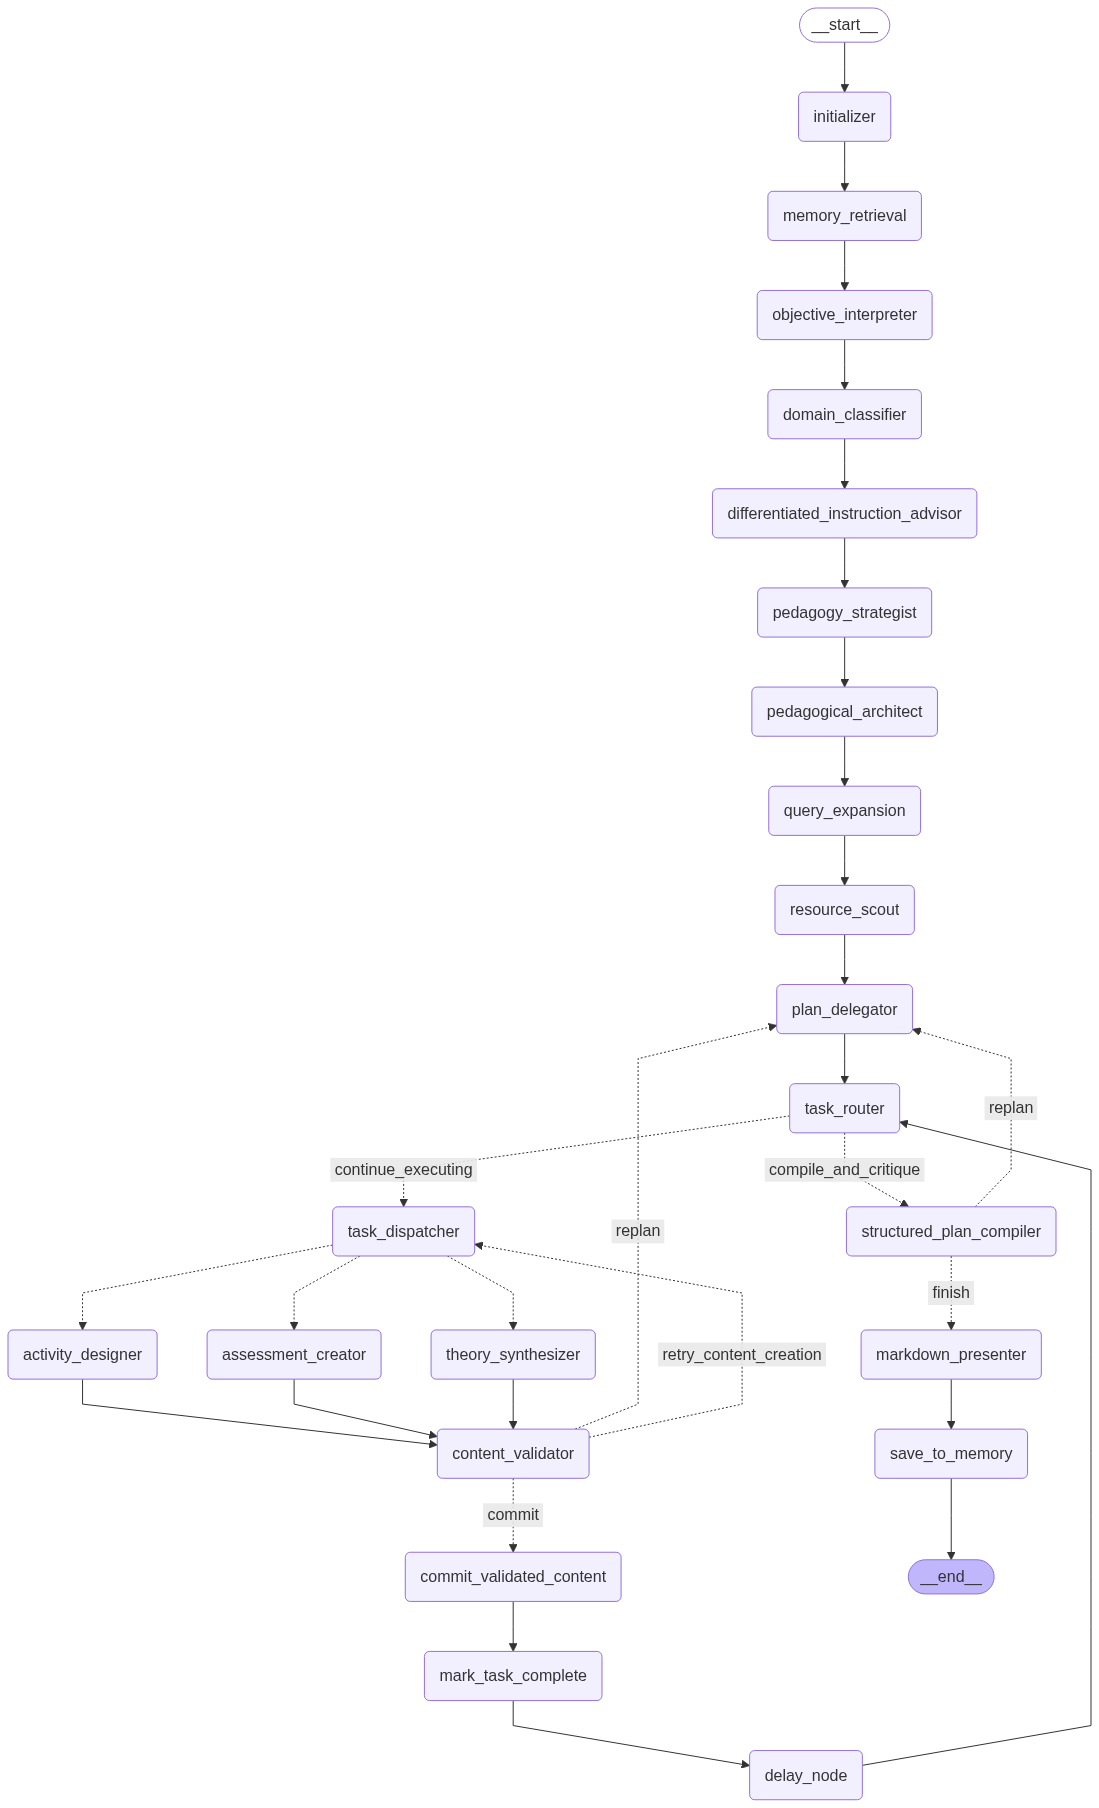

In [17]:
# ==============================================================================
# CELL 4.4: HI·ªÇN TH·ªä S∆† ƒê·ªí GRAPH (T√ôY CH·ªåN)
# ==============================================================================
try:
    # L·ªánh n√†y s·∫Ω v·∫Ω m·ªôt s∆° ƒë·ªì c·ªßa workflow, r·∫•t h·ªØu √≠ch ƒë·ªÉ g·ª° l·ªói
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"L·ªói v·∫Ω bi·ªÉu ƒë·ªì: {e}. ƒê√¢y l√† l·ªói kh√¥ng nghi√™m tr·ªçng, b·∫°n v·∫´n c√≥ th·ªÉ ch·∫°y quy tr√¨nh.")

## PH·∫¶N 5

In [18]:
# ==============================================================================
# CELL 5.1: ƒê·ªäNH NGHƒ®A H√ÄM CH·∫†Y QUY TR√åNH (v12.0 - HO√ÄN THI·ªÜN)
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM ch∆∞a ƒë∆∞·ª£c kh·ªüi t·∫°o.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri th·ª©c ch∆∞a ƒë∆∞·ª£c t·∫£i.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' ch∆∞a ƒë∆∞·ª£c bi√™n d·ªãch.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]üöÄ B·∫ÆT ƒê·∫¶U QUY TR√åNH V12.0 (HO√ÄN THI·ªÜN) V·ªöI Y√äU C·∫¶U:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_markdown_plan = None
    final_structured_plan = None
    
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Ho√†n th√†nh b∆∞·ªõc: {node_name} -------[/bold yellow]")
                if node_name == "markdown_presenter":
                    final_markdown_plan = node_output.get("final_markdown_plan")
                    final_structured_plan = node_output.get("final_structured_plan")

        console.print("\n[bold magenta]üèÅ K·∫æT TH√öC QUY TR√åNH.[/bold magenta]")
        
        if final_markdown_plan:
            console.print("\n[bold green]üìù GI√ÅO √ÅN HO√ÄN CH·ªàNH (v12.0)[/bold green]")
            console.print(Markdown(final_markdown_plan))
            
            if VERBOSE_MODE and final_structured_plan:
                print_result(final_structured_plan, "Output JSON c√≥ c·∫•u tr√∫c")
        else:
            print_warning("Kh√¥ng t·∫°o ƒë∆∞·ª£c gi√°o √°n cu·ªëi c√πng. Vui l√≤ng ki·ªÉm tra log ƒë·ªÉ g·ª° l·ªói.")
            
    except Exception as e:
        print_warning(f"ƒê√£ x·∫£y ra l·ªói nghi√™m tr·ªçng trong qu√° tr√¨nh ch·∫°y graph: {e}")
        import traceback
        traceback.print_exc()

print("‚úÖ H√†m `run_architect` (v12.0) ƒë√£ s·∫µn s√†ng ƒë·ªÉ s·ª≠ d·ª•ng.")

‚úÖ H√†m `run_architect` (v12.0) ƒë√£ s·∫µn s√†ng ƒë·ªÉ s·ª≠ d·ª•ng.


In [ ]:
# ==============================================================================
# CELL 5.2: K√çCH HO·∫†T CH·∫†Y TH·ª¨ NGHI·ªÜM
# ==============================================================================
# Y√™u c·∫ßu ƒë·ªÉ ki·ªÉm tra
architect_request = "So·∫°n gi√∫p t√¥i gi√°o √°n b√†i 'ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp' cho h·ªçc sinh l·ªõp 9 trong 90 ph√∫t. ƒê√¢y l√† m·ªôt l·ªõp h·ªçc kh√° y·∫øu, c√°c em th∆∞·ªùng m·∫•t t·∫≠p trung v√† c·∫ßn c√°c ho·∫°t ƒë·ªông c√≥ t√≠nh t∆∞∆°ng t√°c cao."
VERBOSE_MODE = True 

# Ch·∫°y quy tr√¨nh ƒë√£ ƒë∆∞·ª£c c·∫£i c√°ch
# L∆∞u √Ω: b·∫°n c·∫ßn m·ªôt m√¥i tr∆∞·ªùng h·ªó tr·ª£ `await` ·ªü c·∫•p ƒë·ªô cao nh·∫•t (nh∆∞ Jupyter Notebook)
await run_architect(architect_request)

üöÄ B·∫ÆT ƒê·∫¶U QUY TR√åNH V12.0 (HO√ÄN THI·ªÜN) V·ªöI Y√äU C·∫¶U:
> So·∫°n gi√∫p t√¥i gi√°o √°n b√†i 'ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp' cho h·ªçc sinh l·ªõp 9 trong 90 ph√∫t. ƒê√¢y l√†
m·ªôt l·ªõp h·ªçc kh√° y·∫øu, c√°c em th∆∞·ªùng m·∫•t t·∫≠p trung v√† c·∫ßn c√°c ho·∫°t ƒë·ªông c√≥ t√≠nh t∆∞∆°ng t√°c cao.

> `Initializer`: ƒêang kh·ªüi t·∫°o tr·∫°ng th√°i v√† l·∫•y y√™u c·∫ßu g·ªëc...

------- Ho√†n th√†nh b∆∞·ªõc: initializer -------

> `Agent: Memory Retrieval` (v9.4) ƒëang t√¨m ki·∫øm trong tr√≠ nh·ªõ...

‚úîÔ∏è T√¨m th·∫•y v√≠ d·ª• t∆∞∆°ng ƒë·ªìng trong tr√≠ nh·ªõ:

"So·∫°n gi√∫p t√¥i gi√°o √°n b√†i 'ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp' cho h·ªçc sinh l·ªõp 9 trong 90 ph√∫t. ƒê√¢y l√† m·ªôt l·ªõp h·ªçc kh√° y·∫øu, c√°c em th∆∞·ªùng m·∫•t t·∫≠p trung v√† c·∫ßn c√°c ho·∫°t ƒë·ªông c√≥ t√≠nh t∆∞∆°ng t√°c cao."

------- Ho√†n th√†nh b∆∞·ªõc: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) ƒëang ph√¢n t√≠ch m·ª•c ti√™u...

‚úîÔ∏è M·ª•c ti√™u & R√†ng bu·ªôc ƒë√£ ph√¢n t√≠ch:

{
‚îÇ   'action_verb': 'So·∫°n',
‚îÇ   'bloom_level': 2,
‚îÇ   'topic': 'ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp',
‚îÇ   'grade_level': 'L·ªõp 9',
‚îÇ   'constraints': {
‚îÇ   ‚îÇ   'duration_minutes': 90
‚îÇ   }
}

------- Ho√†n th√†nh b∆∞·ªõc: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) ƒëang x√°c ƒë·ªãnh lƒ©nh v·ª±c chuy√™n m√¥n...

‚úîÔ∏è Lƒ©nh v·ª±c chuy√™n m√¥n ƒë∆∞·ª£c x√°c ƒë·ªãnh:

'To√°n h·ªçc'

------- Ho√†n th√†nh b∆∞·ªõc: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) ƒëang ph√¢n t√≠ch v√† ƒë·ªÅ xu·∫•t chi·∫øn l∆∞·ª£c ph√¢n h√≥a...

‚úîÔ∏è H·ªì s∆° l·ªõp h·ªçc v√† Chi·∫øn l∆∞·ª£c Ph√¢n h√≥a:

{
‚îÇ   'learning_pace': 'ch·∫≠m',
‚îÇ   'engagement_style': 'th·ª• ƒë·ªông',
‚îÇ   'special_notes': 'L·ªõp h·ªçc c√≥ t·ªëc ƒë·ªô ti·∫øp thu ch·∫≠m, h·ªçc sinh d·ªÖ m·∫•t t·∫≠p trung v√† c·∫ßn c√°c ho·∫°t ƒë·ªông t∆∞∆°ng t√°c cao ƒë·ªÉ duy tr√¨ s·ª± ch√∫ √Ω v√† h·ª©ng th√∫.',
‚îÇ   'differentiation_strategy': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Chia nh·ªè ki·∫øn th·ª©c th√†nh c√°c ph·∫ßn d·ªÖ ti·∫øp thu, s·ª≠ d·ª•ng nhi·ªÅu h√¨nh ·∫£nh tr·ª±c quan v√† m√¥ h√¨nh. Cung c·∫•p phi·∫øu b√†i t·∫≠p c√≥ g·ª£i √Ω, v√≠ d·ª• minh h·ªça chi ti·∫øt. TƒÉng c∆∞·ªùng ki·ªÉm tra, h·ªó tr·ª£ c√° nh√¢n ho·∫∑c nh√≥m nh·ªè th∆∞·ªùng xuy√™n, khuy·∫øn kh√≠ch ƒë·∫∑t c√¢u h·ªèi v√† nh·∫Øc l·∫°i ki·∫øn th·ª©c c∆° b·∫£n.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Cung c·∫•p c√°c b√†i t·∫≠p n√¢ng cao, y√™u c·∫ßu ch·ª©ng minh ho·∫∑c gi·∫£i th√≠ch s√¢u h∆°n v·ªÅ c√°c t√≠nh ch·∫•t. Khuy·∫øn kh√≠ch t√¨m ki·∫øm ·ª©ng d·ª•ng th·ª±c t·∫ø ho·∫∑c m·ªü r·ªông b√†i to√°n. Giao nhi·ªám v·ª• h∆∞·ªõng d·∫´n, h·ªó tr·ª£ c√°c b·∫°n trong nh√≥m khi c·∫ßn thi·∫øt, t·∫°o c∆° h·ªôi cho c√°c em t·ª± kh√°m ph√° v√† tr√¨nh b√†y.'
‚îÇ   }
}

------- Ho√†n th√†nh b∆∞·ªõc: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) ƒëang x√¢y d·ª±ng chi·∫øn l∆∞·ª£c s∆∞ ph·∫°m chi ti·∫øt...

‚úîÔ∏è Chi·∫øn l∆∞·ª£c s∆∞ ph·∫°m chi ti·∫øt:

{
‚îÇ   'name': 'D·∫°y h·ªçc h·ª£p t√°c k·∫øt h·ª£p ph∆∞∆°ng ph√°p tr·ª±c quan v√† kh√°m ph√° c√≥ h∆∞·ªõng d·∫´n',
‚îÇ   'rationale': 'Ph∆∞∆°ng ph√°p n√†y ƒë·∫∑c bi·ªát ph√π h·ª£p v·ªõi l·ªõp h·ªçc c√≥ t·ªëc ƒë·ªô ti·∫øp thu ch·∫≠m v√† h·ªçc sinh th·ª• ƒë·ªông v√¨ n√≥ khuy·∫øn kh√≠ch s·ª± t∆∞∆°ng t√°c cao v√† h·ªó tr·ª£ l·∫´n nhau gi·ªØa c√°c th√†nh vi√™n trong nh√≥m. Vi·ªác chia nh·ªè ki·∫øn th·ª©c th√†nh c√°c nhi·ªám v·ª• c·ª• th·ªÉ tr√™n phi·∫øu h·ªçc t·∫≠p, k·∫øt h·ª£p v·ªõi c√°c ho·∫°t ƒë·ªông tr·ª±c quan (v·∫Ω h√¨nh, s·ª≠ d·ª•ng m√¥ h√¨nh) v√† kh√°m ph√° c√≥ h∆∞·ªõng d·∫´n, gi√∫p h·ªçc sinh d·ªÖ d√†ng ti·∫øp c·∫≠n v√† x√¢y d·ª±ng ki·∫øn th·ª©c m·ªôt c√°ch ch·ªß ƒë·ªông. H·ªçc sinh y·∫øu ƒë∆∞·ª£c b·∫°n b√® v√† gi√°o vi√™n h·ªó tr·ª£ k·ªãp th·ªùi, trong khi h·ªçc sinh kh√° gi·ªèi c√≥ c∆° h·ªôi ph√°t huy nƒÉng l·ª±c, h∆∞·ªõng d·∫´n b·∫°n v√† gi·∫£i quy·∫øt c√°c b√†i t·∫≠p n√¢ng cao. ƒêi·ªÅu n√†y gi√∫p duy tr√¨ s·ª± ch√∫ √Ω v√† h·ª©ng th√∫ c·ªßa h·ªçc sinh trong su·ªët 90 ph√∫t h·ªçc.',
‚îÇ   'key_actions': [
‚îÇ   ‚îÇ   'Kh·ªüi ƒë·ªông v√† ƒë·∫∑t v·∫•n ƒë·ªÅ, t·∫°o t√¨nh hu·ªëng h·ªçc t·∫≠p c√≥ v·∫•n ƒë·ªÅ.',
‚îÇ   ‚îÇ   'Chia l·ªõp th√†nh c√°c nh√≥m nh·ªè, giao phi·∫øu h·ªçc t·∫≠p v·ªõi nhi·ªám v·ª• kh√°m ph√° c√≥ h∆∞·ªõng d·∫´n v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† n·ªôi ti·∫øp.',
‚îÇ   ‚îÇ   'H·ªçc sinh l√†m vi·ªác nh√≥m, s·ª≠ d·ª•ng c√°c d·ª•ng c·ª• h·ªçc t·∫≠p (compa, th∆∞·ªõc, gi·∫•y) v√† t√†i li·ªáu tr·ª±c quan ƒë·ªÉ th·ª±c hi·ªán c√°c ho·∫°t ƒë·ªông v·∫Ω, quan s√°t, th·∫£o lu·∫≠n v√† r√∫t ra k·∫øt lu·∫≠n.',
‚îÇ   ‚îÇ   'Gi√°o vi√™n quan s√°t, h·ªó tr·ª£ t·ª´ng nh√≥m, gi·∫£i ƒë√°p th·∫Øc m·∫Øc, g·ª£i √Ω cho h·ªçc sinh y·∫øu v√† khuy·∫øn kh√≠ch h·ªçc sinh kh√° gi·ªèi m·ªü r·ªông v·∫•n ƒë·ªÅ.',
‚îÇ   ‚îÇ   'ƒê·∫°i di·ªán c√°c nh√≥m tr√¨nh b√†y k·∫øt qu·∫£ kh√°m ph√° v√† chia s·∫ª ki·∫øn th·ª©c v·ªõi c·∫£ l·ªõp.',
‚îÇ   ‚îÇ   'Gi√°o vi√™n t·ªïng k·∫øt, chu·∫©n h√≥a ki·∫øn th·ª©c tr·ªçng t√¢m (ƒë·ªãnh nghƒ©a, t√≠nh ch·∫•t, c√°ch x√°c ƒë·ªãnh t√¢m v√† b√°n k√≠nh c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp/n·ªôi ti·∫øp).',
‚îÇ   ‚îÇ   'C·ªßng c·ªë ki·∫øn th·ª©c b·∫±ng c√°c b√†i t·∫≠p v·∫≠n d·ª•ng c∆° b·∫£n v√† n√¢ng cao, c√≥ s·ª± ph√¢n h√≥a r√µ r·ªát cho t·ª´ng ƒë·ªëi t∆∞·ª£ng h·ªçc sinh.',
‚îÇ   ‚îÇ   'ƒê√°nh gi√° nhanh m·ª©c ƒë·ªô hi·ªÉu b√†i v√† giao nhi·ªám v·ª• v·ªÅ nh√†.'
‚îÇ   ]
}

------- Ho√†n th√†nh b∆∞·ªõc: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) ƒëang thi·∫øt k·∫ø k·ªãch b·∫£n bu·ªïi h·ªçc...

‚úîÔ∏è B·∫£n thi·∫øt k·∫ø S∆∞ ph·∫°m ƒë√£ ƒë∆∞·ª£c t·∫°o:

[
‚îÇ   'Kh·ªüi ƒë·ªông v√† T·∫°o t√¨nh hu·ªëng: Gi√°o vi√™n s·ª≠ d·ª•ng c√°c h√¨nh ·∫£nh/v·∫≠t th·ªÉ quen thu·ªôc trong ƒë·ªùi s·ªëng c√≥ ch·ª©a h√¨nh ·∫£nh ƒë∆∞·ªùng tr√≤n v√† tam gi√°c (v√≠ d·ª•: logo, ki·∫øn tr√∫c, ƒë·ªì v·∫≠t), ƒë·∫∑t c√¢u h·ªèi g·ª£i m·ªü ƒë·ªÉ h·ªçc sinh li√™n h·ªá v√† suy nghƒ© v·ªÅ c√°c kh√°i ni·ªám c∆° b·∫£n, t·ª´ ƒë√≥ d·∫´n d·∫Øt ƒë·∫øn nhu c·∫ßu t√¨m hi·ªÉu v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† n·ªôi ti·∫øp.',
‚îÇ   'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp: Chia l·ªõp th√†nh c√°c nh√≥m nh·ªè. Ph√°t phi·∫øu h·ªçc t·∫≠p c√≥ h∆∞·ªõng d·∫´n chi ti·∫øt c√°c b∆∞·ªõc v·∫Ω tam gi√°c, v·∫Ω ƒë∆∞·ªùng trung tr·ª±c, x√°c ƒë·ªãnh giao ƒëi·ªÉm v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ƒëi qua 3 ƒë·ªânh. H·ªçc sinh th·ª±c h√†nh v·ªõi compa, th∆∞·ªõc, gi·∫•y. Gi√°o vi√™n quan s√°t, h·ªó tr·ª£ nh√≥m y·∫øu, ƒë·∫∑t c√¢u h·ªèi g·ª£i m·ªü cho nh√≥m kh√° gi·ªèi.',
‚îÇ   'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n n·ªôi ti·∫øp: T∆∞∆°ng t·ª± giai ƒëo·∫°n 2, nh∆∞ng t·∫≠p trung v√†o ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp. H·ªçc sinh th·ª±c h√†nh v·∫Ω tam gi√°c, v·∫Ω ƒë∆∞·ªùng ph√¢n gi√°c, x√°c ƒë·ªãnh giao ƒëi·ªÉm v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ti·∫øp x√∫c v·ªõi 3 c·∫°nh. Gi√°o vi√™n ti·∫øp t·ª•c h·ªó tr·ª£, khuy·∫øn kh√≠ch h·ªçc sinh kh√° gi·ªèi gi·∫£i th√≠ch s√¢u h∆°n v·ªÅ t√≠nh ch·∫•t.',
‚îÇ   'V·∫≠n d·ª•ng v√† Luy·ªán t·∫≠p: Gi√°o vi√™n cung c·∫•p c√°c d·∫°ng b√†i t·∫≠p ƒëa d·∫°ng (nh·∫≠n bi·∫øt, t√≠nh to√°n, ch·ª©ng minh) tr√™n phi·∫øu b√†i t·∫≠p c√≥ ph√¢n h√≥a. H·ªçc sinh l√†m vi·ªác c√° nh√¢n ho·∫∑c theo c·∫∑p. Gi√°o vi√™n ƒëi l·∫°i quan s√°t, h·ªó tr·ª£ k·ªãp th·ªùi cho h·ªçc sinh y·∫øu, khuy·∫øn kh√≠ch h·ªçc sinh kh√° gi·ªèi th·ª≠ s·ª©c v·ªõi c√°c b√†i t·∫≠p kh√≥ h∆°n ho·∫∑c t√¨m c√°ch gi·∫£i kh√°c.',
‚îÇ   'T·ªïng k·∫øt v√† M·ªü r·ªông: Gi√°o vi√™n t·ªï ch·ª©c cho h·ªçc sinh c√πng nhau t√≥m t·∫Øt c√°c kh√°i ni·ªám, t√≠nh ch·∫•t quan tr·ªçng ƒë√£ h·ªçc. Gi√°o vi√™n ch·ªët l·∫°i ki·∫øn th·ª©c, nh·∫•n m·∫°nh c√°c ƒëi·ªÉm c·∫ßn l∆∞u √Ω. C√≥ th·ªÉ ƒë·∫∑t m·ªôt c√¢u h·ªèi m·ªü r·ªông ho·∫∑c giao nhi·ªám v·ª• v·ªÅ nh√† li√™n quan ƒë·∫øn ·ª©ng d·ª•ng th·ª±c t·∫ø c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp/n·ªôi ti·∫øp.'
]

------- Ho√†n th√†nh b∆∞·ªõc: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) ƒëang ph√¢n t√≠ch y√™u c·∫ßu...

‚úîÔ∏è C√°c truy v·∫•n t√¨m ki·∫øm ƒë√£ ƒë∆∞·ª£c m·ªü r·ªông:

[
‚îÇ   'ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l√† g√¨',
‚îÇ   'ƒê∆∞·ªùng tr√≤n n·ªôi ti·∫øp l√† g√¨',
‚îÇ   'C√¥ng th·ª©c t√≠nh b√°n k√≠nh ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c',
‚îÇ   'C√¥ng th·ª©c t√≠nh b√°n k√≠nh ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp tam gi√°c',
‚îÇ   'T√≠nh ch·∫•t ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† n·ªôi ti·∫øp',
‚îÇ   'B√†i t·∫≠p ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp n·ªôi ti·∫øp l·ªõp 9',
‚îÇ   'Chuy√™n ƒë·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp n·ªôi ti·∫øp h√¨nh h·ªçc',
‚îÇ   'C√°ch v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c',
‚îÇ   'C√°ch v·∫Ω ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp tam gi√°c',
‚îÇ   'ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp t·ª© gi√°c n·ªôi ti·∫øp',
‚îÇ   'ƒê∆∞·ªùng tr√≤n n·ªôi ti·∫øp t·ª© gi√°c',
‚îÇ   'L√Ω thuy·∫øt ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† n·ªôi ti·∫øp',
‚îÇ   '·ª®ng d·ª•ng ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp n·ªôi ti·∫øp',
‚îÇ   'ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒëa gi√°c ƒë·ªÅu',
‚îÇ   'ƒê∆∞·ªùng tr√≤n n·ªôi ti·∫øp ƒëa gi√°c ƒë·ªÅu',
‚îÇ   'V√≠ d·ª• v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp n·ªôi ti·∫øp c√≥ l·ªùi gi·∫£i',
‚îÇ   'B√†i t·∫≠p n√¢ng cao ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp n·ªôi ti·∫øp',
‚îÇ   'Quan h·ªá gi·ªØa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† n·ªôi ti·∫øp tam gi√°c'
]

------- Ho√†n th√†nh b∆∞·ªõc: query_expansion -------

> `Agent: Resource Scout` (v8.1 - S·ª≠a l·ªói) ƒëang t√¨m ki·∫øm v√† s√†ng l·ªçc...

> T√¨m th·∫•y 90 t√†i li·ªáu, s√†ng l·ªçc c√≤n 8 ƒëo·∫°n vƒÉn b·∫£n ƒë·ªôc nh·∫•t.

‚úîÔ∏è T√†i li·ªáu RAG cu·ªëi c√πng:

{
‚îÇ   'source': 'S√°ch gi√°o khoa (t·ª´ RAG - ƒë√£ s√†ng l·ªçc)',
‚îÇ   'summary': 'Ch√†o c√°c em,\n\nV·ªõi vai tr√≤ l√† m·ªôt gi√°o vi√™n gi√†u kinh nghi·ªám, th·∫ßy s·∫Ω gi√∫p c√°c em t·ªïng h·ª£p ki·∫øn th·ª©c c·ªët l√µi v·ªÅ ch·ªß ƒë·ªÅ "ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp" d·ª±a tr√™n c√°c ƒëo·∫°n vƒÉn b·∫£n ƒë√£ cho. C√°c em l∆∞u √Ω, th·∫ßy ch·ªâ s·ª≠ d·ª•ng th√¥ng tin c√≥ s·∫µn trong t√†i li·ªáu ƒë·ªÉ t√≥m t·∫Øt nh√©.\n\n---\n\n**T√ìM T·∫ÆT KI·∫æN TH·ª®C C·ªêT L√ïI V·ªÄ CH·ª¶ ƒê·ªÄ "ƒê∆Ø·ªúNG TR√íN NGO·∫†I TI·∫æP V√Ä ƒê∆Ø·ªúNG TR√íN N·ªòI TI·∫æP"**\n\n1.  **ƒê∆∞·ªùng tr√≤n ƒëi qua c√°c ƒë·ªânh c·ªßa ƒëa gi√°c (Kh√°i ni·ªám li√™n quan ƒë·∫øn "ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp")**\n    *   **ƒê·ªãnh nghƒ©a (Suy lu·∫≠n t·ª´ c√°c v√≠ d·ª•):** M·ªôt ƒë∆∞·ªùng tr√≤n c√≥ th·ªÉ ƒëi qua t·∫•t c·∫£ c√°c ƒë·ªânh c·ªßa m·ªôt s·ªë ƒëa gi√°c nh·∫•t ƒë·ªãnh.\n    *   **ƒê·ªëi v·ªõi tam gi√°c vu√¥ng:**\n        *   C√°c ƒëi·ªÉm A, B, C c·ªßa m·ªôt tam gi√°c vu√¥ng t·∫°i A thu·ªôc c√πng m·ªôt ƒë∆∞·ªùng tr√≤n.\n        *   ƒê∆∞·ªùng tr√≤n n√†y c√≥ ƒë∆∞·ªùng k√≠nh l√† c·∫°nh huy·ªÅn c·ªßa tam gi√°c vu√¥ng (v√≠ d·ª•: BC).\n        *   Ng∆∞·ª£c l·∫°i, n·∫øu m·ªôt tam gi√°c c√≥ m·ªôt c·∫°nh l√† ƒë∆∞·ªùng k√≠nh c·ªßa ƒë∆∞·ªùng tr√≤n v√† ƒë·ªânh c√≤n l·∫°i n·∫±m tr√™n ƒë∆∞·ªùng tr√≤n ƒë√≥, th√¨ tam gi√°c ƒë√≥ l√† tam gi√°c vu√¥ng.\n    *   **ƒê·ªëi v·ªõi h√¨nh vu√¥ng:**\n        *   C√≥ m·ªôt ƒë∆∞·ªùng tr√≤n ƒëi qua b·ªën ƒë·ªânh c·ªßa h√¨nh vu√¥ng.\n        *   T√¢m c·ªßa ƒë∆∞·ªùng tr√≤n n√†y l√† giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng ch√©o c·ªßa h√¨nh vu√¥ng.\n        *   T√¢m n√†y c≈©ng l√† t√¢m ƒë·ªëi x·ª©ng c·ªßa ƒë∆∞·ªùng tr√≤n.\n        *   ƒê∆∞·ªùng tr√≤n n√†y c√≥ hai tr·ª•c ƒë·ªëi x·ª©ng.\n\n2.  **ƒê∆∞·ªùng tr√≤n n·ªôi ti·∫øp**\n    *   *Trong c√°c ƒëo·∫°n vƒÉn b·∫£n ƒë∆∞·ª£c cung c·∫•p, kh√¥ng c√≥ th√¥ng tin n√†o ƒë·ªÉ ƒë·ªãnh nghƒ©a ho·∫∑c m√¥ t·∫£ v·ªÅ ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp.*\n\n3.  **C√°c kh√°i ni·ªám v√† t√≠nh ch·∫•t chung v·ªÅ ƒë∆∞·ªùng tr√≤n**\n    *   **X√°c ƒë·ªãnh t√¢m ƒë∆∞·ªùng tr√≤n:** C√≥ th·ªÉ t√¨m t√¢m c·ªßa m·ªôt h√¨nh tr√≤n b·∫±ng c√°ch g·∫•p ƒë√¥i m·∫£nh gi·∫•y h√¨nh tr√≤n theo hai c√°ch kh√°c nhau.\n    *   **Tr·ª•c ƒë·ªëi x·ª©ng c·ªßa ƒë∆∞·ªùng tr√≤n:** ƒê∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt ƒëo·∫°n th·∫≥ng n·ªëi hai ƒëi·ªÉm b·∫•t k·ª≥ thu·ªôc ƒë∆∞·ªùng tr√≤n l√† m·ªôt tr·ª•c ƒë·ªëi x·ª©ng c·ªßa ƒë∆∞·ªùng tr√≤n ƒë√≥.\n    *   **V·ªã tr√≠ c·ªßa m·ªôt ƒëi·ªÉm ƒë·ªëi v·ªõi ƒë∆∞·ªùng tr√≤n (O; R):**\n        *   ƒêi·ªÉm n·∫±m **tr√™n** ƒë∆∞·ªùng tr√≤n n·∫øu kho·∫£ng c√°ch t·ª´ t√¢m O ƒë·∫øn ƒëi·ªÉm ƒë√≥ b·∫±ng b√°n k√≠nh R.\n        *   ƒêi·ªÉm n·∫±m **trong** ƒë∆∞·ªùng tr√≤n n·∫øu kho·∫£ng c√°ch t·ª´ t√¢m O ƒë·∫øn ƒëi·ªÉm ƒë√≥ nh·ªè h∆°n b√°n k√≠nh R.\n        *   ƒêi·ªÉm n·∫±m **ngo√†i** ƒë∆∞·ªùng tr√≤n n·∫øu kho·∫£ng c√°ch t·ª´ t√¢m O ƒë·∫øn ƒëi·ªÉm ƒë√≥ l·ªõn h∆°n b√°n k√≠nh R.\n    *   **V·ªã tr√≠ t∆∞∆°ng ƒë·ªëi c·ªßa hai ƒë∆∞·ªùng tr√≤n (O; R) v√† (O\'; R\'):**\n        *   **Ti·∫øp x√∫c ngo√†i:** Khi kho·∫£ng c√°ch gi·ªØa hai t√¢m b·∫±ng t·ªïng hai b√°n k√≠nh ($OO\' = R + R\'$).\n        *   **Kh√¥ng giao nhau:**\n            *   **·ªû ngo√†i nhau:** Khi kho·∫£ng c√°ch gi·ªØa hai t√¢m l·ªõn h∆°n t·ªïng hai b√°n k√≠nh ($OO\' > R + R\'$).\n            *   **ƒê·ª±ng nhau:** Khi kho·∫£ng c√°ch gi·ªØa hai t√¢m nh·ªè h∆°n hi·ªáu hai b√°n k√≠nh ($OO\' < R - R\'$).\n            *   **ƒê·ªìng t√¢m:** Khi hai t√¢m tr√πng nhau ($O \\equiv O\'$) v√† b√°n k√≠nh kh√°c nhau ($R \\neq R\'$).\n    *   **Ti·∫øp tuy·∫øn:** M·ªôt ƒë∆∞·ªùng th·∫≥ng c√≥ th·ªÉ l√† ti·∫øp tuy·∫øn c·ªßa m·ªôt ƒë∆∞·ªùng tr√≤n (v√≠ d·ª•: BA l√† ti·∫øp tuy·∫øn c·ªßa ƒë∆∞·ªùng tr√≤n (C; CA)).\n\n---\nHy v·ªçng b·∫£n t√≥m t·∫Øt n√†y gi√∫p c√°c em n·∫Øm v·ªØng ki·∫øn th·ª©c t·ª´ c√°c b√†i h·ªçc ƒë√£ cho.'
}

------- Ho√†n th√†nh b∆∞·ªõc: resource_scout -------

> `Agent: Plan Delegator` (v12.0 - Nh√† ho·∫°ch ƒë·ªãnh Th√¥ng th√°i) ƒëang tri·ªÉn khai...

‚úîÔ∏è ƒê√£ t·∫°o 5 nhi·ªám v·ª• chi ti·∫øt:

[
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 0,
‚îÇ   ‚îÇ   'task_name': 'Kh·ªüi ƒë·ªông v√† T·∫°o t√¨nh hu·ªëng',
‚îÇ   ‚îÇ   'task_description': 'Gi√°o vi√™n s·ª≠ d·ª•ng c√°c h√¨nh ·∫£nh/v·∫≠t th·ªÉ quen thu·ªôc trong ƒë·ªùi s·ªëng c√≥ ch·ª©a h√¨nh ·∫£nh ƒë∆∞·ªùng tr√≤n v√† tam gi√°c (v√≠ d·ª•: logo, ki·∫øn tr√∫c, ƒë·ªì v·∫≠t), ƒë·∫∑t c√¢u h·ªèi g·ª£i m·ªü ƒë·ªÉ h·ªçc sinh li√™n h·ªá v√† suy nghƒ© v·ªÅ c√°c kh√°i ni·ªám c∆° b·∫£n, t·ª´ ƒë√≥ d·∫´n d·∫Øt ƒë·∫øn nhu c·∫ßu t√¨m hi·ªÉu v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† n·ªôi ti·∫øp.',
‚îÇ   ‚îÇ   'estimated_duration': 10,
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   },
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 1,
‚îÇ   ‚îÇ   'task_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   ‚îÇ   'task_description': 'Chia l·ªõp th√†nh c√°c nh√≥m nh·ªè. Ph√°t phi·∫øu h·ªçc t·∫≠p c√≥ h∆∞·ªõng d·∫´n chi ti·∫øt c√°c b∆∞·ªõc v·∫Ω tam gi√°c, v·∫Ω ƒë∆∞·ªùng trung tr·ª±c, x√°c ƒë·ªãnh giao ƒëi·ªÉm v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ƒëi qua 3 ƒë·ªânh. H·ªçc sinh th·ª±c h√†nh v·ªõi compa, th∆∞·ªõc, gi·∫•y. Gi√°o vi√™n quan s√°t, h·ªó tr·ª£ nh√≥m y·∫øu, ƒë·∫∑t c√¢u h·ªèi g·ª£i m·ªü cho nh√≥m kh√° gi·ªèi.',
‚îÇ   ‚îÇ   'estimated_duration': 25,
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   },
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 2,
‚îÇ   ‚îÇ   'task_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n n·ªôi ti·∫øp',
‚îÇ   ‚îÇ   'task_description': 'T∆∞∆°ng t·ª± giai ƒëo·∫°n kh√°m ph√° ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp, h·ªçc sinh th·ª±c h√†nh v·∫Ω tam gi√°c, v·∫Ω ƒë∆∞·ªùng ph√¢n gi√°c, x√°c ƒë·ªãnh giao ƒëi·ªÉm v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ti·∫øp x√∫c v·ªõi 3 c·∫°nh. Gi√°o vi√™n ti·∫øp t·ª•c h·ªó tr·ª£, khuy·∫øn kh√≠ch h·ªçc sinh kh√° gi·ªèi gi·∫£i th√≠ch s√¢u h∆°n v·ªÅ t√≠nh ch·∫•t.',
‚îÇ   ‚îÇ   'estimated_duration': 25,
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   },
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 3,
‚îÇ   ‚îÇ   'task_name': 'V·∫≠n d·ª•ng v√† Luy·ªán t·∫≠p',
‚îÇ   ‚îÇ   'task_description': 'Gi√°o vi√™n cung c·∫•p c√°c d·∫°ng b√†i t·∫≠p ƒëa d·∫°ng (nh·∫≠n bi·∫øt, t√≠nh to√°n, ch·ª©ng minh) tr√™n phi·∫øu b√†i t·∫≠p c√≥ ph√¢n h√≥a. H·ªçc sinh l√†m vi·ªác c√° nh√¢n ho·∫∑c theo c·∫∑p. Gi√°o vi√™n ƒëi l·∫°i quan s√°t, h·ªó tr·ª£ k·ªãp th·ªùi cho h·ªçc sinh y·∫øu, khuy·∫øn kh√≠ch h·ªçc sinh kh√° gi·ªèi th·ª≠ s·ª©c v·ªõi c√°c b√†i t·∫≠p kh√≥ h∆°n ho·∫∑c t√¨m c√°ch gi·∫£i kh√°c.',
‚îÇ   ‚îÇ   'estimated_duration': 20,
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   },
‚îÇ   {
‚îÇ   ‚îÇ   'task_id': 4,
‚îÇ   ‚îÇ   'task_name': 'T·ªïng k·∫øt v√† M·ªü r·ªông',
‚îÇ   ‚îÇ   'task_description': 'Gi√°o vi√™n t·ªï ch·ª©c cho h·ªçc sinh c√πng nhau t√≥m t·∫Øt c√°c kh√°i ni·ªám, t√≠nh ch·∫•t quan tr·ªçng ƒë√£ h·ªçc. Gi√°o vi√™n ch·ªët l·∫°i ki·∫øn th·ª©c, nh·∫•n m·∫°nh c√°c ƒëi·ªÉm c·∫ßn l∆∞u √Ω. C√≥ th·ªÉ ƒë·∫∑t m·ªôt c√¢u h·ªèi m·ªü r·ªông ho·∫∑c giao nhi·ªám v·ª• v·ªÅ nh√† li√™n quan ƒë·∫øn ·ª©ng d·ª•ng th·ª±c t·∫ø c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp/n·ªôi ti·∫øp.',
‚îÇ   ‚îÇ   'estimated_duration': 10,
‚îÇ   ‚îÇ   'status': 'pending'
‚îÇ   }
]

------- Ho√†n th√†nh b∆∞·ªõc: plan_delegator -------

> `Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...

> Nhi·ªám v·ª• ti·∫øp theo: 'Kh·ªüi ƒë·ªông v√† T·∫°o t√¨nh hu·ªëng' (ID: 0)

------- Ho√†n th√†nh b∆∞·ªõc: task_router -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh·ªüi ƒë·ªông v√† T·∫°o t√¨nh hu·ªëng',
‚îÇ   'duration_minutes': 10,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   "Tr√¨nh chi·∫øu h√¨nh ·∫£nh/video v√† ƒë∆∞a ra c√¢u h·ªèi g·ª£i m·ªü chung (v√≠ d·ª•: 'H√¨nh ·∫£nh/video n√†y g·ª£i cho em c·∫£m x√∫c g√¨? Em c√≥ suy nghƒ© g√¨ v·ªÅ ƒëi·ªÅu n√†y?').",
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n h·ªçc sinh suy nghƒ© c√° nh√¢n v√† th·∫£o lu·∫≠n nh√≥m theo th·ªùi gian quy ƒë·ªãnh.',
‚îÇ   ‚îÇ   'Quan s√°t, l·∫Øng nghe c√°c nh√≥m th·∫£o lu·∫≠n v√† h·ªó tr·ª£ khi c·∫ßn thi·∫øt (v√≠ d·ª•: g·ª£i √Ω c√¢u h·ªèi, khuy·∫øn kh√≠ch t·∫•t c·∫£ th√†nh vi√™n tham gia).',
‚îÇ   ‚îÇ   'M·ªùi ƒë·∫°i di·ªán c√°c nh√≥m chia s·∫ª v√† t·ªïng h·ª£p c√°c √Ω ki·∫øn ch√≠nh.',
‚îÇ   ‚îÇ   'D·∫´n d·∫Øt t·ª´ c√°c √Ω ki·∫øn c·ªßa h·ªçc sinh v√†o ch·ªß ƒë·ªÅ b√†i h·ªçc m·ªõi m·ªôt c√°ch t·ª± nhi√™n.'
‚îÇ   ],
‚îÇ   'core_component': 'Gi√°o vi√™n tr√¨nh chi·∫øu m·ªôt h√¨nh ·∫£nh ho·∫∑c video ng·∫Øn (kho·∫£ng 1-2 ph√∫t) li√™n quan ƒë·∫øn ch·ªß ƒë·ªÅ b√†i h·ªçc s·∫Øp t·ªõi. H·ªçc sinh suy nghƒ© c√° nh√¢n trong 2 ph√∫t v·ªÅ c·∫£m nh·∫≠n, suy nghƒ© ƒë·∫ßu ti√™n c·ªßa m√¨nh v·ªÅ h√¨nh ·∫£nh/video ƒë√≥. Sau ƒë√≥, h·ªçc sinh chia s·∫ª nhanh √Ω ki·∫øn trong nh√≥m 2-3 ng∆∞·ªùi trong 3 ph√∫t. Cu·ªëi c√πng, gi√°o vi√™n m·ªùi 2-3 ƒë·∫°i di·ªán nh√≥m chia s·∫ª √Ω ki·∫øn n·ªïi b·∫≠t tr∆∞·ªõc l·ªõp trong 3 ph√∫t.',
‚îÇ   'extension_component': 'ƒê·ªëi v·ªõi h·ªçc sinh ho√†n th√†nh nhanh ho·∫∑c c√≥ √Ω t∆∞·ªüng s√¢u s·∫Øc, y√™u c·∫ßu c√°c em ƒë·∫∑t m·ªôt c√¢u h·ªèi m·ªü r·ªông li√™n quan ƒë·∫øn h√¨nh ·∫£nh/video ho·∫∑c ƒë·ªÅ xu·∫•t m·ªôt gi·∫£i ph√°p ban ƒë·∫ßu cho v·∫•n ƒë·ªÅ ƒë∆∞·ª£c g·ª£i m·ªü, chu·∫©n b·ªã ƒë·ªÉ chia s·∫ª n·∫øu c√≤n th·ªùi gian.',
‚îÇ   'solution_guide': "Kh√¥ng c√≥ 'gi·∫£i ph√°p' c·ª• th·ªÉ cho ho·∫°t ƒë·ªông kh·ªüi ƒë·ªông n√†y, m·ª•c ti√™u l√† k√≠ch th√≠ch t∆∞ duy v√† t·∫°o t√¨nh hu·ªëng. Gi√°o vi√™n n√™n t·∫≠p trung v√†o vi·ªác l·∫Øng nghe v√† ghi nh·∫≠n c√°c √Ω ki·∫øn ƒëa d·∫°ng c·ªßa h·ªçc sinh. C√°c c√¢u h·ªèi g·ª£i m·ªü c√≥ th·ªÉ bao g·ªìm: 'H√¨nh ·∫£nh/video n√†y g·ª£i cho em c·∫£m x√∫c g√¨?', 'Em c√≥ suy nghƒ© g√¨ v·ªÅ ƒëi·ªÅu n√†y?', 'ƒêi·ªÅu n√†y c√≥ li√™n quan g√¨ ƒë·∫øn cu·ªôc s·ªëng c·ªßa ch√∫ng ta?', 'Theo em, v·∫•n ƒë·ªÅ n√†y c√≥ th·ªÉ ƒë∆∞·ª£c gi·∫£i quy·∫øt nh∆∞ th·∫ø n√†o?'",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': "Cung c·∫•p c√°c c√¢u h·ªèi g·ª£i √Ω c·ª• th·ªÉ h∆°n (v√≠ d·ª•: 'B·∫°n th·∫•y g√¨ trong h√¨nh?', 'H√¨nh ·∫£nh n√†y l√†m b·∫°n nghƒ© ƒë·∫øn ƒëi·ªÅu g√¨ trong cu·ªôc s·ªëng h√†ng ng√†y?'), cho ph√©p c√°c em ghi ch√∫ t·ª´ kh√≥a thay v√¨ c√¢u ho√†n ch·ªânh, ho·∫∑c gh√©p c·∫∑p v·ªõi b·∫°n h·ªçc t·ªët h∆°n ƒë·ªÉ nh·∫≠n h·ªó tr·ª£ v√† t·ª± tin chia s·∫ª.",
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu c√°c em ph√¢n t√≠ch s√¢u h∆°n v·ªÅ nguy√™n nh√¢n/h·∫≠u qu·∫£ c·ªßa v·∫•n ƒë·ªÅ trong h√¨nh ·∫£nh/video, ho·∫∑c li√™n h·ªá v·ªõi c√°c ki·∫øn th·ª©c ƒë√£ h·ªçc/s·ª± ki·ªán th·ª±c t·∫ø kh√°c. Khuy·∫øn kh√≠ch c√°c em ƒë·∫∑t c√¢u h·ªèi ph·∫£n bi·ªán ho·∫∑c ƒë·ªÅ xu·∫•t m·ªôt gi·∫£i ph√°p ban ƒë·∫ßu cho v·∫•n ƒë·ªÅ ƒë∆∞·ª£c g·ª£i m·ªü.'
‚îÇ   },
‚îÇ   'content_type': 'Th·∫£o lu·∫≠n nhanh v√† Chia s·∫ª'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y c√≥ v·∫ª h·ª£p l√Ω tr√™n l√Ω thuy·∫øt nh∆∞ng th·ªùi gian th·ª±c t·∫ø s·∫Ω v∆∞·ª£t
qu√° 10 ph√∫t. C·ª• th·ªÉ, vi·ªác m·ªùi 2-3 nh√≥m chia s·∫ª √Ω ki·∫øn v√† gi√°o vi√™n t·ªïng h·ª£p, d·∫´n d·∫Øt v√†o b√†i m·ªõi trong v·ªèn v·∫πn 3 
ph√∫t l√† kh√¥ng kh·∫£ thi. M·ªói nh√≥m c·∫ßn √≠t nh·∫•t 1 ph√∫t ƒë·ªÉ chia s·∫ª, ch∆∞a k·ªÉ th·ªùi gian chuy·ªÉn ti·∫øp v√† gi√°o vi√™n t·ªïng k·∫øt.
ƒê·ªÉ ƒë·∫£m b·∫£o ho·∫°t ƒë·ªông di·ªÖn ra trong 10 ph√∫t, h√£y gi·∫£m s·ªë l∆∞·ª£ng nh√≥m ƒë∆∞·ª£c m·ªùi chia s·∫ª tr∆∞·ªõc l·ªõp xu·ªëng c√≤n 1-2 nh√≥m, 
ho·∫∑c r√∫t ng·∫Øn th·ªùi gian chia s·∫ª c·ªßa m·ªói nh√≥m xu·ªëng c√≤n t·ªëi ƒëa 1 ph√∫t, ƒë·ªìng th·ªùi t·ªëi ∆∞u h√≥a th·ªùi gian gi√°o vi√™n t·ªïng
h·ª£p v√† d·∫´n d·∫Øt.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `theory_synthesizer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Theory Synthesizer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh·ªüi ƒë·ªông: "B·∫°n nghƒ© g√¨?"',
‚îÇ   'duration_minutes': 10,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu ho·∫°t ƒë·ªông v√† tr√¨nh b√†y r√µ c√¢u h·ªèi/t√¨nh hu·ªëng trong 1 ph√∫t.',
‚îÇ   ‚îÇ   'Quan s√°t, l·∫Øng nghe c√°c nh√≥m th·∫£o lu·∫≠n, s·∫µn s√†ng h·ªó tr·ª£ n·∫øu c·∫ßn (kh√¥ng can thi·ªáp s√¢u).',
‚îÇ   ‚îÇ   'Ch·ªçn ng·∫´u nhi√™n 1-2 nh√≥m ƒë·ªÉ chia s·∫ª, nh·∫Øc nh·ªü v·ªÅ gi·ªõi h·∫°n th·ªùi gian (1 ph√∫t/nh√≥m).',
‚îÇ   ‚îÇ   'T·ªïng h·ª£p nhanh c√°c √Ω ki·∫øn ch√≠nh, khen ng·ª£i s·ª± tham gia c·ªßa h·ªçc sinh.',
‚îÇ   ‚îÇ   'D·∫´n d·∫Øt, k·∫øt n·ªëi c√°c √Ω ki·∫øn c·ªßa h·ªçc sinh v·ªõi n·ªôi dung b√†i h·ªçc m·ªõi m·ªôt c√°ch ng·∫Øn g·ªçn, s√∫c t√≠ch (trong 2-3 ph√∫t cu·ªëi).',
‚îÇ   ‚îÇ   'ƒê·∫£m b·∫£o ho·∫°t ƒë·ªông di·ªÖn ra ƒë√∫ng 10 ph√∫t.'
‚îÇ   ],
‚îÇ   'core_component': "Gi√°o vi√™n tr√¨nh chi·∫øu m·ªôt h√¨nh ·∫£nh/video ng·∫Øn (kho·∫£ng 30 gi√¢y) ho·∫∑c ƒë∆∞a ra m·ªôt c√¢u h·ªèi/t√¨nh hu·ªëng g·ª£i m·ªü li√™n quan ƒë·∫øn ch·ªß ƒë·ªÅ b√†i h·ªçc m·ªõi. V√≠ d·ª•: 'H√£y chia s·∫ª m·ªôt h√†nh ƒë·ªông nh·ªè b·∫°n ƒë√£ l√†m ƒë·ªÉ gi√∫p ƒë·ª° ng∆∞·ªùi kh√°c ho·∫∑c c·ªông ƒë·ªìng trong tu·∫ßn qua.' ho·∫∑c 'Theo b·∫°n, ƒëi·ªÅu g√¨ l√† quan tr·ªçng nh·∫•t ƒë·ªÉ x√¢y d·ª±ng m·ªôt c·ªông ƒë·ªìng v·ªØng m·∫°nh?'. H·ªçc sinh th·∫£o lu·∫≠n nh√≥m (3-4 ph√∫t) ƒë·ªÉ ƒë∆∞a ra 1-2 √Ω ki·∫øn/h√†nh ƒë·ªông c·ª• th·ªÉ. Sau ƒë√≥, gi√°o vi√™n m·ªùi 1-2 nh√≥m ƒë·∫°i di·ªán chia s·∫ª nhanh (m·ªói nh√≥m t·ªëi ƒëa 1 ph√∫t).",
‚îÇ   'extension_component': "N·∫øu c√≤n th·ªùi gian ho·∫∑c c√≥ nh√≥m ho√†n th√†nh nhanh, gi√°o vi√™n c√≥ th·ªÉ ƒë·∫∑t th√™m c√¢u h·ªèi ph·ª•: 'N·∫øu c√≥ c∆° h·ªôi, b·∫°n mu·ªën th·ª±c hi·ªán h√†nh ƒë·ªông n√†o l·ªõn h∆°n ƒë·ªÉ t·∫°o ra s·ª± thay ƒë·ªïi t√≠ch c·ª±c?' ho·∫∑c 'B·∫°n s·∫Ω l√†m g√¨ ƒë·ªÉ khuy·∫øn kh√≠ch ng∆∞·ªùi kh√°c c√πng tham gia?'",
‚îÇ   'solution_guide': "Kh√¥ng c√≥ 'ƒë√°p √°n ƒë√∫ng' tuy·ªát ƒë·ªëi. M·ª•c ti√™u l√† kh∆°i g·ª£i t∆∞ duy v√† s·ª± li√™n h·ªá c√° nh√¢n. Gi√°o vi√™n n√™n t·∫≠p trung v√†o vi·ªác t·ªïng h·ª£p c√°c √Ω t∆∞·ªüng ƒëa d·∫°ng v√† d·∫´n d·∫Øt v√†o ch·ªß ƒë·ªÅ b√†i h·ªçc m·ªôt c√°ch t·ª± nhi√™n. C√°c c√¢u h·ªèi g·ª£i m·ªü c√≥ th·ªÉ l√†: 'T·∫°i sao √Ω ki·∫øn n√†y l·∫°i quan tr·ªçng?', 'ƒêi·ªÅu n√†y li√™n quan g√¨ ƒë·∫øn cu·ªôc s·ªëng c·ªßa ch√∫ng ta?'",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Gi√°o vi√™n c√≥ th·ªÉ g·ª£i √Ω c√°c t·ª´ kh√≥a ho·∫∑c v√≠ d·ª• ƒë∆°n gi·∫£n h∆°n ƒë·ªÉ c√°c em d·ªÖ h√¨nh dung v√† tham gia th·∫£o lu·∫≠n. Khuy·∫øn kh√≠ch c√°c em ch·ªâ c·∫ßn n√™u m·ªôt √Ω t∆∞·ªüng ƒë∆°n gi·∫£n nh·∫•t m√† m√¨nh nghƒ© ƒë·∫øn.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Khuy·∫øn kh√≠ch c√°c em kh√¥ng ch·ªâ n√™u √Ω t∆∞·ªüng m√† c√≤n gi·∫£i th√≠ch ng·∫Øn g·ªçn l√Ω do ho·∫∑c ƒë·ªÅ xu·∫•t gi·∫£i ph√°p (n·∫øu t√¨nh hu·ªëng cho ph√©p). C√≥ th·ªÉ y√™u c·∫ßu c√°c em suy nghƒ© v·ªÅ t√°c ƒë·ªông r·ªông h∆°n c·ªßa h√†nh ƒë·ªông/√Ω t∆∞·ªüng ƒë√≥.'
‚îÇ   },
‚îÇ   'content_type': 'Th·∫£o lu·∫≠n nh√≥m v√† Chia s·∫ª nhanh'
}

------- Ho√†n th√†nh b∆∞·ªõc: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y ƒë∆∞·ª£c thi·∫øt k·∫ø v·ªõi nhi·ªÅu b∆∞·ªõc, v√† khi c·ªông t·ªïng th·ªùi gian 
t·ªëi thi·ªÉu cho m·ªói b∆∞·ªõc (gi·ªõi thi·ªáu, tr√¨nh chi·∫øu, th·∫£o lu·∫≠n nh√≥m, chia s·∫ª, t·ªïng h·ª£p, k·∫øt n·ªëi) th√¨ ƒë√£ v∆∞·ª£t qu√° 10 
ph√∫t cho ph√©p. C·ª• th·ªÉ, vi·ªác th·∫£o lu·∫≠n nh√≥m 3-4 ph√∫t, sau ƒë√≥ 1-2 nh√≥m chia s·∫ª (t·ªëi ƒëa 2 ph√∫t), c·ªông th√™m ph·∫ßn gi√°o 
vi√™n d·∫´n d·∫Øt k·∫øt n·ªëi 2-3 ph√∫t s·∫Ω khi·∫øn ho·∫°t ƒë·ªông k√©o d√†i h∆°n d·ª± ki·∫øn (∆∞·ªõc t√≠nh kho·∫£ng 11.5 ph√∫t). ƒê·ªÉ ƒë·∫£m b·∫£o ho·∫°t 
ƒë·ªông di·ªÖn ra trong 10 ph√∫t, h√£y ƒëi·ªÅu ch·ªânh l·∫°i th·ªùi l∆∞·ª£ng th·∫£o lu·∫≠n nh√≥m (v√≠ d·ª•: gi·∫£m xu·ªëng 2-3 ph√∫t) v√†/ho·∫∑c gi·ªõi 
h·∫°n s·ªë nh√≥m chia s·∫ª (ch·ªâ 1 nh√≥m) v√†/ho·∫∑c r√∫t g·ªçn ph·∫ßn gi√°o vi√™n t·ªïng h·ª£p/k·∫øt n·ªëi (v√≠ d·ª•: xu·ªëng 1-2 ph√∫t).

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh·ªüi ƒë·ªông v√† T·∫°o t√¨nh hu·ªëng',
‚îÇ   'duration_minutes': 10,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Chu·∫©n b·ªã s·∫µn h√¨nh ·∫£nh/video/t√¨nh hu·ªëng g√¢y ·∫•n t∆∞·ª£ng, ph√π h·ª£p v·ªõi ch·ªß ƒë·ªÅ b√†i h·ªçc.',
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu t√¨nh hu·ªëng/h√¨nh ·∫£nh/video m·ªôt c√°ch ng·∫Øn g·ªçn, r√µ r√†ng (1.5 ph√∫t).',
‚îÇ   ‚îÇ   "ƒê∆∞a ra c√¢u h·ªèi g·ª£i m·ªü: 'B·∫°n c·∫£m th·∫•y th·∫ø n√†o khi nh√¨n th·∫•y/nghe th·∫•y ƒëi·ªÅu n√†y? V·∫•n ƒë·ªÅ n√†y c√≥ li√™n quan g√¨ ƒë·∫øn cu·ªôc s·ªëng c·ªßa ch√∫ng ta?' (0.5 ph√∫t).",
‚îÇ   ‚îÇ   'Quan s√°t v√† h·ªó tr·ª£ c√°c c·∫∑p ƒë√¥i trong qu√° tr√¨nh th·∫£o lu·∫≠n (2 ph√∫t).',
‚îÇ   ‚îÇ   'M·ªùi 1-2 c·∫∑p ƒë√¥i chia s·∫ª nhanh (2 ph√∫t).',
‚îÇ   ‚îÇ   'T·ªïng h·ª£p c√°c √Ω ki·∫øn, ch·ªët l·∫°i v·∫•n ƒë·ªÅ v√† k·∫øt n·ªëi m·ªôt c√°ch kh√©o l√©o v√†o n·ªôi dung b√†i h·ªçc m·ªõi, n√™u m·ª•c ti√™u b√†i h·ªçc (4 ph√∫t).'
‚îÇ   ],
‚îÇ   'core_component': 'Gi√°o vi√™n tr√¨nh chi·∫øu m·ªôt h√¨nh ·∫£nh/ƒëo·∫°n video ng·∫Øn (kho·∫£ng 30 gi√¢y) ho·∫∑c m·ªôt c√¢u chuy·ªán/t√¨nh hu·ªëng th·ª±c t·∫ø g√¢y ·∫•n t∆∞·ª£ng li√™n quan ƒë·∫øn ch·ªß ƒë·ªÅ b√†i h·ªçc. H·ªçc sinh suy nghƒ© c√° nh√¢n trong 1 ph√∫t, sau ƒë√≥ th·∫£o lu·∫≠n nhanh v·ªõi b·∫°n b√™n c·∫°nh (th·∫£o lu·∫≠n c·∫∑p ƒë√¥i) trong 2 ph√∫t v·ªÅ c·∫£m nh·∫≠n v√† suy nghƒ© c·ªßa m√¨nh v·ªÅ t√¨nh hu·ªëng/h√¨nh ·∫£nh ƒë√≥. Sau ƒë√≥, 1-2 c·∫∑p ƒë√¥i s·∫Ω chia s·∫ª nhanh √Ω ki·∫øn tr∆∞·ªõc l·ªõp.',
‚îÇ   'extension_component': 'N·∫øu c√≤n th·ªùi gian, h·ªçc sinh c√≥ th·ªÉ ghi l·∫°i m·ªôt t·ª´ kh√≥a ho·∫∑c m·ªôt c√¢u h·ªèi l·ªõn m√† c√°c em mu·ªën t√¨m hi·ªÉu th√™m v·ªÅ ch·ªß ƒë·ªÅ n√†y v√†o gi·∫•y nh·ªõ v√† d√°n l√™n b·∫£ng.',
‚îÇ   'solution_guide': "ƒê√¢y l√† ho·∫°t ƒë·ªông kh·ªüi ƒë·ªông, kh√¥ng c√≥ 'ƒë√°p √°n' c·ª• th·ªÉ. H∆∞·ªõng d·∫´n gi·∫£i l√† c√°c c√¢u h·ªèi g·ª£i m·ªü ƒë·ªÉ h·ªçc sinh b·ªôc l·ªô c·∫£m x√∫c, suy nghƒ© v√† k·∫øt n·ªëi v·ªõi th·ª±c t·∫ø. Gi√°o vi√™n c·∫ßn linh ho·∫°t trong vi·ªác t·ªïng h·ª£p c√°c √Ω ki·∫øn ƒëa d·∫°ng c·ªßa h·ªçc sinh ƒë·ªÉ d·∫´n d·∫Øt v√†o b√†i h·ªçc m·ªôt c√°ch t·ª± nhi√™n nh·∫•t.",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': "Gi√°o vi√™n c√≥ th·ªÉ g·ª£i √Ω c√°c t·ª´ kh√≥a ho·∫∑c c√¢u h·ªèi ƒë∆°n gi·∫£n h∆°n nh∆∞ 'B·∫°n th·∫•y g√¨?', 'B·∫°n c·∫£m th·∫•y th·∫ø n√†o?' ho·∫∑c cho ph√©p h·ªçc sinh ch·ªâ c·∫ßn chia s·∫ª m·ªôt √Ω t∆∞·ªüng/c·∫£m x√∫c duy nh·∫•t. C√≥ th·ªÉ gh√©p c·∫∑p v·ªõi h·ªçc sinh kh√° h∆°n ƒë·ªÉ ƒë∆∞·ª£c h·ªó tr·ª£.",
‚îÇ   ‚îÇ   'for_advanced_students': 'Khuy·∫øn kh√≠ch h·ªçc sinh suy nghƒ© s√¢u h∆°n v·ªÅ nguy√™n nh√¢n, h·∫≠u qu·∫£ ho·∫∑c ƒë·ªÅ xu·∫•t gi·∫£i ph√°p ban ƒë·∫ßu cho v·∫•n ƒë·ªÅ ƒë∆∞·ª£c ƒë∆∞a ra. Y√™u c·∫ßu c√°c em li√™n h·ªá v·ªõi c√°c ki·∫øn th·ª©c ƒë√£ h·ªçc ho·∫∑c c√°c s·ª± ki·ªán th·ªùi s·ª±.'
‚îÇ   },
‚îÇ   'content_type': 'Th·∫£o lu·∫≠n c·∫∑p ƒë√¥i v√† chia s·∫ª nhanh'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y kh√¥ng kh·∫£ thi v√¨ t·ªïng th·ªùi gian th·ª±c hi·ªán c√°c b∆∞·ªõc (gi·ªõi 
thi·ªáu, suy nghƒ© c√° nh√¢n, th·∫£o lu·∫≠n c·∫∑p ƒë√¥i, chia s·∫ª v√† t·ªïng k·∫øt) l√† 11 ph√∫t, v∆∞·ª£t qu√° 1 ph√∫t so v·ªõi th·ªùi gian cho 
ph√©p l√† 10 ph√∫t. H√£y gi·∫£m th·ªùi gian t·ªïng h·ª£p √Ω ki·∫øn v√† k·∫øt n·ªëi b√†i h·ªçc t·ª´ 4 ph√∫t xu·ªëng c√≤n 3 ph√∫t ƒë·ªÉ ƒë·∫£m b·∫£o ho·∫°t 
ƒë·ªông ho√†n th√†nh trong 10 ph√∫t.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `assessment_creator`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Assessment Creator t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh·ªüi ƒë·ªông: Quy·∫øt ƒë·ªãnh c·ªßa b·∫°n',
‚îÇ   'duration_minutes': 10,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu ho·∫°t ƒë·ªông v√† n√™u r√µ c√¢u h·ªèi c·ªët l√µi (1 ph√∫t).',
‚îÇ   ‚îÇ   'Y√™u c·∫ßu h·ªçc sinh suy nghƒ© c√° nh√¢n v√† ghi nhanh √Ω t∆∞·ªüng v√†o v·ªü (3 ph√∫t).',
‚îÇ   ‚îÇ   'M·ªùi 2-3 h·ªçc sinh xung phong chia s·∫ª ng·∫Øn g·ªçn √Ω t∆∞·ªüng c·ªßa m√¨nh (3 ph√∫t).',
‚îÇ   ‚îÇ   'T·ªïng h·ª£p c√°c √Ω ki·∫øn ch√≠nh v√† k·∫øt n·ªëi v·ªõi n·ªôi dung b√†i h·ªçc s·∫Øp t·ªõi (3 ph√∫t).'
‚îÇ   ],
‚îÇ   'core_component': 'H√£y nh·ªõ l·∫°i m·ªôt t√¨nh hu·ªëng trong cu·ªôc s·ªëng (h·ªçc t·∫≠p, gia ƒë√¨nh, b·∫°n b√®) m√† em ƒë√£ ph·∫£i ƒë∆∞a ra m·ªôt quy·∫øt ƒë·ªãnh quan tr·ªçng. Em ƒë√£ quy·∫øt ƒë·ªãnh nh∆∞ th·∫ø n√†o v√† ƒëi·ªÅu g√¨ ƒë√£ ·∫£nh h∆∞·ªüng ƒë·∫øn quy·∫øt ƒë·ªãnh ƒë√≥?',
‚îÇ   'extension_component': 'N·∫øu ƒë∆∞·ª£c quay l·∫°i th·ªùi ƒëi·ªÉm ƒë√≥, em c√≥ mu·ªën thay ƒë·ªïi quy·∫øt ƒë·ªãnh c·ªßa m√¨nh kh√¥ng? V√¨ sao?',
‚îÇ   'answer': 'H·ªçc sinh chia s·∫ª v·ªÅ m·ªôt t√¨nh hu·ªëng c·ª• th·ªÉ, n√™u r√µ quy·∫øt ƒë·ªãnh v√† c√°c y·∫øu t·ªë (l√Ω do, c·∫£m x√∫c, l·ªùi khuy√™n, th√¥ng tin...) ƒë√£ ·∫£nh h∆∞·ªüng ƒë·∫øn quy·∫øt ƒë·ªãnh ƒë√≥. ƒê√°p √°n c·∫ßn th·ªÉ hi·ªán kh·∫£ nƒÉng t·ª± nh√¨n nh·∫≠n v√† ph√¢n t√≠ch.',
‚îÇ   'solution_guide': None,
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'G·ª£i √Ω c√°c t√¨nh hu·ªëng ƒë∆°n gi·∫£n h∆°n (v√≠ d·ª•: ch·ªçn m√≥n ƒÉn, ch·ªçn tr√≤ ch∆°i, ch·ªçn s√°ch ƒë·ªçc). Khuy·∫øn kh√≠ch c√°c em ch·ªâ c·∫ßn n√™u ƒë∆∞·ª£c quy·∫øt ƒë·ªãnh v√† m·ªôt l√Ω do ƒë∆°n gi·∫£n. C√≥ th·ªÉ cung c·∫•p t·ª´ kh√≥a g·ª£i √Ω.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu c√°c em ph√¢n t√≠ch s√¢u h∆°n v·ªÅ h·∫≠u qu·∫£ c·ªßa quy·∫øt ƒë·ªãnh ƒë√≥ v√† b√†i h·ªçc r√∫t ra. Khuy·∫øn kh√≠ch c√°c em suy nghƒ© v·ªÅ c√°c y·∫øu t·ªë b√™n ngo√†i v√† b√™n trong ƒë√£ t√°c ƒë·ªông.'
‚îÇ   },
‚îÇ   'content_type': 'T·ª± lu·∫≠n'
}

------- Ho√†n th√†nh b∆∞·ªõc: assessment_creator -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y c√≥ c·∫•u tr√∫c t·ªët nh∆∞ng th·ªùi gian ph√¢n b·ªï cho ph·∫ßn suy nghƒ© 
c√° nh√¢n c·ªßa h·ªçc sinh (3 ph√∫t) l√† kh√¥ng ƒë·ªß ƒë·ªÉ c√°c em nh·ªõ l·∫°i m·ªôt 'quy·∫øt ƒë·ªãnh quan tr·ªçng' v√† ph√¢n t√≠ch s√¢u 'ƒëi·ªÅu g√¨ 
ƒë√£ ·∫£nh h∆∞·ªüng' ƒë·∫øn quy·∫øt ƒë·ªãnh ƒë√≥. ƒê·ªÉ h·ªçc sinh c√≥ th·ªÉ th·ª±c hi·ªán nhi·ªám v·ª• n√†y m·ªôt c√°ch s√¢u s·∫Øc v√† chu·∫©n b·ªã t·ªët cho 
ph·∫ßn chia s·∫ª, c·∫ßn nhi·ªÅu th·ªùi gian h∆°n. ƒêi·ªÅu n√†y c√≥ th·ªÉ khi·∫øn h·ªçc sinh kh√¥ng k·ªãp chu·∫©n b·ªã ho·∫∑c ƒë∆∞a ra c√¢u tr·∫£ l·ªùi 
h·ªùi h·ª£t, ·∫£nh h∆∞·ªüng ƒë·∫øn ch·∫•t l∆∞·ª£ng ph·∫ßn chia s·∫ª v√† m·ª•c ti√™u kh·ªüi ƒë·ªông. H√£y gi·∫£m ƒë·ªô ph·ª©c t·∫°p c·ªßa c√¢u h·ªèi c·ªët l√µi ƒë·ªÉ 
h·ªçc sinh c√≥ th·ªÉ ho√†n th√†nh ph·∫ßn suy nghƒ© c√° nh√¢n trong th·ªùi gian ng·∫Øn h∆°n, HO·∫∂C gi·∫£m s·ªë l∆∞·ª£ng h·ªçc sinh chia s·∫ª ƒë·ªÉ 
c√≥ th·ªÉ k√©o d√†i th·ªùi gian suy nghƒ© c√° nh√¢n.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh·ªüi ƒë·ªông v√† T·∫°o t√¨nh hu·ªëng',
‚îÇ   'duration_minutes': 10,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu m·ª•c ti√™u ho·∫°t ƒë·ªông: gi√∫p h·ªçc sinh l√†m quen v·ªõi vi·ªác ƒë∆∞a ra l·ª±a ch·ªçn v√† l√Ω do.',
‚îÇ   ‚îÇ   "Ph√°t c√¢u h·ªèi g·ª£i m·ªü: 'H√£y nghƒ© v·ªÅ m·ªôt l·ª±a ch·ªçn ƒë∆°n gi·∫£n b·∫°n ƒë√£ ƒë∆∞a ra g·∫ßn ƒë√¢y v√† l√Ω do b·∫°n ch·ªçn n√≥.'",
‚îÇ   ‚îÇ   'Cho h·ªçc sinh 3 ph√∫t suy nghƒ© c√° nh√¢n, ƒëi l·∫°i quan s√°t v√† h·ªó tr·ª£ n·∫øu c·∫ßn.',
‚îÇ   ‚îÇ   'M·ªùi 2-3 h·ªçc sinh xung phong ho·∫∑c ch·ªâ ƒë·ªãnh chia s·∫ª ng·∫Øn g·ªçn (m·ªói em kho·∫£ng 1 ph√∫t).',
‚îÇ   ‚îÇ   'L·∫Øng nghe, khuy·∫øn kh√≠ch v√† ƒë·∫∑t c√¢u h·ªèi ph·ª• (n·∫øu c√≥ th·ªùi gian) ƒë·ªÉ l√†m r√µ.',
‚îÇ   ‚îÇ   'T·ªïng k·∫øt c√°c √Ω ki·∫øn, nh·∫•n m·∫°nh r·∫±ng m·ªói l·ª±a ch·ªçn ƒë·ªÅu c√≥ l√Ω do ri√™ng v√† k·∫øt n·ªëi v·ªõi ch·ªß ƒë·ªÅ b√†i h·ªçc s·∫Øp t·ªõi (v√≠ d·ª•: t·∫ßm quan tr·ªçng c·ªßa vi·ªác ƒë∆∞a ra quy·∫øt ƒë·ªãnh c√≥ c√¢n nh·∫Øc).'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh suy nghƒ© c√° nh√¢n trong 3 ph√∫t v·ªÅ m·ªôt l·ª±a ch·ªçn ƒë∆°n gi·∫£n m√† c√°c em ƒë√£ ƒë∆∞a ra g·∫ßn ƒë√¢y (v√≠ d·ª•: ch·ªçn m√≥n ƒÉn cho b·ªØa tr∆∞a, ch·ªçn m√†u s·∫Øc cho ƒë·ªì d√πng h·ªçc t·∫≠p, ch·ªçn tr√≤ ch∆°i ƒë·ªÉ gi·∫£i tr√≠). Sau ƒë√≥, c√°c em chu·∫©n b·ªã chia s·∫ª ng·∫Øn g·ªçn v·ªÅ l·ª±a ch·ªçn ƒë√≥ v√† l√Ω do t·∫°i sao c√°c em l·∫°i ƒë∆∞a ra l·ª±a ch·ªçn ƒë√≥. Gi√°o vi√™n s·∫Ω m·ªùi 2-3 h·ªçc sinh chia s·∫ª tr∆∞·ªõc l·ªõp.',
‚îÇ   'extension_component': 'N·∫øu c√≤n th·ªùi gian ho·∫∑c ƒë·ªëi v·ªõi h·ªçc sinh ho√†n th√†nh nhanh: Y√™u c·∫ßu c√°c em ghi l·∫°i th√™m 1-2 l·ª±a ch·ªçn ƒë∆°n gi·∫£n kh√°c m√† c√°c em ƒë√£ ƒë∆∞a ra trong ng√†y v√† l√Ω do c·ªßa ch√∫ng v√†o v·ªü nh√°p. Ho·∫∑c, th·∫£o lu·∫≠n nhanh v·ªõi b·∫°n b√™n c·∫°nh v·ªÅ m·ªôt l·ª±a ch·ªçn th√∫ v·ªã m√† b·∫°n c·ªßa m√¨nh ƒë√£ chia s·∫ª.',
‚îÇ   'solution_guide': "C√°c c√¢u h·ªèi g·ª£i m·ªü cho h·ªçc sinh khi chia s·∫ª: 'B·∫°n ƒë√£ ch·ªçn g√¨?', 'T·∫°i sao b·∫°n l·∫°i ch·ªçn ƒëi·ªÅu ƒë√≥?', 'L·ª±a ch·ªçn ƒë√≥ c√≥ √Ω nghƒ©a g√¨ v·ªõi b·∫°n?'",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': "ƒê·ªëi v·ªõi h·ªçc sinh g·∫∑p kh√≥ khƒÉn: Gi√°o vi√™n c√≥ th·ªÉ g·ª£i √Ω c√°c v√≠ d·ª• c·ª• th·ªÉ h∆°n (v√≠ d·ª•: 'B·∫°n ch·ªçn b√∫t m√†u g√¨?', 'B·∫°n ch·ªçn ng·ªìi c·∫°nh ai?'). Khuy·∫øn kh√≠ch c√°c em ch·ªâ c·∫ßn n√™u l·ª±a ch·ªçn v√† m·ªôt l√Ω do ƒë∆°n gi·∫£n nh·∫•t. C√≥ th·ªÉ cho c√°c em th·∫£o lu·∫≠n nhanh v·ªõi b·∫°n b√™n c·∫°nh trong 30 gi√¢y tr∆∞·ªõc khi chia s·∫ª ƒë·ªÉ c·ªßng c·ªë √Ω t∆∞·ªüng.",
‚îÇ   ‚îÇ   'for_advanced_students': "ƒê·ªëi v·ªõi h·ªçc sinh kh√° gi·ªèi: Khuy·∫øn kh√≠ch c√°c em suy nghƒ© v·ªÅ m·ªôt l·ª±a ch·ªçn c√≥ th·ªÉ c√≥ nhi·ªÅu h∆°n m·ªôt l√Ω do ho·∫∑c m·ªôt l·ª±a ch·ªçn m√† c√°c em ƒë√£ ph·∫£i c√¢n nh·∫Øc gi·ªØa c√°c ph∆∞∆°ng √°n. Y√™u c·∫ßu c√°c em th·ª≠ nghƒ© xem 'ƒëi·ªÅu g√¨' ho·∫∑c 'ai' ƒë√£ ·∫£nh h∆∞·ªüng ƒë·∫øn l·ª±a ch·ªçn ƒë√≥ (v√≠ d·ª•: l·ªùi khuy√™n c·ªßa b·∫°n, qu·∫£ng c√°o, s·ªü th√≠ch c√° nh√¢n)."
‚îÇ   },
‚îÇ   'content_type': 'Ho·∫°t ƒë·ªông c√° nh√¢n v√† chia s·∫ª'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

> ‚úîÔ∏è GUARDIAN: N·ªôi dung tu√¢n th·ªß k·∫ø ho·∫°ch!

> ROUTER (Validation): N·ªôi dung ƒë∆∞·ª£c ch·∫•p thu·∫≠n. Chuy·ªÉn sang ghi nh·∫≠n.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Commiter`: ƒêang ghi nh·∫≠n n·ªôi dung ƒë√£ ƒë∆∞·ª£c x√°c th·ª±c...

------- Ho√†n th√†nh b∆∞·ªõc: commit_validated_content -------

------- Ho√†n th√†nh b∆∞·ªõc: mark_task_complete -------

------- Ho√†n th√†nh b∆∞·ªõc: delay_node -------

> `Router`: ƒêang ki·ªÉm tra nhi·ªám v·ª•...

> Nhi·ªám v·ª• ti·∫øp theo: 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp' (ID: 1)

------- Ho√†n th√†nh b∆∞·ªõc: task_router -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `assessment_creator`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Assessment Creator t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu ho·∫°t ƒë·ªông v√† m·ª•c ti√™u h·ªçc t·∫≠p: c·ªßng c·ªë ki·∫øn th·ª©c v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng.',
‚îÇ   ‚îÇ   'Ph√°t ƒë·ªÅ b√†i v√† h∆∞·ªõng d·∫´n h·ªçc sinh ƒë·ªçc k·ªπ y√™u c·∫ßu c·ªßa c·∫£ hai ph·∫ßn (c·ªët l√µi v√† m·ªü r·ªông).',
‚îÇ   ‚îÇ   'Quan s√°t h·ªçc sinh l√†m b√†i, h·ªó tr·ª£ khi c·∫ßn thi·∫øt b·∫±ng c√°ch g·ª£i √Ω, kh√¥ng gi·∫£i tr·ª±c ti·∫øp.',
‚îÇ   ‚îÇ   'Nh·∫Øc nh·ªü th·ªùi gian c√≤n l·∫°i sau m·ªói 10 ph√∫t.',
‚îÇ   ‚îÇ   'Thu b√†i khi h·∫øt gi·ªù v√† t·ªïng k·∫øt nhanh c√°c ki·∫øn th·ª©c tr·ªçng t√¢m.'
‚îÇ   ],
‚îÇ   'core_component': 'Cho tam gi√°c ABC c√≥ AB = 6cm, AC = 8cm v√† BC = 10cm.a) Ch·ª©ng minh tam gi√°c ABC vu√¥ng.b) X√°c ƒë·ªãnh t√¢m v√† t√≠nh b√°n k√≠nh ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c ABC.',
‚îÇ   'extension_component': 'Cho tam gi√°c ƒë·ªÅu DEF c√≥ c·∫°nh b·∫±ng a. H√£y x√°c ƒë·ªãnh t√¢m v√† t√≠nh b√°n k√≠nh ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c DEF.',
‚îÇ   'answer': 'a) Ta c√≥ AB^2 + AC^2 = 6^2 + 8^2 = 36 + 64 = 100. BC^2 = 10^2 = 100. V√¨ AB^2 + AC^2 = BC^2 n√™n tam gi√°c ABC vu√¥ng t·∫°i A (theo ƒë·ªãnh l√Ω Pytago ƒë·∫£o).b) V√¨ tam gi√°c ABC vu√¥ng t·∫°i A, t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l√† trung ƒëi·ªÉm c·ªßa c·∫°nh huy·ªÅn BC. B√°n k√≠nh R = BC/2 = 10/2 = 5cm.',
‚îÇ   'solution_guide': 'a) ƒê·ªÉ ch·ª©ng minh tam gi√°c ABC vu√¥ng, h·ªçc sinh c·∫ßn √°p d·ª•ng ƒë·ªãnh l√Ω Pytago ƒë·∫£o: T√≠nh t·ªïng b√¨nh ph∆∞∆°ng hai c·∫°nh ng·∫Øn h∆°n (AB^2 + AC^2) v√† so s√°nh v·ªõi b√¨nh ph∆∞∆°ng c·∫°nh d√†i nh·∫•t (BC^2). N·∫øu b·∫±ng nhau, k·∫øt lu·∫≠n tam gi√°c vu√¥ng t·∫°i ƒë·ªânh ƒë·ªëi di·ªán v·ªõi c·∫°nh d√†i nh·∫•t (A).b) ƒê·ªëi v·ªõi tam gi√°c vu√¥ng, t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l√† trung ƒëi·ªÉm c·ªßa c·∫°nh huy·ªÅn. H·ªçc sinh c·∫ßn x√°c ƒë·ªãnh c·∫°nh huy·ªÅn (BC) v√† t√≠nh trung ƒëi·ªÉm c·ªßa n√≥. B√°n k√≠nh ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp b·∫±ng m·ªôt n·ª≠a ƒë·ªô d√†i c·∫°nh huy·ªÅn (R = BC/2).',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Gi√°o vi√™n c√≥ th·ªÉ g·ª£i √Ω v·ªÅ vi·ªác s·ª≠ d·ª•ng ƒë·ªãnh l√Ω Pytago ƒë·∫£o ƒë·ªÉ ki·ªÉm tra t√≠nh vu√¥ng c·ªßa tam gi√°c. Nh·∫Øc l·∫°i ki·∫øn th·ª©c v·ªÅ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng l√† trung ƒëi·ªÉm c·∫°nh huy·ªÅn v√† b√°n k√≠nh b·∫±ng n·ª≠a c·∫°nh huy·ªÅn. C√≥ th·ªÉ cung c·∫•p c√¥ng th·ª©c R = c·∫°nh huy·ªÅn / 2.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh ch·ª©ng minh t·∫°i sao t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng l·∫°i l√† trung ƒëi·ªÉm c·ªßa c·∫°nh huy·ªÅn. Ho·∫∑c y√™u c·∫ßu h·ªçc sinh t√¨m th√™m m·ªôt c√°ch kh√°c ƒë·ªÉ ch·ª©ng minh tam gi√°c ABC vu√¥ng (v√≠ d·ª•: s·ª≠ d·ª•ng ƒë·ªãnh l√Ω ƒë·∫£o v·ªÅ ƒë∆∞·ªùng trung tuy·∫øn ·ª©ng v·ªõi c·∫°nh huy·ªÅn).'
‚îÇ   },
‚îÇ   'content_type': 'T·ª± lu·∫≠n'
}

------- Ho√†n th√†nh b∆∞·ªõc: assessment_creator -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y qu√° d√†i so v·ªõi th·ªùi l∆∞·ª£ng 25 ph√∫t. Ph·∫ßn m·ªü r·ªông v·ªÅ ƒë∆∞·ªùng 
tr√≤n ngo·∫°i ti·∫øp tam gi√°c ƒë·ªÅu ph·ª©c t·∫°p v√† kh√¥ng t·∫≠p trung v√†o m·ª•c ti√™u c·ªßng c·ªë ki·∫øn th·ª©c v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp 
tam gi√°c vu√¥ng, g√¢y qu√° t·∫£i cho h·ªçc sinh. H√£y lo·∫°i b·ªè ho√†n to√†n ph·∫ßn 'extension_component' ƒë·ªÉ t·∫≠p trung v√†o m·ª•c 
ti√™u c·ªßng c·ªë ki·∫øn th·ª©c v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng v√† ƒë·∫£m b·∫£o th·ªùi l∆∞·ª£ng ph√π h·ª£p.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu nhi·ªám v·ª• v√† m·ª•c ti√™u c·ªßa ho·∫°t ƒë·ªông (2 ph√∫t).',
‚îÇ   ‚îÇ   'Ph√°t phi·∫øu b√†i t·∫≠p v√† h∆∞·ªõng d·∫´n h·ªçc sinh l√†m vi·ªác c√° nh√¢n/theo c·∫∑p (2 ph√∫t).',
‚îÇ   ‚îÇ   'Quan s√°t, ƒëi l·∫°i gi·ªØa c√°c nh√≥m/c√° nh√¢n, h·ªó tr·ª£ v√† gi·∫£i ƒë√°p th·∫Øc m·∫Øc khi c·∫ßn (15 ph√∫t).',
‚îÇ   ‚îÇ   'Y√™u c·∫ßu m·ªôt v√†i h·ªçc sinh tr√¨nh b√†y k·∫øt qu·∫£ v√† nh·∫≠n x√©t c·ªßa m√¨nh (4 ph√∫t).',
‚îÇ   ‚îÇ   'T·ªïng k·∫øt ki·∫øn th·ª©c tr·ªçng t√¢m v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng (2 ph√∫t).'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh l√†m vi·ªác c√° nh√¢n ho·∫∑c theo c·∫∑p ƒë·ªÉ ho√†n th√†nh phi·∫øu b√†i t·∫≠p c·ªßng c·ªë ki·∫øn th·ª©c v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng. Phi·∫øu b√†i t·∫≠p bao g·ªìm:\n1.  Cho m·ªôt tam gi√°c vu√¥ng ABC vu√¥ng t·∫°i A.\n    a. X√°c ƒë·ªãnh c·∫°nh huy·ªÅn c·ªßa tam gi√°c.\n    b. X√°c ƒë·ªãnh trung ƒëi·ªÉm M c·ªßa c·∫°nh huy·ªÅn BC.\n    c. V·∫Ω ƒë∆∞·ªùng tr√≤n t√¢m M b√°n k√≠nh MB (ho·∫∑c MC, MA).\n    d. Ki·ªÉm tra xem c√°c ƒë·ªânh A, B, C c√≥ n·∫±m tr√™n ƒë∆∞·ªùng tr√≤n v·ª´a v·∫Ω kh√¥ng.\n    e. N√™u nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng v√† b√°n k√≠nh c·ªßa n√≥.\n2.  √Åp d·ª•ng: Cho tam gi√°c vu√¥ng DEF vu√¥ng t·∫°i D c√≥ DE = 6cm, DF = 8cm. T√≠nh b√°n k√≠nh ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c DEF.',
‚îÇ   'extension_component': None,
‚îÇ   'solution_guide': "G·ª£i √Ω cho h·ªçc sinh: 'T√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng n·∫±m ·ªü ƒë√¢u? B√°n k√≠nh c·ªßa n√≥ li√™n quan th·∫ø n√†o ƒë·∫øn c·∫°nh huy·ªÅn?' ƒê·ªëi v·ªõi b√†i t·∫≠p t√≠nh to√°n, h√£y nh·∫Øc h·ªçc sinh nh·ªõ l·∫°i ƒë·ªãnh l√Ω Pytago ƒë·ªÉ t√≠nh ƒë·ªô d√†i c·∫°nh huy·ªÅn tr∆∞·ªõc, sau ƒë√≥ √°p d·ª•ng t√≠nh ch·∫•t c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng.",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': "Cung c·∫•p tam gi√°c vu√¥ng ƒë√£ v·∫Ω s·∫µn tr√™n gi·∫•y √¥ ly ho·∫∑c gi·∫•y k·∫ª caro ƒë·ªÉ h·ªçc sinh d·ªÖ d√†ng x√°c ƒë·ªãnh trung ƒëi·ªÉm v√† v·∫Ω h√¨nh ch√≠nh x√°c h∆°n. G·ª£i √Ω t·ª´ng b∆∞·ªõc c·ª• th·ªÉ: 'B∆∞·ªõc 1: T√¨m c·∫°nh huy·ªÅn. B∆∞·ªõc 2: T√¨m trung ƒëi·ªÉm c·ªßa c·∫°nh huy·ªÅn. B∆∞·ªõc 3: D√πng compa v·∫Ω ƒë∆∞·ªùng tr√≤n t√¢m l√† trung ƒëi·ªÉm ƒë√≥ v·ªõi b√°n k√≠nh b·∫±ng m·ªôt n·ª≠a c·∫°nh huy·ªÅn.' Nh·∫Øc l·∫°i ƒë·ªãnh l√Ω Pytago ƒë·ªÉ t√≠nh c·∫°nh huy·ªÅn n·∫øu h·ªçc sinh g·∫∑p kh√≥ khƒÉn ·ªü b√†i t·∫≠p √°p d·ª•ng.",
‚îÇ   ‚îÇ   'for_advanced_students': "Y√™u c·∫ßu h·ªçc sinh ch·ª©ng minh t·∫°i sao trung ƒëi·ªÉm c·∫°nh huy·ªÅn l·∫°i l√† t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c vu√¥ng (g·ª£i √Ω s·ª≠ d·ª•ng t√≠nh ch·∫•t ƒë∆∞·ªùng trung tuy·∫øn ·ª©ng v·ªõi c·∫°nh huy·ªÅn trong tam gi√°c vu√¥ng ho·∫∑c t√≠nh ch·∫•t h√¨nh ch·ªØ nh·∫≠t). ƒê·∫∑t c√¢u h·ªèi m·ªü r·ªông: 'N·∫øu tam gi√°c kh√¥ng ph·∫£i l√† tam gi√°c vu√¥ng th√¨ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp n·∫±m ·ªü ƒë√¢u so v·ªõi tam gi√°c?' (ch·ªâ y√™u c·∫ßu n√™u nh·∫≠n x√©t, kh√¥ng c·∫ßn ch·ª©ng minh s√¢u)."
‚îÇ   },
‚îÇ   'content_type': 'Th·ª±c h√†nh c√° nh√¢n v√† c·ªßng c·ªë ki·∫øn th·ª©c'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông c·ªët l√µi (phi·∫øu b√†i t·∫≠p) qu√° nhi·ªÅu n·ªôi dung cho 15 ph√∫t l√†m vi·ªác
c√° nh√¢n/theo c·∫∑p. Ph·∫ßn 1 y√™u c·∫ßu h·ªçc sinh th·ª±c hi·ªán nhi·ªÅu b∆∞·ªõc v·∫Ω v√† kh√°m ph√°, trong khi ph·∫ßn 2 l√† b√†i t·∫≠p √°p d·ª•ng 
c·∫ßn t√≠nh to√°n (s·ª≠ d·ª•ng ƒë·ªãnh l√Ω Pytago). V·ªõi th·ªùi gian 15 ph√∫t, h·ªçc sinh s·∫Ω kh√≥ c√≥ th·ªÉ ho√†n th√†nh ƒë·∫ßy ƒë·ªß v√† s√¢u s·∫Øc 
c·∫£ hai ph·∫ßn. H√£y gi·∫£m b·ªõt n·ªôi dung c·ªßa phi·∫øu b√†i t·∫≠p ƒë·ªÉ ƒë·∫£m b·∫£o h·ªçc sinh c√≥ ƒë·ªß th·ªùi gian ho√†n th√†nh trong 15 ph√∫t. 
V√≠ d·ª•, c√≥ th·ªÉ t·∫≠p trung v√†o ph·∫ßn kh√°m ph√° (c√¢u 1) v√† b·ªè qua b√†i t·∫≠p √°p d·ª•ng (c√¢u 2), ho·∫∑c cung c·∫•p h√¨nh v·∫Ω s·∫µn ƒë·ªÉ 
ti·∫øt ki·ªám th·ªùi gian v·∫Ω.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `theory_synthesizer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Theory Synthesizer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Ph√°t phi·∫øu b√†i t·∫≠p v√† d·ª•ng c·ª• h·ªçc t·∫≠p (th∆∞·ªõc, compa) cho h·ªçc sinh.',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n r√µ r√†ng v·ªÅ c√°c b∆∞·ªõc th·ª±c hi·ªán trong phi·∫øu b√†i t·∫≠p.',
‚îÇ   ‚îÇ   'ƒêi l·∫°i quan s√°t, h·ªó tr·ª£ k·ªãp th·ªùi c√°c nh√≥m/c√° nh√¢n g·∫∑p kh√≥ khƒÉn trong qu√° tr√¨nh v·∫Ω v√† kh√°m ph√°.',
‚îÇ   ‚îÇ   "ƒê·∫∑t c√¢u h·ªèi g·ª£i m·ªü ƒë·ªÉ h·ªçc sinh t·ª± suy lu·∫≠n v√† r√∫t ra k·∫øt lu·∫≠n (v√≠ d·ª•: 'T·∫°i sao ƒëi·ªÉm O l·∫°i c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c?').",
‚îÇ   ‚îÇ   'Ki·ªÉm tra nhanh k·∫øt qu·∫£ c·ªßa m·ªôt s·ªë nh√≥m/c√° nh√¢n ƒë·ªÉ n·∫Øm b·∫Øt m·ª©c ƒë·ªô hi·ªÉu b√†i.',
‚îÇ   ‚îÇ   'T·ªï ch·ª©c cho h·ªçc sinh chia s·∫ª k·∫øt qu·∫£ v√† nh·∫≠n x√©t, sau ƒë√≥ ch·ªët ki·∫øn th·ª©c v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh l√†m vi·ªác c√° nh√¢n ho·∫∑c theo c·∫∑p (kho·∫£ng 15-20 ph√∫t) ƒë·ªÉ ho√†n th√†nh phi·∫øu b√†i t·∫≠p:\n1.  **V·∫Ω v√† Kh√°m ph√°:**\n    *   V·∫Ω m·ªôt tam gi√°c ABC b·∫•t k·ª≥ (ho·∫∑c s·ª≠ d·ª•ng h√¨nh v·∫Ω tam gi√°c ƒë√£ ƒë∆∞·ª£c cung c·∫•p s·∫µn).\n    *   V·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa c·∫°nh AB v√† BC.\n    *   X√°c ƒë·ªãnh giao ƒëi·ªÉm O c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c n√†y.\n    *   D√πng compa v·∫Ω ƒë∆∞·ªùng tr√≤n t√¢m O, b√°n k√≠nh OA (ho·∫∑c OB, OC).\n    *   Quan s√°t xem ƒë∆∞·ªùng tr√≤n n√†y c√≥ ƒëi qua c·∫£ ba ƒë·ªânh A, B, C c·ªßa tam gi√°c kh√¥ng.\n    *   Th·∫£o lu·∫≠n v·ªõi b·∫°n b√™n c·∫°nh: ƒêi·ªÉm O c√≥ vai tr√≤ g√¨ ƒë·ªëi v·ªõi tam gi√°c ABC v√† ƒë∆∞·ªùng tr√≤n v·ª´a v·∫Ω?\n2.  **K·∫øt n·ªëi ki·∫øn th·ª©c:**\n    *   D·ª±a v√†o k·∫øt qu·∫£ kh√°m ph√°, h√£y n√™u ƒë·ªãnh nghƒ©a v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c v√† t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.',
‚îÇ   'extension_component': 'H·ªçc sinh l√†m nhanh c√≥ th·ªÉ th·ª≠ v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho m·ªôt tam gi√°c vu√¥ng ho·∫∑c tam gi√°c t√π. Sau ƒë√≥, nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp trong c√°c tr∆∞·ªùng h·ª£p ƒë·∫∑c bi·ªát n√†y. Ho·∫∑c t√¨m hi·ªÉu th√™m v·ªÅ c√°c ·ª©ng d·ª•ng c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp trong th·ª±c t·∫ø.',
‚îÇ   'solution_guide': "G·ª£i √Ω: ƒêi·ªÉm n·∫±m tr√™n ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt ƒëo·∫°n th·∫≥ng th√¨ c√°ch ƒë·ªÅu hai m√∫t c·ªßa ƒëo·∫°n th·∫≥ng ƒë√≥. C√¢u h·ªèi g·ª£i m·ªü: 'ƒêi·ªÉm O l√† giao ƒëi·ªÉm c·ªßa ƒë∆∞·ªùng trung tr·ª±c c·ªßa AB v√† BC, v·∫≠y O c√≥ t√≠nh ch·∫•t g√¨ ƒë·∫∑c bi·ªát ƒë·ªëi v·ªõi A, B, C?' Ch·ªët ki·∫øn th·ª©c: T√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l√† giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c c·ªßa tam gi√°c v√† ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l√† ƒë∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh c·ªßa tam gi√°c.",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': "Cung c·∫•p h√¨nh v·∫Ω tam gi√°c ƒë√£ ƒë∆∞·ª£c v·∫Ω s·∫µn tr√™n phi·∫øu b√†i t·∫≠p ƒë·ªÉ h·ªçc sinh t·∫≠p trung v√†o vi·ªác v·∫Ω ƒë∆∞·ªùng trung tr·ª±c v√† ƒë∆∞·ªùng tr√≤n. Gi√°o vi√™n c√≥ th·ªÉ g·ª£i √Ω t·ª´ng b∆∞·ªõc c·ª• th·ªÉ h∆°n (v√≠ d·ª•: 'ƒê·ªÉ v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa AB, em c·∫ßn l√†m g√¨ tr∆∞·ªõc?').",
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh ch·ª©ng minh t·∫°i sao giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c l·∫°i c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c. Th·ª≠ v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa c·∫°nh c√≤n l·∫°i (AC) v√† nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ c·ªßa n√≥. N√™u nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë·ªëi v·ªõi tam gi√°c nh·ªçn, tam gi√°c vu√¥ng, tam gi√°c t√π.'
‚îÇ   },
‚îÇ   'content_type': 'Th·ª±c h√†nh c√° nh√¢n/theo c·∫∑p'
}

------- Ho√†n th√†nh b∆∞·ªõc: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông y√™u c·∫ßu h·ªçc sinh th·ª±c hi·ªán nhi·ªÅu b∆∞·ªõc v·∫Ω h√¨nh ph·ª©c t·∫°p (v·∫Ω hai
ƒë∆∞·ªùng trung tr·ª±c ch√≠nh x√°c, sau ƒë√≥ v·∫Ω ƒë∆∞·ªùng tr√≤n) v√† ƒë·ªìng th·ªùi kh√°m ph√°, th·∫£o lu·∫≠n, r√∫t ra ƒë·ªãnh nghƒ©a trong kho·∫£ng 
th·ªùi gian 15-20 ph√∫t l√† qu√° t·∫£i. Th·ªùi gian c√≤n l·∫°i cho gi√°o vi√™n h∆∞·ªõng d·∫´n, quan s√°t v√† ch·ªët ki·∫øn th·ª©c (kho·∫£ng 5-10
ph√∫t) l√† kh√¥ng ƒë·ªß. T·ªïng th·ªùi gian ∆∞·ªõc t√≠nh cho ho·∫°t ƒë·ªông n√†y ph·∫£i t·ª´ 30-35 ph√∫t m·ªõi kh·∫£ thi. ƒê·ªÉ ƒë·∫£m b·∫£o ho·∫°t ƒë·ªông 
kh·∫£ thi trong 25 ph√∫t, h√£y ƒë∆°n gi·∫£n h√≥a ph·∫ßn v·∫Ω h√¨nh c·ªßa h·ªçc sinh. V√≠ d·ª•, c√≥ th·ªÉ cung c·∫•p h√¨nh v·∫Ω tam gi√°c ƒë√£ c√≥ 
s·∫µn m·ªôt ƒë∆∞·ªùng trung tr·ª±c, ho·∫∑c y√™u c·∫ßu h·ªçc sinh ch·ªâ c·∫ßn v·∫Ω m·ªôt ƒë∆∞·ªùng trung tr·ª±c v√† gi√°o vi√™n h·ªó tr·ª£ ph·∫ßn c√≤n l·∫°i ƒë·ªÉ
t√¨m t√¢m. Ho·∫∑c, c√¢n nh·∫Øc gi·∫£m b·ªõt y√™u c·∫ßu v·ªÅ vi·ªác t·ª± r√∫t ra ƒë·ªãnh nghƒ©a chi ti·∫øt, thay v√†o ƒë√≥ t·∫≠p trung v√†o vi·ªác quan
s√°t v√† nh·∫≠n bi·∫øt.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu nhi·ªám v·ª• v√† m·ª•c ti√™u c·ªßa ho·∫°t ƒë·ªông.',
‚îÇ   ‚îÇ   'Ph√°t phi·∫øu h·ªçc t·∫≠p v√† d·ª•ng c·ª• (compa, th∆∞·ªõc k·∫ª) cho c√°c nh√≥m.',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n r√µ r√†ng c√°c b∆∞·ªõc th·ª±c hi·ªán, ƒë·∫∑c bi·ªát l√† c√°ch v·∫Ω ƒë∆∞·ªùng trung tr·ª±c v√† s·ª≠ d·ª•ng compa.',
‚îÇ   ‚îÇ   'ƒêi v√≤ng quanh c√°c nh√≥m, quan s√°t, h·ªó tr·ª£ k·ªãp th·ªùi khi h·ªçc sinh g·∫∑p kh√≥ khƒÉn trong vi·ªác v·∫Ω ho·∫∑c x√°c ƒë·ªãnh giao ƒëi·ªÉm.',
‚îÇ   ‚îÇ   "G·ª£i √Ω c√°c c√¢u h·ªèi ƒë·ªÉ th√∫c ƒë·∫©y th·∫£o lu·∫≠n v√† kh√°m ph√° (v√≠ d·ª•: 'C√°c ƒë·ªânh c·ªßa tam gi√°c c√≥ n·∫±m tr√™n ƒë∆∞·ªùng tr√≤n kh√¥ng?', 'Kho·∫£ng c√°ch t·ª´ giao ƒëi·ªÉm ƒë·∫øn c√°c ƒë·ªânh c√≥ b·∫±ng nhau kh√¥ng?').",
‚îÇ   ‚îÇ   'T·ªï ch·ª©c cho m·ªôt v√†i nh√≥m tr√¨nh b√†y k·∫øt qu·∫£ v√† ƒë·ªãnh nghƒ©a c·ªßa m√¨nh.',
‚îÇ   ‚îÇ   'T·ªïng k·∫øt, chu·∫©n h√≥a ki·∫øn th·ª©c v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp, t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† c√°c t√≠nh ch·∫•t li√™n quan.'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh l√†m vi·ªác theo nh√≥m (2-3 ng∆∞·ªùi). M·ªói nh√≥m nh·∫≠n m·ªôt phi·∫øu h·ªçc t·∫≠p c√≥ s·∫µn 2-3 tam gi√°c kh√°c nhau (v√≠ d·ª•: tam gi√°c nh·ªçn, tam gi√°c t√π). Tr√™n m·ªói tam gi√°c, gi√°o vi√™n ƒë√£ v·∫Ω s·∫µn m·ªôt ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt c·∫°nh. Nhi·ªám v·ª• c·ªßa h·ªçc sinh:\n1. V·∫Ω th√™m m·ªôt ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt c·∫°nh kh√°c trong m·ªói tam gi√°c.\n2. X√°c ƒë·ªãnh giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c n√†y.\n3. D√πng compa, ƒë·∫∑t m≈©i nh·ªçn v√†o giao ƒëi·ªÉm v·ª´a t√¨m ƒë∆∞·ª£c v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh c·ªßa tam gi√°c.\n4. Quan s√°t k·∫øt qu·∫£ v√† th·∫£o lu·∫≠n trong nh√≥m: ƒê∆∞·ªùng tr√≤n n√†y c√≥ g√¨ ƒë·∫∑c bi·ªát? Giao ƒëi·ªÉm c·ªßa c√°c ƒë∆∞·ªùng trung tr·ª±c c√≥ vai tr√≤ g√¨ ƒë·ªëi v·ªõi ƒë∆∞·ªùng tr√≤n v√† tam gi√°c? T·ª´ ƒë√≥, th·ª≠ ph√°t bi·ªÉu ƒë·ªãnh nghƒ©a v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c v√† t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.',
‚îÇ   'extension_component': 'H·ªçc sinh th·ª≠ v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho m·ªôt tam gi√°c vu√¥ng ho·∫∑c m·ªôt tam gi√°c t√π v√† nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp so v·ªõi tam gi√°c trong c√°c tr∆∞·ªùng h·ª£p n√†y.',
‚îÇ   'solution_guide': 'C√°c c√¢u h·ªèi g·ª£i m·ªü ƒë·ªÉ h·ªçc sinh r√∫t ra ki·∫øn th·ª©c:\n- Giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c c√≥ ƒë·∫∑c ƒëi·ªÉm g√¨ v·ªÅ kho·∫£ng c√°ch ƒë·∫øn c√°c ƒë·ªânh c·ªßa tam gi√°c?\n- ƒê∆∞·ªùng tr√≤n v·∫Ω ƒë∆∞·ª£c c√≥ ƒëi qua t·∫•t c·∫£ ba ƒë·ªânh c·ªßa tam gi√°c kh√¥ng?\n- V·∫≠y, ƒë∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh c·ªßa m·ªôt tam gi√°c ƒë∆∞·ª£c g·ªçi l√† g√¨?\n- T√¢m c·ªßa ƒë∆∞·ªùng tr√≤n ƒë√≥ l√† ƒëi·ªÉm n√†o?\n\nKi·∫øn th·ª©c c·∫ßn ƒë·∫°t:\n- Giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt tam gi√°c l√† t√¢m c·ªßa ƒë∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh c·ªßa tam gi√°c ƒë√≥.\n- ƒê∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh c·ªßa m·ªôt tam gi√°c ƒë∆∞·ª£c g·ªçi l√† ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c.\n- T√¢m c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c l√† giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c c·ªßa tam gi√°c ƒë√≥.',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': "Cung c·∫•p c√°c phi·∫øu h·ªçc t·∫≠p m√† tr√™n ƒë√≥ ƒë√£ c√≥ s·∫µn giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c (t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp) ho·∫∑c th·∫≠m ch√≠ c·∫£ hai ƒë∆∞·ªùng trung tr·ª±c ƒë√£ ƒë∆∞·ª£c v·∫Ω. Y√™u c·∫ßu h·ªçc sinh ch·ªâ c·∫ßn d√πng compa v·∫Ω ƒë∆∞·ªùng tr√≤n v√† quan s√°t. G·ª£i √Ω c√°c c√¢u h·ªèi ƒë∆°n gi·∫£n h∆°n nh∆∞ 'ƒê∆∞·ªùng tr√≤n n√†y ƒëi qua nh·ªØng ƒëi·ªÉm n√†o c·ªßa tam gi√°c?' ƒë·ªÉ gi√∫p c√°c em d·ªÖ d√†ng nh·∫≠n bi·∫øt.",
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh t·ª± v·∫Ω c·∫£ hai ƒë∆∞·ªùng trung tr·ª±c t·ª´ ƒë·∫ßu tr√™n m·ªôt tam gi√°c m·ªõi (ch∆∞a c√≥ ƒë∆∞·ªùng trung tr·ª±c n√†o ƒë∆∞·ª£c v·∫Ω s·∫µn). Th·ª≠ th√°ch h

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông y√™u c·∫ßu h·ªçc sinh v·∫Ω ƒë∆∞·ªùng trung tr·ª±c v√† ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp 
cho 2-3 tam gi√°c, sau ƒë√≥ th·∫£o lu·∫≠n, tr√¨nh b√†y v√† gi√°o vi√™n t·ªïng k·∫øt trong 25 ph√∫t l√† qu√° nhi·ªÅu. Vi·ªác v·∫Ω h√¨nh ƒë√≤i 
h·ªèi s·ª± t·ªâ m·ªâ v√† th·ªùi gian, ƒë·∫∑c bi·ªát l√† v·ªõi nhi·ªÅu tam gi√°c. Ph·∫ßn th·∫£o lu·∫≠n v√† tr√¨nh b√†y c≈©ng c·∫ßn ƒë·ªß th·ªùi gian ƒë·ªÉ h·ªçc
sinh r√∫t ra ki·∫øn th·ª©c. ƒê·ªÉ ƒë·∫£m b·∫£o ho·∫°t ƒë·ªông kh·∫£ thi trong 25 ph√∫t, h√£y gi·∫£m s·ªë l∆∞·ª£ng tam gi√°c h·ªçc sinh c·∫ßn th·ª±c 
h√†nh xu·ªëng ch·ªâ c√≤n 1 tam gi√°c duy nh·∫•t trong ph·∫ßn ho·∫°t ƒë·ªông c·ªët l√µi v√† lo·∫°i b·ªè ho√†n to√†n ph·∫ßn 
'extension_component'.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu m·ª•c ti√™u b√†i h·ªçc v√† h∆∞·ªõng d·∫´n ho·∫°t ƒë·ªông.',
‚îÇ   ‚îÇ   'Ph√°t gi·∫•y, th∆∞·ªõc, compa cho t·ª´ng h·ªçc sinh ho·∫∑c nh√≥m nh·ªè.',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n h·ªçc sinh v·∫Ω m·ªôt tam gi√°c b·∫•t k·ª≥ tr√™n gi·∫•y.',
‚îÇ   ‚îÇ   'Quan s√°t, ƒëi l·∫°i c√°c nh√≥m/c√° nh√¢n ƒë·ªÉ h·ªó tr·ª£, gi·∫£i ƒë√°p th·∫Øc m·∫Øc trong qu√° tr√¨nh h·ªçc sinh th·ª±c h√†nh v·∫Ω ƒë∆∞·ªùng trung tr·ª±c v√† ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.',
‚îÇ   ‚îÇ   'G·ª£i √Ω h·ªçc sinh th·∫£o lu·∫≠n nh√≥m nh·ªè (2-3 em) v·ªÅ ƒëi·ªÉm ƒë·∫∑c bi·ªát c·ªßa giao ƒëi·ªÉm c√°c ƒë∆∞·ªùng trung tr·ª±c v√† m·ªëi li√™n h·ªá v·ªõi ƒë∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh.',
‚îÇ   ‚îÇ   'M·ªùi ƒë·∫°i di·ªán m·ªôt v√†i h·ªçc sinh/nh√≥m tr√¨nh b√†y k·∫øt qu·∫£ v√† nh·∫≠n x√©t.',
‚îÇ   ‚îÇ   'T·ªïng k·∫øt ki·∫øn th·ª©c, ch·ªët l·∫°i ƒë·ªãnh nghƒ©a, t√≠nh ch·∫•t c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c v√† v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n trong c√°c lo·∫°i tam gi√°c kh√°c nhau.'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh l√†m vi·ªác c√° nh√¢n: V·∫Ω m·ªôt tam gi√°c b·∫•t k·ª≥ (v√≠ d·ª•: tam gi√°c nh·ªçn, tam gi√°c t√π, tam gi√°c vu√¥ng) tr√™n gi·∫•y. Sau ƒë√≥, s·ª≠ d·ª•ng th∆∞·ªõc v√† compa ƒë·ªÉ v·∫Ω hai ƒë∆∞·ªùng trung tr·ª±c c·ªßa hai c·∫°nh b·∫•t k·ª≥ c·ªßa tam gi√°c ƒë√≥. X√°c ƒë·ªãnh giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c n√†y. T·ª´ giao ƒëi·ªÉm ƒë√≥, v·∫Ω ƒë∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh c·ªßa tam gi√°c. Quan s√°t v√† ghi l·∫°i nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n v√† m·ªëi quan h·ªá v·ªõi c√°c ƒë·ªânh tam gi√°c.',
‚îÇ   'extension_component': None,
‚îÇ   'solution_guide': 'G·ª£i √Ω: Giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c ch√≠nh l√† t√¢m c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp. Kho·∫£ng c√°ch t·ª´ t√¢m n√†y ƒë·∫øn ba ƒë·ªânh c·ªßa tam gi√°c l√† b·∫±ng nhau (b√°n k√≠nh ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp). H·ªçc sinh c·∫ßn nh·∫≠n ra r·∫±ng ba ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt tam gi√°c ƒë·ªìng quy t·∫°i m·ªôt ƒëi·ªÉm, v√† ƒëi·ªÉm ƒë√≥ c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c.',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Gi√°o vi√™n c√≥ th·ªÉ cung c·∫•p s·∫µn m·ªôt tam gi√°c ƒë√£ v·∫Ω ho·∫∑c h∆∞·ªõng d·∫´n t·ª´ng b∆∞·ªõc c·ª• th·ªÉ c√°ch v·∫Ω ƒë∆∞·ªùng trung tr·ª±c (v√≠ d·ª•: nh·∫Øc l·∫°i c√°ch x√°c ƒë·ªãnh trung ƒëi·ªÉm, c√°ch v·∫Ω ƒë∆∞·ªùng vu√¥ng g√≥c). C√≥ th·ªÉ cho h·ªçc sinh ch·ªâ c·∫ßn v·∫Ω m·ªôt ƒë∆∞·ªùng trung tr·ª±c v√† gi√°o vi√™n h·ªó tr·ª£ ph·∫ßn c√≤n l·∫°i, ho·∫∑c l√†m m·∫´u t·ª´ng b∆∞·ªõc nh·ªè tr√™n b·∫£ng/m√°y chi·∫øu.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Sau khi ho√†n th√†nh, y√™u c·∫ßu h·ªçc sinh th·ª≠ v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho m·ªôt tam gi√°c ƒë·∫∑c bi·ªát (v√≠ d·ª•: tam gi√°c ƒë·ªÅu, tam gi√°c vu√¥ng) v√† nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n trong t·ª´ng tr∆∞·ªùng h·ª£p. Ho·∫∑c y√™u c·∫ßu h·ªçc sinh gi·∫£i th√≠ch/ch·ª©ng minh t·∫°i sao giao ƒëi·ªÉm c·ªßa c√°c ƒë∆∞·ªùng trung tr·ª±c l·∫°i c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c.'
‚îÇ   },
‚îÇ   'content_type': 'Th·ª±c h√†nh c√° nh√¢n v√† Th·∫£o lu·∫≠n nh√≥m nh·ªè'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y qu√° tham v·ªçng cho 25 ph√∫t. Vi·ªác v·∫Ω hai ƒë∆∞·ªùng trung tr·ª±c v√†
ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë√≤i h·ªèi s·ª± t·ªâ m·ªâ, ch√≠nh x√°c v√† th∆∞·ªùng t·ªën nhi·ªÅu th·ªùi gian h∆°n d·ª± ki·∫øn, ƒë·∫∑c bi·ªát khi h·ªçc sinh 
c·∫ßn s·ª± h·ªó tr·ª£ t·ª´ gi√°o vi√™n. Th√™m v√†o ƒë√≥, ph·∫ßn th·∫£o lu·∫≠n nh√≥m v√† tr√¨nh b√†y tr∆∞·ªõc l·ªõp s·∫Ω khi·∫øn t·ªïng th·ªùi l∆∞·ª£ng v∆∞·ª£t 
xa 25 ph√∫t. H√£y c·∫Øt gi·∫£m ph·∫ßn tr√¨nh b√†y c·ªßa h·ªçc sinh tr∆∞·ªõc l·ªõp. ƒê·ªìng th·ªùi, c√¢n nh·∫Øc ƒë∆°n gi·∫£n h√≥a y√™u c·∫ßu th·ª±c h√†nh 
v·∫Ω (v√≠ d·ª•: ch·ªâ y√™u c·∫ßu v·∫Ω m·ªôt ƒë∆∞·ªùng trung tr·ª±c v√† gi√°o vi√™n h·ªó tr·ª£ ph·∫ßn c√≤n l·∫°i, ho·∫∑c cung c·∫•p s·∫µn tam gi√°c ƒë√£ v·∫Ω 
ƒë·ªÉ h·ªçc sinh t·∫≠p trung v√†o vi·ªác x√°c ƒë·ªãnh t√¢m v√† v·∫Ω ƒë∆∞·ªùng tr√≤n).

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu m·ª•c ti√™u b√†i h·ªçc v√† ph√°t phi·∫øu h·ªçc t·∫≠p c√≥ s·∫µn c√°c tam gi√°c.',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n l·∫°i c√°ch v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt ƒëo·∫°n th·∫≥ng (n·∫øu c·∫ßn).',
‚îÇ   ‚îÇ   'Quan s√°t, ƒëi l·∫°i c√°c nh√≥m/c√° nh√¢n ƒë·ªÉ h·ªó tr·ª£, gi·∫£i ƒë√°p th·∫Øc m·∫Øc trong qu√° tr√¨nh h·ªçc sinh th·ª±c h√†nh v·∫Ω.',
‚îÇ   ‚îÇ   'Cung c·∫•p g·ª£i √Ω ho·∫∑c ch·ªâ d·∫´n c·ª• th·ªÉ ƒë·ªÉ h·ªçc sinh x√°c ƒë·ªãnh t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp (v√≠ d·ª•: chi·∫øu h√¨nh ·∫£nh t√¢m O, ho·∫∑c h∆∞·ªõng d·∫´n nhanh c√°ch t√¨m giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c n·∫øu h·ªçc sinh ƒë√£ v·∫Ω ƒë∆∞·ª£c m·ªôt ƒë∆∞·ªùng).',
‚îÇ   ‚îÇ   'Y√™u c·∫ßu h·ªçc sinh so s√°nh k·∫øt qu·∫£ v·ªõi b·∫°n b√™n c·∫°nh v√† ƒë·∫∑t c√¢u h·ªèi g·ª£i m·ªü v·ªÅ v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.',
‚îÇ   ‚îÇ   'T·ªïng k·∫øt ki·∫øn th·ª©c tr·ªçng t√¢m v·ªÅ ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp, t√¢m v√† b√°n k√≠nh c·ªßa n√≥, nh·∫•n m·∫°nh v·ªã tr√≠ t√¢m v·ªõi t·ª´ng lo·∫°i tam gi√°c.'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh nh·∫≠n phi·∫øu h·ªçc t·∫≠p c√≥ s·∫µn c√°c tam gi√°c (v√≠ d·ª•: tam gi√°c nh·ªçn, tam gi√°c t√π). H·ªçc sinh ch·ªçn m·ªôt tam gi√°c b·∫•t k·ª≥ tr√™n phi·∫øu. Nhi·ªám v·ª• ch√≠nh l√†: 1. V·∫Ω m·ªôt ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt c·∫°nh b·∫•t k·ª≥ c·ªßa tam gi√°c ƒë√≥. 2. Gi√°o vi√™n s·∫Ω h∆∞·ªõng d·∫´n ho·∫∑c cung c·∫•p g·ª£i √Ω ƒë·ªÉ h·ªçc sinh x√°c ƒë·ªãnh t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp (giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c). 3. S·ª≠ d·ª•ng compa, v·∫Ω ƒë∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh c·ªßa tam gi√°c, v·ªõi t√¢m l√† ƒëi·ªÉm v·ª´a x√°c ƒë·ªãnh. 4. Th·∫£o lu·∫≠n nhanh v·ªõi b·∫°n b√™n c·∫°nh v·ªÅ k·∫øt qu·∫£ v√† nh·ªØng g√¨ ƒë√£ quan s√°t ƒë∆∞·ª£c v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.',
‚îÇ   'extension_component': 'N·∫øu ho√†n th√†nh s·ªõm, h·ªçc sinh c√≥ th·ªÉ: 1. Th·ª±c hi·ªán l·∫°i c√°c b∆∞·ªõc tr√™n v·ªõi m·ªôt tam gi√°c kh√°c tr√™n phi·∫øu (v√≠ d·ª•: tam gi√°c vu√¥ng ho·∫∑c tam gi√°c t√π) ƒë·ªÉ quan s√°t v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp. 2. Suy nghƒ©: T√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp c·ªßa tam gi√°c vu√¥ng n·∫±m ·ªü ƒë√¢u v√† t·∫°i sao?',
‚îÇ   'solution_guide': '1. T√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l√† giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c c·ªßa ba c·∫°nh tam gi√°c. 2. B√°n k√≠nh ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l√† kho·∫£ng c√°ch t·ª´ t√¢m ƒë·∫øn b·∫•t k·ª≥ ƒë·ªânh n√†o c·ªßa tam gi√°c. 3. V·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ph·ª• thu·ªôc v√†o lo·∫°i tam gi√°c: Tam gi√°c nh·ªçn: T√¢m n·∫±m b√™n trong tam gi√°c. Tam gi√°c vu√¥ng: T√¢m l√† trung ƒëi·ªÉm c·ªßa c·∫°nh huy·ªÅn. Tam gi√°c t√π: T√¢m n·∫±m b√™n ngo√†i tam gi√°c.',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Cung c·∫•p phi·∫øu h·ªçc t·∫≠p c√≥ s·∫µn tam gi√°c v√† m·ªôt ƒë∆∞·ªùng trung tr·ª±c ƒë√£ v·∫Ω. H·ªçc sinh ch·ªâ c·∫ßn v·∫Ω ƒë∆∞·ªùng trung tr·ª±c th·ª© hai ho·∫∑c ch·ªâ c·∫ßn x√°c ƒë·ªãnh t√¢m v√† v·∫Ω ƒë∆∞·ªùng tr√≤n. Gi√°o vi√™n c√≥ th·ªÉ h∆∞·ªõng d·∫´n tr·ª±c ti·∫øp t·ª´ng b∆∞·ªõc, s·ª≠ d·ª•ng th∆∞·ªõc v√† compa m·∫´u ƒë·ªÉ h·ªçc sinh l√†m theo.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh t·ª± v·∫Ω m·ªôt tam gi√°c b·∫•t k·ª≥ (kh√¥ng c·∫ßn theo m·∫´u) v√† th·ª±c hi·ªán to√†n b·ªô qu√° tr√¨nh x√°c ƒë·ªãnh t√¢m v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp. Th·ª≠ th√°ch h·ªçc sinh suy nghƒ© v√† gi·∫£i th√≠ch t·∫°i sao t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l·∫°i l√† giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c.'
‚îÇ   },
‚îÇ   'content_type': 'Th·ª±c h√†nh c√° nh√¢n v√† Th·∫£o lu·∫≠n c·∫∑p ƒë√¥i'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y qu√° tham v·ªçng cho 25 ph√∫t. Vi·ªác h·ªçc sinh th·ª±c h√†nh v·∫Ω ƒë∆∞·ªùng
trung tr·ª±c, x√°c ƒë·ªãnh t√¢m v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë√≤i h·ªèi s·ª± t·ªâ m·ªâ v√† th·ªùi gian ƒë√°ng k·ªÉ, ƒë·∫∑c bi·ªát khi c·∫ßn v·∫Ω √≠t 
nh·∫•t hai ƒë∆∞·ªùng trung tr·ª±c ƒë·ªÉ x√°c ƒë·ªãnh t√¢m. Ngo√†i ra, c√≥ s·ª± kh√¥ng nh·∫•t qu√°n gi·ªØa vi·ªác y√™u c·∫ßu h·ªçc sinh 'V·∫Ω m·ªôt ƒë∆∞·ªùng
trung tr·ª±c' nh∆∞ng l·∫°i 'x√°c ƒë·ªãnh t√¢m (giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c)'. ƒê·ªÉ ƒë·∫£m b·∫£o t√≠nh kh·∫£ thi trong 25 ph√∫t, 
h√£y ƒëi·ªÅu ch·ªânh l·∫°i ho·∫°t ƒë·ªông ƒë·ªÉ h·ªçc sinh CH·ªà C·∫¶N V·∫º M·ªòT ƒê∆Ø·ªúNG TRUNG TR·ª∞C v√† gi√°o vi√™n CUNG C·∫§P S·∫¥N V·ªä TR√ç T√ÇM ƒë∆∞·ªùng
tr√≤n ngo·∫°i ti·∫øp (ho·∫∑c h√¨nh ·∫£nh t√¢m) ƒë·ªÉ h·ªçc sinh t·∫≠p trung v√†o vi·ªác v·∫Ω ƒë∆∞·ªùng tr√≤n v√† quan s√°t v·ªã tr√≠ t√¢m. Ph·∫ßn 'kh√°m
ph√°' v·ªÅ v·ªã tr√≠ t√¢m c√≥ th·ªÉ ƒë∆∞·ª£c th·ª±c hi·ªán th√¥ng qua th·∫£o lu·∫≠n ho·∫∑c g·ª£i √Ω c·ªßa gi√°o vi√™n thay v√¨ y√™u c·∫ßu h·ªçc sinh t·ª± 
x√°c ƒë·ªãnh ho√†n to√†n qua v·∫Ω.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu kh√°i ni·ªám ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.',
‚îÇ   ‚îÇ   'Ph√°t phi·∫øu b√†i t·∫≠p c√≥ s·∫µn c√°c tam gi√°c (ho·∫∑c y√™u c·∫ßu h·ªçc sinh v·∫Ω nhanh m·ªôt tam gi√°c b·∫•t k·ª≥).',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n h·ªçc sinh v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa M·ªòT c·∫°nh b·∫•t k·ª≥ c·ªßa tam gi√°c.',
‚îÇ   ‚îÇ   'Cung c·∫•p v·ªã tr√≠ t√¢m O c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp (c√≥ th·ªÉ b·∫±ng c√°ch ƒë√°nh d·∫•u s·∫µn tr√™n phi·∫øu ho·∫∑c ch·ªâ ƒë·ªãnh tr√™n b·∫£ng/m√°y chi·∫øu).',
‚îÇ   ‚îÇ   'Y√™u c·∫ßu h·ªçc sinh d√πng compa v·∫Ω ƒë∆∞·ªùng tr√≤n t√¢m O ƒëi qua m·ªôt ƒë·ªânh c·ªßa tam gi√°c.',
‚îÇ   ‚îÇ   'Y√™u c·∫ßu h·ªçc sinh quan s√°t v√† nh·∫≠n x√©t v·ªÅ ƒë∆∞·ªùng tr√≤n v·ª´a v·∫Ω.',
‚îÇ   ‚îÇ   'T·ªï ch·ª©c th·∫£o lu·∫≠n ng·∫Øn g·ªçn v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë·ªëi v·ªõi c√°c lo·∫°i tam gi√°c kh√°c nhau (nh·∫Øc l·∫°i ki·∫øn th·ª©c ƒë√£ h·ªçc ho·∫∑c g·ª£i m·ªü).',
‚îÇ   ‚îÇ   'T·ªïng k·∫øt ki·∫øn th·ª©c v√† ch·ªët l·∫°i ƒë·ªãnh nghƒ©a, t√≠nh ch·∫•t.'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh ƒë∆∞·ª£c cung c·∫•p m·ªôt tam gi√°c (ho·∫∑c t·ª± v·∫Ω m·ªôt tam gi√°c ƒë∆°n gi·∫£n). H·ªçc sinh th·ª±c hi·ªán c√°c b∆∞·ªõc sau: 1. V·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa M·ªòT c·∫°nh b·∫•t k·ª≥ c·ªßa tam gi√°c. 2. Gi√°o vi√™n cung c·∫•p v·ªã tr√≠ t√¢m O c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp (c√≥ th·ªÉ ƒë√°nh d·∫•u s·∫µn tr√™n h√¨nh ho·∫∑c ch·ªâ ƒë·ªãnh). 3. D√πng compa v·∫Ω ƒë∆∞·ªùng tr√≤n t√¢m O ƒëi qua m·ªôt ƒë·ªânh c·ªßa tam gi√°c. 4. Quan s√°t v√† nh·∫≠n x√©t xem ƒë∆∞·ªùng tr√≤n c√≥ ƒëi qua t·∫•t c·∫£ c√°c ƒë·ªânh c√≤n l·∫°i c·ªßa tam gi√°c hay kh√¥ng.',
‚îÇ   'extension_component': 'N·∫øu ho√†n th√†nh s·ªõm, h·ªçc sinh c√≥ th·ªÉ: 1. Th·ª≠ v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa c·∫°nh th·ª© hai v√† quan s√°t giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c ƒë√≥. 2. Th·∫£o lu·∫≠n v·ªõi b·∫°n v·ªÅ m·ªëi li√™n h·ªá gi·ªØa v·ªã tr√≠ t√¢m O v√† lo·∫°i tam gi√°c (nh·ªçn, t√π, vu√¥ng). 3. T√¨m hi·ªÉu th√™m v·ªÅ c√°c tr∆∞·ªùng h·ª£p ƒë·∫∑c bi·ªát c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.',
‚îÇ   'solution_guide': 'C√°c c√¢u h·ªèi g·ª£i m·ªü: 1. ƒê∆∞·ªùng tr√≤n b·∫°n v·ª´a v·∫Ω c√≥ ƒëi qua t·∫•t c·∫£ ba ƒë·ªânh c·ªßa tam gi√°c kh√¥ng? 2. Kho·∫£ng c√°ch t·ª´ t√¢m O ƒë·∫øn c√°c ƒë·ªânh c·ªßa tam gi√°c c√≥ b·∫±ng nhau kh√¥ng? 3. T√¢m O n·∫±m ·ªü ƒë√¢u so v·ªõi tam gi√°c (b√™n trong, b√™n ngo√†i, tr√™n c·∫°nh)?',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Cung c·∫•p tam gi√°c ƒë√£ v·∫Ω s·∫µn tr√™n gi·∫•y √¥ ly ƒë·ªÉ d·ªÖ d√†ng x√°c ƒë·ªãnh trung ƒëi·ªÉm v√† v·∫Ω ƒë∆∞·ªùng trung tr·ª±c. Gi√°o vi√™n h∆∞·ªõng d·∫´n t·ª´ng b∆∞·ªõc c·ª• th·ªÉ, c√≥ th·ªÉ c·∫ßm tay ch·ªâ vi·ªác ho·∫∑c s·ª≠ d·ª•ng th∆∞·ªõc k·∫ª, compa m·∫´u. Ch·ªâ t·∫≠p trung v√†o vi·ªác v·∫Ω ƒë√∫ng ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp sau khi c√≥ t√¢m O.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh t·ª± v·∫Ω c√°c lo·∫°i tam gi√°c kh√°c nhau (tam gi√°c nh·ªçn, tam gi√°c t√π, tam gi√°c vu√¥ng) v√† d·ª± ƒëo√°n v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tr∆∞·ªõc khi v·∫Ω. Th·ª≠ th√°ch h·ªçc sinh gi·∫£i th√≠ch t·∫°i sao t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l·∫°i c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c. Khuy·∫øn kh√≠ch h·ªçc sinh t·ª± t√¨m c√°ch x√°c ƒë·ªãnh t√¢m O b·∫±ng c√°ch v·∫Ω hai ƒë∆∞·ªùng trung tr·ª±c n·∫øu c√≥ th·ªùi gian.'
‚îÇ   },
‚îÇ   'content_type': 'Th·ª±c h√†nh c√° nh√¢n v√† Th·∫£o lu·∫≠n nh√≥m'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y y√™u c·∫ßu h·ªçc sinh th·ª±c hi·ªán c√°c thao t√°c v·∫Ω h√¨nh h·ªçc (v·∫Ω 
ƒë∆∞·ªùng trung tr·ª±c, v·∫Ω ƒë∆∞·ªùng tr√≤n b·∫±ng compa) ƒë√≤i h·ªèi s·ª± t·ªâ m·ªâ v√† th·ªùi gian, ƒë·ªìng th·ªùi c√≥ ph·∫ßn th·∫£o lu·∫≠n v·ªÅ v·ªã tr√≠ 
t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë·ªëi v·ªõi C√ÅC LO·∫†I tam gi√°c kh√°c nhau. T·ªïng th·ªùi gian cho c√°c ho·∫°t ƒë·ªông n√†y l√† qu√° nhi·ªÅu so
v·ªõi 25 ph√∫t cho ph√©p, ƒë·∫∑c bi·ªát khi c√≥ h·ªçc sinh c·∫ßn h·ªó tr·ª£ ho·∫∑c thao t√°c ch·∫≠m. ƒê·ªÉ ƒë·∫£m b·∫£o t√≠nh kh·∫£ thi trong 25 
ph√∫t, h√£y lo·∫°i b·ªè ph·∫ßn th·∫£o lu·∫≠n v·ªÅ "v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë·ªëi v·ªõi c√°c lo·∫°i tam gi√°c kh√°c nhau" kh·ªèi
ho·∫°t ƒë·ªông ch√≠nh. Ph·∫ßn n√†y c√≥ th·ªÉ chuy·ªÉn th√†nh ho·∫°t ƒë·ªông m·ªü r·ªông ho·∫∑c n·ªôi dung c·ªßa bu·ªïi h·ªçc ti·∫øp theo.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `assessment_creator`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Assessment Creator t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Ph√°t gi·∫•y v√† d·ª•ng c·ª• h·ªçc t·∫≠p (th∆∞·ªõc, compa) cho h·ªçc sinh.',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n h·ªçc sinh v·∫Ω m·ªôt tam gi√°c ABC b·∫•t k·ª≥ l√™n gi·∫•y.',
‚îÇ   ‚îÇ   'Quan s√°t v√† h·ªó tr·ª£ t·ª´ng h·ªçc sinh trong qu√° tr√¨nh v·∫Ω ƒë∆∞·ªùng trung tr·ª±c v√† x√°c ƒë·ªãnh t√¢m ƒë∆∞·ªùng tr√≤n.',
‚îÇ   ‚îÇ   'Ki·ªÉm tra k·∫øt qu·∫£ v·∫Ω c·ªßa h·ªçc sinh, ƒë·∫£m b·∫£o ƒë∆∞·ªùng tr√≤n ƒëi qua c·∫£ ba ƒë·ªânh.',
‚îÇ   ‚îÇ   'Thu b√†i v√† ƒë√°nh gi√° kh·∫£ nƒÉng th·ª±c hi·ªán c√°c b∆∞·ªõc v·∫Ω h√¨nh h·ªçc c·ªßa h·ªçc sinh.'
‚îÇ   ],
‚îÇ   'core_component': 'Cho tam gi√°c ABC b·∫•t k·ª≥. H√£y th·ª±c hi·ªán c√°c b∆∞·ªõc sau ƒë·ªÉ v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c ƒë√≥:\n1. V·∫Ω hai ƒë∆∞·ªùng trung tr·ª±c c·ªßa hai c·∫°nh b·∫•t k·ª≥ c·ªßa tam gi√°c ABC.\n2. X√°c ƒë·ªãnh giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c v·ª´a v·∫Ω.\n3. T·ª´ giao ƒëi·ªÉm ƒë√≥, v·∫Ω ƒë∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh c·ªßa tam gi√°c ABC.',
‚îÇ   'extension_component': 'N·∫øu c√≤n th·ªùi gian, h√£y th·ª≠ v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho m·ªôt tam gi√°c vu√¥ng ho·∫∑c tam gi√°c t√π. Em c√≥ nh·∫≠n x√©t g√¨ v·ªÅ v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp trong c√°c tr∆∞·ªùng h·ª£p n√†y?',
‚îÇ   'answer': 'Giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c c·ªßa hai c·∫°nh b·∫•t k·ª≥ trong tam gi√°c ch√≠nh l√† t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c ƒë√≥. ƒê∆∞·ªùng tr√≤n n√†y ƒëi qua ba ƒë·ªânh c·ªßa tam gi√°c.',
‚îÇ   'solution_guide': '1. V·∫Ω tam gi√°c ABC b·∫•t k·ª≥.\n2. D√πng compa v√† th∆∞·ªõc ƒë·ªÉ v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa c·∫°nh AB (g·ªçi l√† d1).\n3. D√πng compa v√† th∆∞·ªõc ƒë·ªÉ v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa c·∫°nh BC (g·ªçi l√† d2).\n4. X√°c ƒë·ªãnh giao ƒëi·ªÉm O c·ªßa d1 v√† d2. ƒêi·ªÉm O ch√≠nh l√† t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c ABC.\n5. ƒê·∫∑t m≈©i nh·ªçn compa t·∫°i O, m·ªü r·ªông b√°n k√≠nh ƒë·∫øn m·ªôt trong ba ƒë·ªânh c·ªßa tam gi√°c (v√≠ d·ª•: ƒë·ªânh A).\n6. Gi·ªØ nguy√™n b√°n k√≠nh v√† v·∫Ω ƒë∆∞·ªùng tr√≤n t√¢m O. ƒê∆∞·ªùng tr√≤n n√†y s·∫Ω ƒëi qua c·∫£ ba ƒë·ªânh A, B, C c·ªßa tam gi√°c.',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Cung c·∫•p m·ªôt tam gi√°c ƒë√£ ƒë∆∞·ª£c v·∫Ω s·∫µn ho·∫∑c h∆∞·ªõng d·∫´n t·ª´ng b∆∞·ªõc v·∫Ω tam gi√°c. H∆∞·ªõng d·∫´n chi ti·∫øt c√°ch v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt ƒëo·∫°n th·∫≥ng (v√≠ d·ª•: g·ª£i √Ω d√πng compa ƒë·ªÉ x√°c ƒë·ªãnh hai ƒëi·ªÉm c√°ch ƒë·ªÅu hai ƒë·∫ßu m√∫t). Cho ph√©p h·ªçc sinh l√†m vi·ªác theo c·∫∑p ƒë·ªÉ h·ªó tr·ª£ l·∫´n nhau trong qu√° tr√¨nh v·∫Ω.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh ch·ª©ng minh t·∫°i sao giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c l·∫°i c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c. N·∫øu ho√†n th√†nh s·ªõm, h√£y th·ª≠ v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho m·ªôt tam gi√°c vu√¥ng ho·∫∑c tam gi√°c t√π v√† nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp trong c√°c tr∆∞·ªùng h·ª£p n√†y.'
‚îÇ   },
‚îÇ   'content_type': 'T·ª± lu·∫≠n'
}

------- Ho√†n th√†nh b∆∞·ªõc: assessment_creator -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y qu√° d√†i so v·ªõi 25 ph√∫t. Vi·ªác y√™u c·∫ßu h·ªçc sinh t·ª± v·∫Ω tam 
gi√°c, sau ƒë√≥ v·∫Ω hai ƒë∆∞·ªùng trung tr·ª±c v√† cu·ªëi c√πng l√† v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë√≤i h·ªèi s·ª± t·ªâ m·ªâ, ch√≠nh x√°c v√† nhi·ªÅu 
th·ªùi gian th·ª±c h√†nh, ƒë·∫∑c bi·ªát khi c√≥ th·ªÉ c√≥ l·ªói sai v√† c·∫ßn s·ª± h·ªó tr·ª£ t·ª´ gi√°o vi√™n. Ph·∫ßn m·ªü r·ªông g·∫ßn nh∆∞ kh√¥ng th·ªÉ 
th·ª±c hi·ªán ƒë∆∞·ª£c. H√£y ƒë∆°n gi·∫£n h√≥a ho·∫°t ƒë·ªông b·∫±ng c√°ch cung c·∫•p s·∫µn m·ªôt tam gi√°c ƒë√£ ƒë∆∞·ª£c v·∫Ω, ho·∫∑c ch·ªâ t·∫≠p trung v√†o 
vi·ªác v·∫Ω m·ªôt ƒë∆∞·ªùng trung tr·ª±c v√† x√°c ƒë·ªãnh t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp, kh√¥ng y√™u c·∫ßu v·∫Ω to√†n b·ªô ƒë∆∞·ªùng tr√≤n.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Ph√°t phi·∫øu b√†i t·∫≠p c√≥ s·∫µn c√°c tam gi√°c v√† d·ª•ng c·ª• h·ªçc t·∫≠p (th∆∞·ªõc, compa) cho h·ªçc sinh.',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n l·∫°i c√°c b∆∞·ªõc v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt ƒëo·∫°n th·∫≥ng n·∫øu h·ªçc sinh g·∫∑p kh√≥ khƒÉn.',
‚îÇ   ‚îÇ   'ƒêi l·∫°i c√°c nh√≥m/c√° nh√¢n ƒë·ªÉ quan s√°t qu√° tr√¨nh th·ª±c hi·ªán, h·ªó tr·ª£ k·ªãp th·ªùi v√† gi·∫£i ƒë√°p th·∫Øc m·∫Øc.',
‚îÇ   ‚îÇ   'G·ª£i √Ω h·ªçc sinh ki·ªÉm tra l·∫°i c√°c b∆∞·ªõc v·∫Ω v√† ƒëo ƒë·∫°c n·∫øu k·∫øt qu·∫£ kh√¥ng ch√≠nh x√°c ho·∫∑c kh√¥ng kh·ªõp v·ªõi l√Ω thuy·∫øt.',
‚îÇ   ‚îÇ   'T·ªï ch·ª©c cho h·ªçc sinh chia s·∫ª k·∫øt qu·∫£, nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë·ªëi v·ªõi c√°c lo·∫°i tam gi√°c kh√°c nhau (nh·ªçn, t√π, vu√¥ng) v√† r√∫t ra k·∫øt lu·∫≠n.'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh nh·∫≠n phi·∫øu b√†i t·∫≠p c√≥ s·∫µn c√°c tam gi√°c (nh·ªçn, t√π, vu√¥ng). V·ªõi m·ªói tam gi√°c, h·ªçc sinh s·ª≠ d·ª•ng th∆∞·ªõc v√† compa ƒë·ªÉ v·∫Ω hai ƒë∆∞·ªùng trung tr·ª±c c·ªßa hai c·∫°nh b·∫•t k·ª≥. Sau ƒë√≥, x√°c ƒë·ªãnh giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c n√†y (ch√≠nh l√† t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp). Cu·ªëi c√πng, h·ªçc sinh ƒëo kho·∫£ng c√°ch t·ª´ giao ƒëi·ªÉm n√†y ƒë·∫øn ba ƒë·ªânh c·ªßa tam gi√°c ƒë·ªÉ ki·ªÉm tra xem ch√∫ng c√≥ b·∫±ng nhau kh√¥ng.',
‚îÇ   'extension_component': 'H·ªçc sinh c√≥ th·ªÉ th·ª≠ v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho m·ªôt trong c√°c tam gi√°c ƒë√£ x√°c ƒë·ªãnh t√¢m. Th·∫£o lu·∫≠n s√¢u h∆°n v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë·ªëi v·ªõi tam gi√°c nh·ªçn (n·∫±m b√™n trong), tam gi√°c vu√¥ng (l√† trung ƒëi·ªÉm c·∫°nh huy·ªÅn), v√† tam gi√°c t√π (n·∫±m b√™n ngo√†i).',
‚îÇ   'solution_guide': 'G·ª£i √Ω: Giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c c·ªßa hai c·∫°nh trong tam gi√°c ch√≠nh l√† t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp. Kho·∫£ng c√°ch t·ª´ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë·∫øn ba ƒë·ªânh c·ªßa tam gi√°c ph·∫£i b·∫±ng nhau. C√¢u h·ªèi g·ª£i m·ªü: T√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp n·∫±m ·ªü ƒë√¢u ƒë·ªëi v·ªõi tam gi√°c nh·ªçn? Tam gi√°c vu√¥ng? Tam gi√°c t√π? T·∫°i sao?',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Cung c·∫•p c√°c tam gi√°c ƒë∆°n gi·∫£n h∆°n (v√≠ d·ª•: tam gi√°c c√¢n, tam gi√°c ƒë·ªÅu) ho·∫∑c ch·ªâ y√™u c·∫ßu v·∫Ω m·ªôt ƒë∆∞·ªùng trung tr·ª±c v√† x√°c ƒë·ªãnh trung ƒëi·ªÉm c·ªßa c·∫°nh. Gi√°o vi√™n c√≥ th·ªÉ h∆∞·ªõng d·∫´n t·ª´ng b∆∞·ªõc c·ª• th·ªÉ c√°ch v·∫Ω ƒë∆∞·ªùng trung tr·ª±c ho·∫∑c cho ph√©p h·ªçc sinh l√†m vi·ªác theo c·∫∑p ƒë·ªÉ h·ªó tr·ª£ l·∫´n nhau.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh ch·ª©ng minh t·∫°i sao giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c l·∫°i c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c. Th·ª≠ th√°ch h·ªçc sinh v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho m·ªôt tam gi√°c ƒë·∫∑c bi·ªát (v√≠ d·ª•: tam gi√°c vu√¥ng, tam gi√°c t√π) v√† nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ t√¢m. Khuy·∫øn kh√≠ch nghi√™n c·ª©u m·ªëi li√™n h·ªá gi·ªØa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† c√°c ƒë∆∞·ªùng ƒë·∫∑c bi·ªát kh√°c trong tam gi√°c (tr·ªçng t√¢m, tr·ª±c t√¢m, t√¢m ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp).'
‚îÇ   },
‚îÇ   'content_type': 'Th·ª±c h√†nh c√° nh√¢n k·∫øt h·ª£p th·∫£o lu·∫≠n'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông n√†y y√™u c·∫ßu h·ªçc sinh th·ª±c hi·ªán qu√° nhi·ªÅu thao t√°c v·∫Ω v√† ƒëo ƒë·∫°c
cho nhi·ªÅu lo·∫°i tam gi√°c kh√°c nhau trong 25 ph√∫t, ƒëi·ªÅu n√†y l√† kh√¥ng kh·∫£ thi. Vi·ªác v·∫Ω ƒë∆∞·ªùng trung tr·ª±c b·∫±ng th∆∞·ªõc v√† 
compa ƒë√≤i h·ªèi s·ª± t·ªâ m·ªâ v√† t·ªën th·ªùi gian ƒë·ªÉ ƒë·∫£m b·∫£o ƒë·ªô ch√≠nh x√°c. Ph·∫ßn th·∫£o lu·∫≠n v√† r√∫t ra k·∫øt lu·∫≠n v·ªÅ v·ªã tr√≠ t√¢m 
ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho t·ª´ng lo·∫°i tam gi√°c c≈©ng c·∫ßn th·ªùi gian ƒë√°ng k·ªÉ. H√£y ƒëi·ªÅu ch·ªânh l·∫°i n·ªôi dung ch√≠nh 
(core_component) ƒë·ªÉ h·ªçc sinh CH·ªà TH·ª∞C HI·ªÜN V·∫º V√Ä X√ÅC ƒê·ªäNH T√ÇM ƒê∆Ø·ªúNG TR√íN NGO·∫†I TI·∫æP CHO M·ªòT HO·∫∂C T·ªêI ƒêA HAI TAM 
GI√ÅC ƒê∆†N GI·∫¢N. Ph·∫ßn th·∫£o lu·∫≠n v·ªÅ v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho c√°c lo·∫°i tam gi√°c kh√°c nhau n√™n ƒë∆∞·ª£c gi√°o 
vi√™n t·ªïng k·∫øt nhanh ho·∫∑c ch·ªâ t·∫≠p trung v√†o m·ªôt lo·∫°i tam gi√°c c·ª• th·ªÉ.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Gi·ªõi thi·ªáu m·ª•c ti√™u b√†i h·ªçc: X√°c ƒë·ªãnh t√¢m v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c.',
‚îÇ   ‚îÇ   'Ph√°t phi·∫øu h·ªçc t·∫≠p/gi·∫•y v·∫Ω, th∆∞·ªõc, compa cho h·ªçc sinh.',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n c√°c b∆∞·ªõc th·ª±c hi·ªán ph·∫ßn c·ªët l√µi, nh·∫•n m·∫°nh s·ª± t·ªâ m·ªâ khi v·∫Ω ƒë∆∞·ªùng trung tr·ª±c.',
‚îÇ   ‚îÇ   'Quan s√°t, ƒëi l·∫°i gi·ªØa c√°c nh√≥m/c√° nh√¢n ƒë·ªÉ h·ªó tr·ª£, gi·∫£i ƒë√°p th·∫Øc m·∫Øc v√† ki·ªÉm tra ti·∫øn ƒë·ªô.',
‚îÇ   ‚îÇ   'G·ª£i √Ω, ƒë·∫∑t c√¢u h·ªèi d·∫´n d·∫Øt khi h·ªçc sinh g·∫∑p kh√≥ khƒÉn ho·∫∑c khi th·∫£o lu·∫≠n v·ªÅ v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n.',
‚îÇ   ‚îÇ   'T·ªïng k·∫øt ho·∫°t ƒë·ªông, ch·ªët ki·∫øn th·ª©c v·ªÅ ƒë·ªãnh nghƒ©a, c√°ch x√°c ƒë·ªãnh t√¢m v√† v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho tam gi√°c nh·ªçn.'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh th·ª±c hi·ªán c√°c b∆∞·ªõc sau tr√™n gi·∫•y v·∫Ω:\n1. V·∫Ω m·ªôt tam gi√°c ABC b·∫•t k·ª≥ (v√≠ d·ª•: tam gi√°c nh·ªçn).\n2. S·ª≠ d·ª•ng th∆∞·ªõc v√† compa, v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa c·∫°nh AB.\n3. Ti·∫øp t·ª•c s·ª≠ d·ª•ng th∆∞·ªõc v√† compa, v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa c·∫°nh BC.\n4. X√°c ƒë·ªãnh giao ƒëi·ªÉm O c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c v·ª´a v·∫Ω. ƒê√¢y ch√≠nh l√† t√¢m c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tam gi√°c ABC.\n5. D√πng compa v·∫Ω ƒë∆∞·ªùng tr√≤n t√¢m O, b√°n k√≠nh OA (ho·∫∑c OB, OC). Quan s√°t xem ƒë∆∞·ªùng tr√≤n c√≥ ƒëi qua c·∫£ ba ƒë·ªânh c·ªßa tam gi√°c kh√¥ng.\n6. Th·∫£o lu·∫≠n nhanh trong nh√≥m/c√° nh√¢n: Nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ c·ªßa t√¢m O so v·ªõi tam gi√°c ABC (n·∫±m trong, ngo√†i hay tr√™n c·∫°nh c·ªßa tam gi√°c).',
‚îÇ   'extension_component': 'ƒê·ªëi v·ªõi h·ªçc sinh ho√†n th√†nh s·ªõm:\n1. V·∫Ω th√™m m·ªôt tam gi√°c vu√¥ng ho·∫∑c tam gi√°c t√π.\n2. Th·ª±c hi·ªán c√°c b∆∞·ªõc t∆∞∆°ng t·ª± ƒë·ªÉ x√°c ƒë·ªãnh t√¢m v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp cho tam gi√°c ƒë√≥.\n3. N√™u nh·∫≠n x√©t v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë·ªëi v·ªõi tam gi√°c vu√¥ng v√† tam gi√°c t√π.',
‚îÇ   'solution_guide': "G·ª£i √Ω:\n- ƒê·ªÉ v·∫Ω ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt ƒëo·∫°n th·∫≥ng, h·ªçc sinh c·∫ßn v·∫Ω hai cung tr√≤n c√≥ c√πng b√°n k√≠nh l·ªõn h∆°n m·ªôt n·ª≠a ƒëo·∫°n th·∫≥ng ƒë√≥, t√¢m l√† hai m√∫t c·ªßa ƒëo·∫°n th·∫≥ng. N·ªëi hai giao ƒëi·ªÉm c·ªßa hai cung tr√≤n s·∫Ω ƒë∆∞·ª£c ƒë∆∞·ªùng trung tr·ª±c.\n- C√¢u h·ªèi g·ª£i m·ªü: 'T·∫°i sao ch·ªâ c·∫ßn v·∫Ω hai ƒë∆∞·ªùng trung tr·ª±c m√† kh√¥ng c·∫ßn ba?' (V√¨ ba ƒë∆∞·ªùng trung tr·ª±c c·ªßa tam gi√°c ƒë·ªìng quy t·∫°i m·ªôt ƒëi·ªÉm).\n- V·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp:\n  + Tam gi√°c nh·ªçn: T√¢m n·∫±m b√™n trong tam gi√°c.\n  + Tam gi√°c vu√¥ng: T√¢m l√† trung ƒëi·ªÉm c·ªßa c·∫°nh huy·ªÅn.\n  + Tam gi√°c t√π: T√¢m n·∫±m b√™n ngo√†i tam gi√°c.",
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Cung c·∫•p tam gi√°c ƒë√£ ƒë∆∞·ª£c v·∫Ω s·∫µn tr√™n gi·∫•y ƒë·ªÉ h·ªçc sinh ch·ªâ t·∫≠p trung v√†o vi·ªác v·∫Ω ƒë∆∞·ªùng trung tr·ª±c. H∆∞·ªõng d·∫´n t·ª´ng b∆∞·ªõc c·ª• th·ªÉ h∆°n cho vi·ªác s·ª≠ d·ª•ng compa v√† th∆∞·ªõc. Cho ph√©p h·ªçc sinh ch·ªâ c·∫ßn v·∫Ω m·ªôt ƒë∆∞·ªùng trung tr·ª±c v√† x√°c ƒë·ªãnh trung ƒëi·ªÉm c·ªßa c·∫°nh, sau ƒë√≥ gi√°o vi√™n h·ªó tr·ª£ v·∫Ω ƒë∆∞·ªùng trung tr·ª±c th·ª© hai. Gi√°o vi√™n c√≥ th·ªÉ tr·ª±c ti·∫øp h∆∞·ªõng d·∫´n thao t√°c v·∫Ω tr√™n gi·∫•y c·ªßa h·ªçc sinh.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh ch·ª©ng minh t·∫°i sao giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c l·∫°i c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c. Th·ª≠ th√°ch h·ªçc sinh t√¨m hi·ªÉu v√† tr√¨nh b√†y m·ªëi li√™n h·ªá gi·ªØa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v√† c√°c ƒë∆∞·ªùng ƒë·∫∑c bi·ªát kh√°c trong tam gi√°c (v√≠ d·ª•: tr·ªçng t√¢m, tr·ª±c t√¢m, t√¢m ƒë∆∞·ªùng tr√≤n n·ªôi ti·∫øp) ho·∫∑c t√¨m hi·ªÉu v·ªÅ ƒë∆∞·ªùng tr√≤n Euler.'
‚îÇ   },
‚îÇ   'content_type': 'Th·ª±c h√†nh c√° nh√¢n/nh√≥m nh·ªè v√† Th·

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông y√™u c·∫ßu h·ªçc sinh t·ª± v·∫Ω hai ƒë∆∞·ªùng trung tr·ª±c v√† ƒë∆∞·ªùng tr√≤n ngo·∫°i
ti·∫øp trong 25 ph√∫t l√† qu√° nhi·ªÅu. Vi·ªác v·∫Ω ch√≠nh x√°c b·∫±ng compa v√† th∆∞·ªõc t·ªën nhi·ªÅu th·ªùi gian h∆°n d·ª± ki·∫øn, ƒë·∫∑c bi·ªát 
v·ªõi h·ªçc sinh ch∆∞a th√†nh th·∫°o. H√£y gi·∫£m b·ªõt s·ªë l∆∞·ª£ng ƒë∆∞·ªùng trung tr·ª±c h·ªçc sinh c·∫ßn t·ª± v·∫Ω ho·∫∑c cung c·∫•p s·∫µn m·ªôt ph·∫ßn 
h√¨nh v·∫Ω ƒë·ªÉ h·ªçc sinh t·∫≠p trung v√†o vi·ªác x√°c ƒë·ªãnh t√¢m v√† v·∫Ω ƒë∆∞·ªùng tr√≤n.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...

‚úîÔ∏è N·ªôi dung do Activity Designer t·∫°o ra:

{
‚îÇ   'activity_name': 'Kh√°m ph√° ƒê∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp',
‚îÇ   'duration_minutes': 25,
‚îÇ   'teacher_actions': [
‚îÇ   ‚îÇ   'Ph√°t phi·∫øu h·ªçc t·∫≠p c√≥ s·∫µn c√°c tam gi√°c v√† m·ªôt ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt c·∫°nh.',
‚îÇ   ‚îÇ   'H∆∞·ªõng d·∫´n h·ªçc sinh c√°ch v·∫Ω ƒë∆∞·ªùng trung tr·ª±c th·ª© hai v√† x√°c ƒë·ªãnh t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.',
‚îÇ   ‚îÇ   'Quan s√°t, h·ªó tr·ª£ c√° nh√¢n ho·∫∑c nh√≥m khi h·ªçc sinh g·∫∑p kh√≥ khƒÉn trong vi·ªác v·∫Ω ho·∫∑c x√°c ƒë·ªãnh t√¢m.',
‚îÇ   ‚îÇ   'Y√™u c·∫ßu h·ªçc sinh chia s·∫ª k·∫øt qu·∫£ v√† quan s√°t v·ªÅ v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp v·ªõi c√°c lo·∫°i tam gi√°c kh√°c nhau.',
‚îÇ   ‚îÇ   'T·ªïng k·∫øt ki·∫øn th·ª©c v·ªÅ ƒë·ªãnh nghƒ©a, c√°ch x√°c ƒë·ªãnh t√¢m v√† v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp.'
‚îÇ   ],
‚îÇ   'core_component': 'H·ªçc sinh nh·∫≠n phi·∫øu h·ªçc t·∫≠p c√≥ s·∫µn c√°c tam gi√°c (v√≠ d·ª•: tam gi√°c nh·ªçn, tam gi√°c t√π) v√† m·ªôt ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt c·∫°nh ƒë√£ ƒë∆∞·ª£c v·∫Ω s·∫µn. Nhi·ªám v·ª• c·ªßa h·ªçc sinh l√†: 1. V·∫Ω th√™m m·ªôt ƒë∆∞·ªùng trung tr·ª±c c·ªßa m·ªôt c·∫°nh kh√°c trong m·ªói tam gi√°c. 2. X√°c ƒë·ªãnh giao ƒëi·ªÉm c·ªßa hai ƒë∆∞·ªùng trung tr·ª±c v·ª´a v·∫Ω (t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp). 3. D√πng compa v·∫Ω ƒë∆∞·ªùng tr√≤n ƒëi qua ba ƒë·ªânh c·ªßa tam gi√°c ƒë√≥.',
‚îÇ   'extension_component': 'H·ªçc sinh v·∫Ω th√™m ƒë∆∞·ªùng trung tr·ª±c th·ª© ba v√† ki·ªÉm tra xem n√≥ c√≥ ƒëi qua t√¢m v·ª´a t√¨m ƒë∆∞·ª£c kh√¥ng. Th·∫£o lu·∫≠n v·ªÅ v·ªã tr√≠ c·ªßa t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp ƒë·ªëi v·ªõi tam gi√°c vu√¥ng, tam gi√°c nh·ªçn, tam gi√°c t√π. T√¨m hi·ªÉu ·ª©ng d·ª•ng c·ªßa ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp trong th·ª±c t·∫ø ho·∫∑c c√°c b√†i to√°n h√¨nh h·ªçc kh√°c.',
‚îÇ   'solution_guide': 'T√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l√† giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c c·ªßa ba c·∫°nh tam gi√°c. ƒêi·ªÉm n√†y c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c. B√°n k√≠nh ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp l√† kho·∫£ng c√°ch t·ª´ t√¢m ƒë·∫øn b·∫•t k·ª≥ ƒë·ªânh n√†o c·ªßa tam gi√°c. ƒê·ªëi v·ªõi tam gi√°c nh·ªçn, t√¢m n·∫±m b√™n trong tam gi√°c. ƒê·ªëi v·ªõi tam gi√°c vu√¥ng, t√¢m n·∫±m tr√™n trung ƒëi·ªÉm c·∫°nh huy·ªÅn. ƒê·ªëi v·ªõi tam gi√°c t√π, t√¢m n·∫±m b√™n ngo√†i tam gi√°c.',
‚îÇ   'differentiation': {
‚îÇ   ‚îÇ   'for_struggling_students': 'Cung c·∫•p c√°c tam gi√°c c√≥ k√≠ch th∆∞·ªõc l·ªõn h∆°n ƒë·ªÉ d·ªÖ v·∫Ω. H∆∞·ªõng d·∫´n t·ª´ng b∆∞·ªõc c·ª• th·ªÉ c√°ch ƒë·∫∑t compa v√† th∆∞·ªõc ƒë·ªÉ v·∫Ω ƒë∆∞·ªùng trung tr·ª±c. C√≥ th·ªÉ cung c·∫•p s·∫µn ƒëi·ªÉm gi·ªØa c·ªßa c√°c c·∫°nh ho·∫∑c m·ªôt ph·∫ßn c·ªßa ƒë∆∞·ªùng trung tr·ª±c th·ª© hai ƒë·ªÉ h·ªçc sinh ho√†n thi·ªán. T·∫≠p trung v√†o vi·ªác v·∫Ω ƒë√∫ng m·ªôt ƒë∆∞·ªùng trung tr·ª±c v√† x√°c ƒë·ªãnh t√¢m.',
‚îÇ   ‚îÇ   'for_advanced_students': 'Y√™u c·∫ßu h·ªçc sinh t·ª± v·∫Ω m·ªôt tam gi√°c b·∫•t k·ª≥ v√† t·ª± v·∫Ω hai ƒë∆∞·ªùng trung tr·ª±c ƒë·ªÉ x√°c ƒë·ªãnh t√¢m. Th·ª≠ th√°ch h·ªçc sinh ch·ª©ng minh t·∫°i sao giao ƒëi·ªÉm c·ªßa ba ƒë∆∞·ªùng trung tr·ª±c l·∫°i c√°ch ƒë·ªÅu ba ƒë·ªânh c·ªßa tam gi√°c. Y√™u c·∫ßu h·ªçc sinh d·ª± ƒëo√°n v·ªã tr√≠ t√¢m ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp tr∆∞·ªõc khi v·∫Ω cho c√°c lo·∫°i tam gi√°c kh√°c nhau (vu√¥ng, t√π, nh·ªçn).'
‚îÇ   },
‚îÇ   'content_type': 'Th·ª±c h√†nh c√° nh√¢n v√† Th·∫£o lu·∫≠n nh√≥m'
}

------- Ho√†n th√†nh b∆∞·ªõc: activity_designer -------

> `Agent: Guardian Critic` (v12.1 - C·ªë v·∫•n Th√¥ng th√°i) ƒëang b·∫£o v·ªá k·∫ø ho·∫°ch...

‚ö†Ô∏è  GUARDIAN PH·∫¢N BI·ªÜN (c√≥ t√≠nh x√¢y d·ª±ng): Ho·∫°t ƒë·ªông y√™u c·∫ßu h·ªçc sinh th·ª±c hi·ªán nhi·ªÅu thao t√°c v·∫Ω h√¨nh ph·ª©c t·∫°p (v·∫Ω
ƒë∆∞·ªùng trung tr·ª±c, v·∫Ω ƒë∆∞·ªùng tr√≤n ngo·∫°i ti·∫øp) cho nhi·ªÅu tam gi√°c, sau ƒë√≥ chia s·∫ª v√† t·ªïng k·∫øt trong 25 ph√∫t l√† qu√° 
t·∫£i. Vi·ªác v·∫Ω h√¨nh ch√≠nh x√°c ƒë√≤i h·ªèi th·ªùi gian v√† s·ª± t·ªâ m·ªâ, ƒë·∫∑c bi·ªát l√† v·ªõi h·ªçc sinh. Ph·∫ßn m·ªü r·ªông (v·∫Ω th√™m ƒë∆∞·ªùng 
trung tr·ª±c th·ª© ba, t√¨m hi·ªÉu ·ª©ng d·ª•ng) c≈©ng kh√¥ng kh·∫£ thi trong khung th·ªùi gian n√†y. H√£y gi·ªõi h·∫°n ho·∫°t ƒë·ªông v·∫Ω h√¨nh 
ch·ªâ tr√™n M·ªòT TAM GI√ÅC DUY NH·∫§T (v√≠ d·ª•: ch·ªâ tam gi√°c nh·ªçn) v√† lo·∫°i b·ªè ho√†n to√†n ph·∫ßn 'extension_component' ƒë·ªÉ ƒë·∫£m 
b·∫£o t√≠nh kh·∫£ thi trong 25 ph√∫t.

‚ö†Ô∏è  ROUTER (Validation): N·ªôi dung b·ªã t·ª´ ch·ªëi. Th·ª≠ l·∫°i l·∫ßn 1/2.

------- Ho√†n th√†nh b∆∞·ªõc: content_validator -------

> `Agent: Task Dispatcher` ƒëang giao vi·ªác...

> --- üöö `Dispatcher`: Giao nhi·ªám v·ª• cho `activity_designer`.

------- Ho√†n th√†nh b∆∞·ªõc: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) ƒëang t·∫°o n·ªôi dung theo k·ª∑ lu·∫≠t...